## Import your stuff

In [1]:
import numpy as np
import simulators.jla_supernovae.jla_simulator as jla
import pydelfi.ndes as ndes
import pydelfi.delfi as delfi
#import pydelfi.delfi_edit as delfi
import pydelfi.score as score
import pydelfi.priors as priors
import tensorflow as tf
tf.logging.set_verbosity(tf.logging.ERROR)
%matplotlib inline

In [2]:
import pylab as plt
import pyccl as ccl
import scipy
from scipy.interpolate import interp1d

import matplotlib
%matplotlib inline

import time
import importlib

print("CCL version you are using:",ccl.__version__)

CCL version you are using: 2.1.0


In [3]:
font_config = {"size" : 10,
               "family" : "serif"}

matplotlib.rc("font", **font_config)
matplotlib.rc("text", usetex=True)
# Move title to make space for exponents of y axis
matplotlib.rc("axes", titlepad=5) 
matplotlib.rc("axes", titlesize="medium") 

# Make the figures bigger in the notebook
matplotlib.rc("figure", dpi=150)

color_map = plt.get_cmap("tab10")

paper_textwidth = 7.125
fig_size = (paper_textwidth/2, 2.6)

plot_adjust = dict(left=0.2, top=0.9, bottom=0.2)

In [4]:
import simulators.mass_function_n_counts.simulator_trapz_2params as n_counts_simulator
#importlib.reload(n_counts_simulator)

In [5]:
importlib.reload(delfi)

<module 'pydelfi.delfi' from '/home/aizhana/.conda/envs/fast-mpi4py/lib/python3.7/site-packages/pydelfi/delfi.py'>

## Set up priors on params of interest (for now): {$\Omega_{m}h^{2} = \Omega_{cdm}h^{2} + \Omega_{b}h^{2}$, $\sigma_{8}$, $h$, $n_{s}$, $w_{0}$}

In [6]:
lower = np.array([0.1334, 0.6])
upper = np.array([0.1534, 1.1])
prior = priors.Uniform(lower, upper)

In [7]:
theta_fiducial = np.array([0.1434, 0.76])
n_params = len(theta_fiducial)

## Set up the simulator
This must have the signature `simulator(parameters, seed, args, batch)` -> `np.array([batch, ndata])`

In [8]:
importlib.reload(n_counts_simulator)

<module 'simulators.mass_function_n_counts.simulator_trapz_2params' from '/home/aizhana/pydelfi_cluster_counts/examples/simulators/mass_function_n_counts/simulator_trapz_2params.py'>

In [9]:
N_countsSimulator = n_counts_simulator.Model()

N_countsSimulator.N_counts

array([1.81537226e+04, 5.85896298e+04, 8.03030487e+04, 7.69963634e+04,
       5.95437436e+04, 2.57895373e+03, 6.61418869e+03, 6.89250965e+03,
       4.83161319e+03, 2.63271369e+03, 1.43944951e+02, 2.44328243e+02,
       1.55810495e+02, 6.22303557e+01, 1.80113264e+01])

In [10]:
log10masses = np.linspace(14, 15.5, num = 4)
z_min = np.linspace(0.1, 0.9, num = 5)
z_max = np.linspace(0.2, 1.0, num = 5)

In [11]:
N_countsSimulator.n_counts_trapz(theta_fiducial, 0.1, 0.2, 14.0, 14.5)

computing cosmo: 0.00016388199999983755 s
computing halo mass function object: 0.11537401000000003 s
computing factors: 0.11422190399999987 s
loop over z_steps: 0.03523380800000009 s


18153.72258052567

In [12]:
N_countsSimulator.n_counts_trapz_all(theta_fiducial, z_min, z_max, log10masses)

array([1.81537226e+04, 5.85896298e+04, 8.03030487e+04, 7.69963634e+04,
       5.95437436e+04, 2.57895373e+03, 6.61418869e+03, 6.89250965e+03,
       4.83161319e+03, 2.63271369e+03, 1.43944951e+02, 2.44328243e+02,
       1.55810495e+02, 6.22303557e+01, 1.80113264e+01])

In [13]:
N_countsSimulator.N_counts.shape

(15,)

In [14]:
def simulator(theta, seed, simulator_args, batch):
    return N_countsSimulator.simulation(theta, seed)

simulator_args = None

## Set up fake compressor for now

In [15]:
def compressor(data, compressor_args):
    return data
compressor_args=None

## Load data

In [16]:
# N_counts_data = np.load('N_counts_random_data.npy')
# N_counts_data = N_counts_data[:-1, :]
N_counts_data = N_countsSimulator.simulation(theta_fiducial, 3)
N_counts_data

array([18173, 58440, 80715, 76629, 59000,  2601,  6656,  6832,  4787,
        2624,   145,   235,   152,    74,    16])

In [17]:
n_data_points = N_countsSimulator.N_counts.shape[0]
n_data_points

15

## Define ensemble of NDEs

In [18]:
NDEs1 = [ndes.MixtureDensityNetwork(n_parameters=n_params, n_data=n_data_points, n_components=1, n_hidden=[30,30], activations=[tf.tanh, tf.tanh], index=0),
       ndes.MixtureDensityNetwork(n_parameters=n_params, n_data=n_data_points, n_components=2, n_hidden=[30,30], activations=[tf.tanh, tf.tanh], index=1),
       ndes.MixtureDensityNetwork(n_parameters=n_params, n_data=n_data_points, n_components=3, n_hidden=[30,30], activations=[tf.tanh, tf.tanh], index=2),
       ndes.MixtureDensityNetwork(n_parameters=n_params, n_data=n_data_points, n_components=4, n_hidden=[30,30], activations=[tf.tanh, tf.tanh], index=3),
       ndes.MixtureDensityNetwork(n_parameters=n_params, n_data=n_data_points, n_components=5, n_hidden=[30,30], activations=[tf.tanh, tf.tanh], index=4),
       ndes.ConditionalMaskedAutoregressiveFlow(n_parameters=n_params, n_data=n_data_points, n_hiddens=[50,50], n_mades=5, act_fun=tf.tanh, index=5)]

## Attempt 2

In [19]:
DelfiEnsemble2 = delfi.Delfi(N_counts_data.reshape(n_data_points), prior, NDEs1, 
                            theta_fiducial = theta_fiducial, 
                            param_limits = [lower, upper],
                            param_names = ['\\Omega_{cdm}h^{2}', '\\sigma_{8}'],
                            results_dir = "simulators/mass_function_n_counts/results_nonzero_counts_2params_omega_b_10populations/")

In [20]:
n_initial = 100 #200
n_batch = 100 #200
n_populations = 10 #20

Population 1/10
Sampling proposal density...
Done.


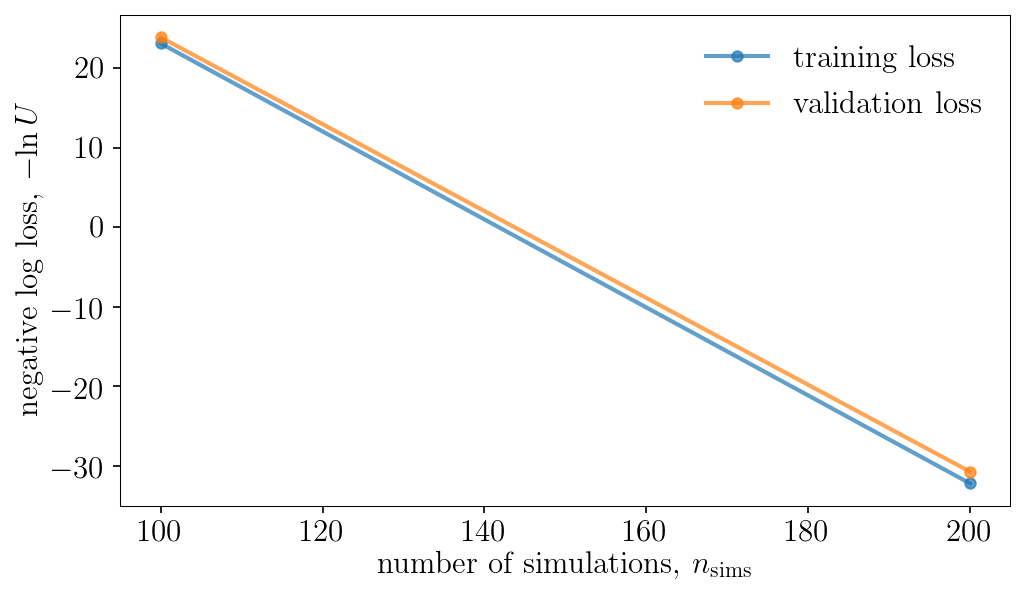

Population 2/10
Sampling proposal density...
Done.


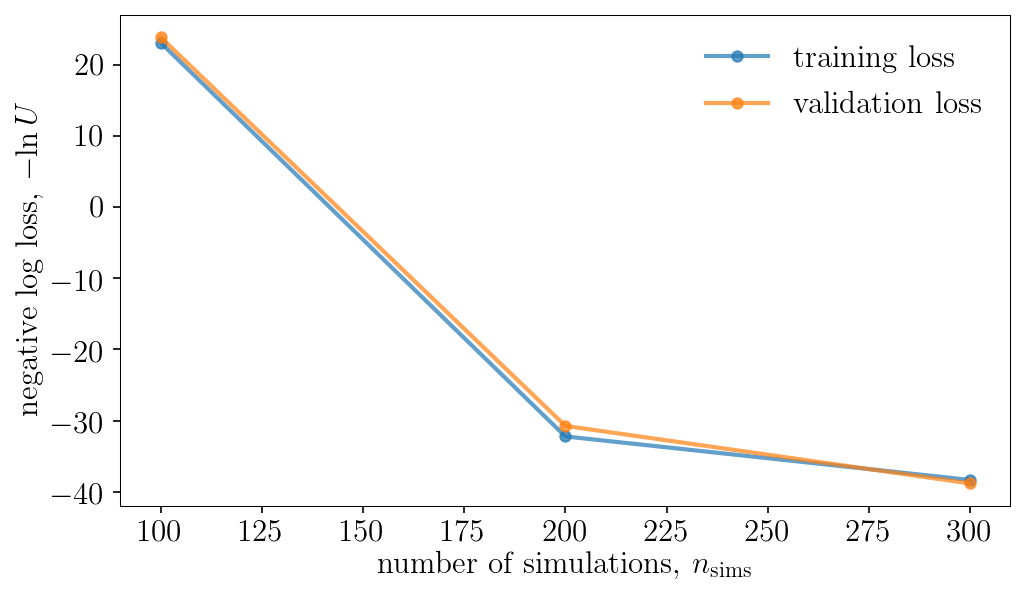

Population 3/10
Sampling proposal density...
Done.


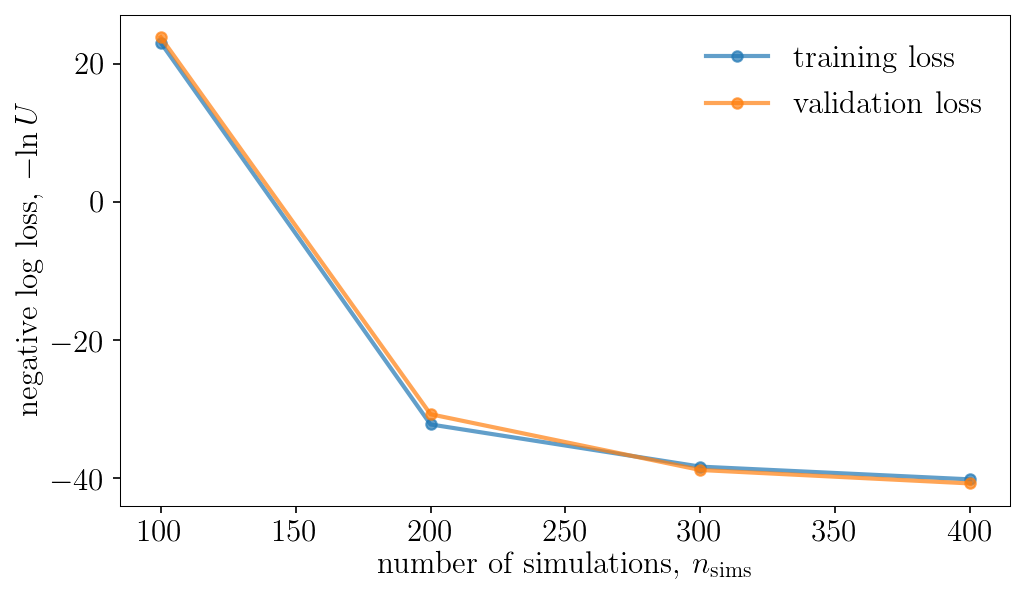

Population 4/10
Sampling proposal density...
Done.


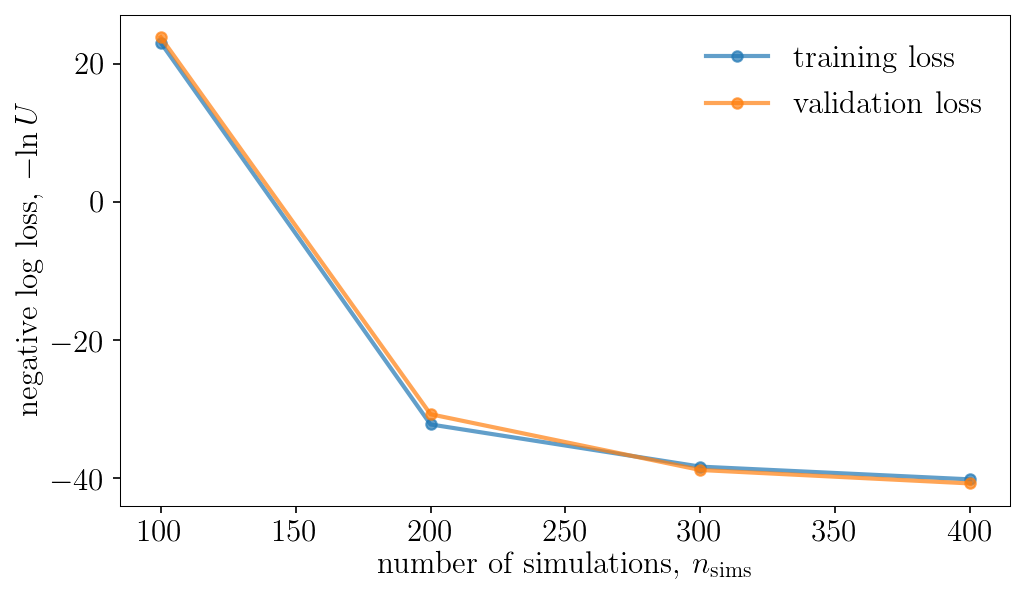

Population 5/10
Sampling proposal density...


/home/aizhana/.local/lib/python3.7/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in double_scalars
  lnpdiff = f + nlp - state.log_prob[j]


Done.


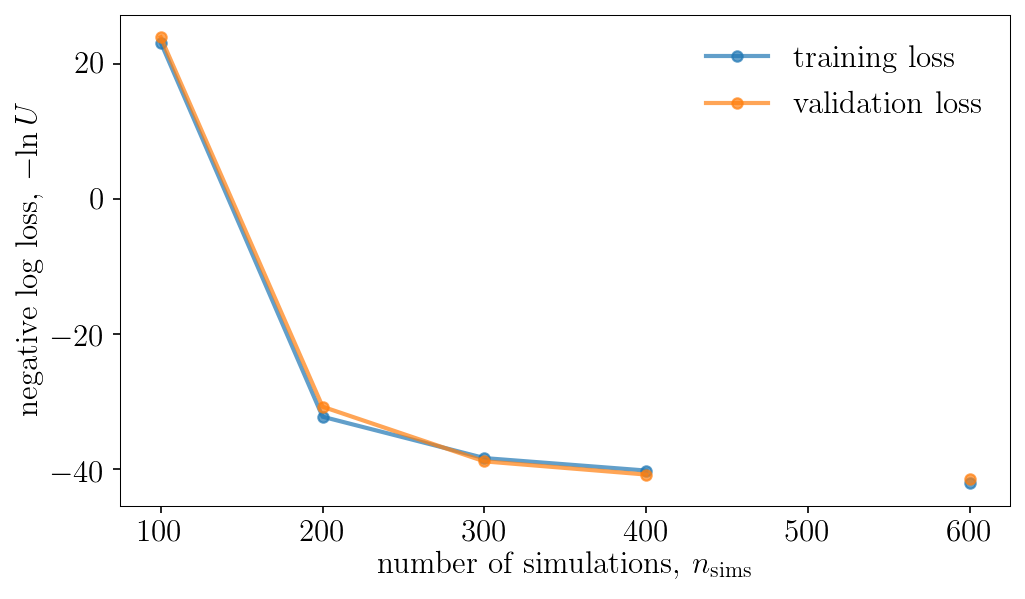

Population 6/10
Sampling proposal density...
Done.


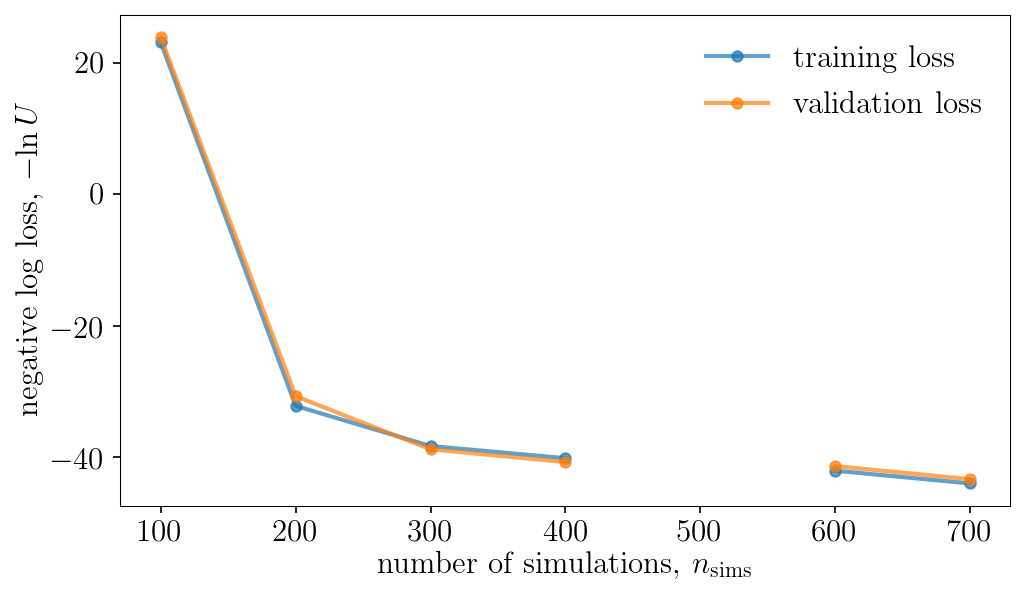

Population 7/10
Sampling proposal density...
Done.


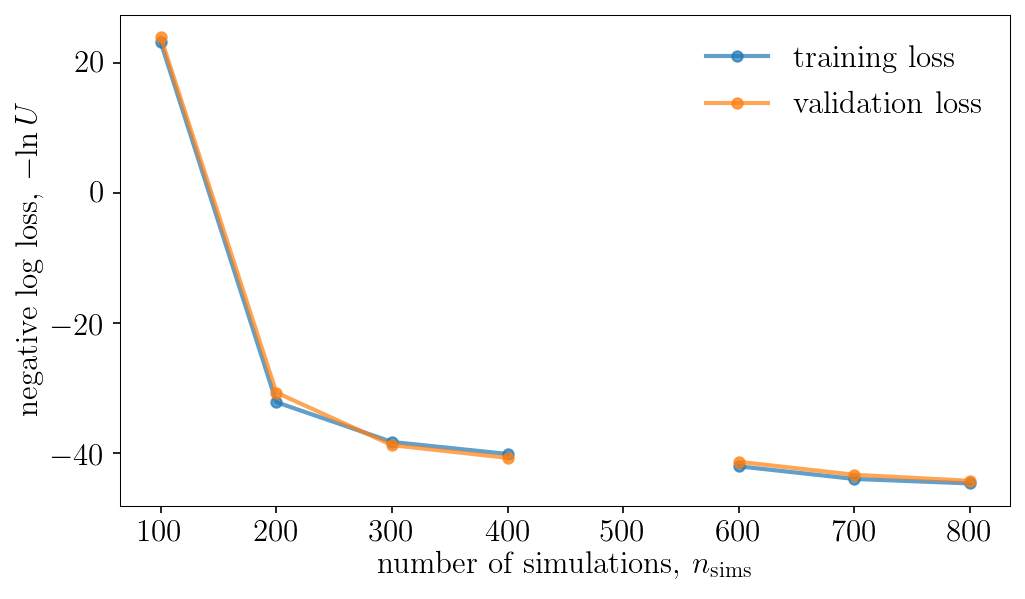

Population 8/10
Sampling proposal density...
Done.


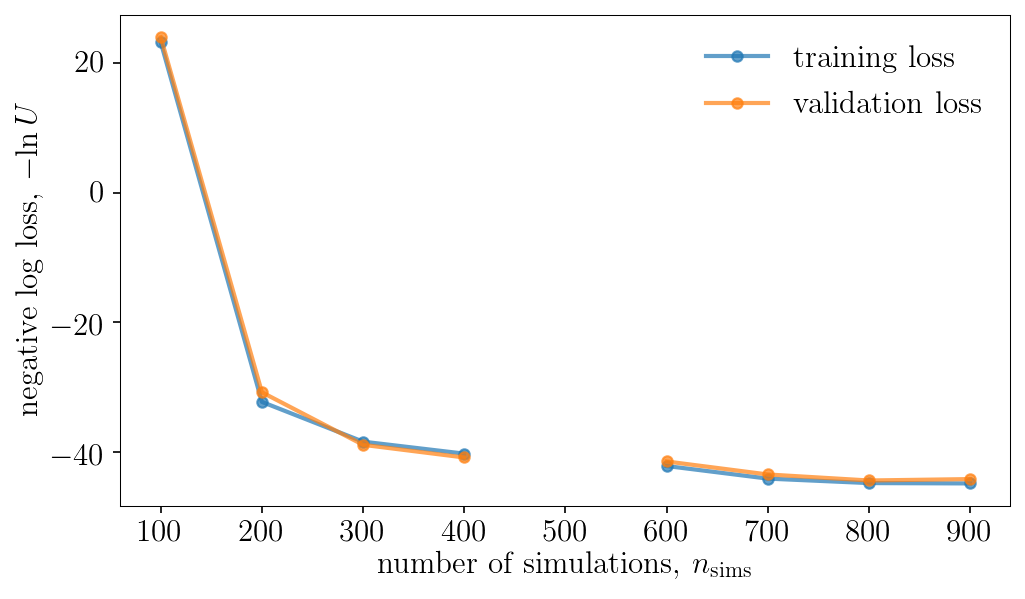

Population 9/10
Sampling proposal density...
Done.


Exception in thread Thread-4:
Traceback (most recent call last):
  File "/home/aizhana/.conda/envs/fast-mpi4py/lib/python3.7/threading.py", line 926, in _bootstrap_inner
    self.run()
  File "/home/aizhana/.conda/envs/fast-mpi4py/lib/python3.7/site-packages/tqdm/_monitor.py", line 78, in run
    instances = self.get_instances()
  File "/home/aizhana/.conda/envs/fast-mpi4py/lib/python3.7/site-packages/tqdm/_monitor.py", line 58, in get_instances
    return [i for i in self.tqdm_cls._instances.copy()
  File "/home/aizhana/.conda/envs/fast-mpi4py/lib/python3.7/_weakrefset.py", line 92, in copy
    return self.__class__(self)
  File "/home/aizhana/.conda/envs/fast-mpi4py/lib/python3.7/_weakrefset.py", line 50, in __init__
    self.update(data)
  File "/home/aizhana/.conda/envs/fast-mpi4py/lib/python3.7/_weakrefset.py", line 119, in update
    for element in other:
  File "/home/aizhana/.conda/envs/fast-mpi4py/lib/python3.7/_weakrefset.py", line 60, in __iter__
    for itemref in self.data

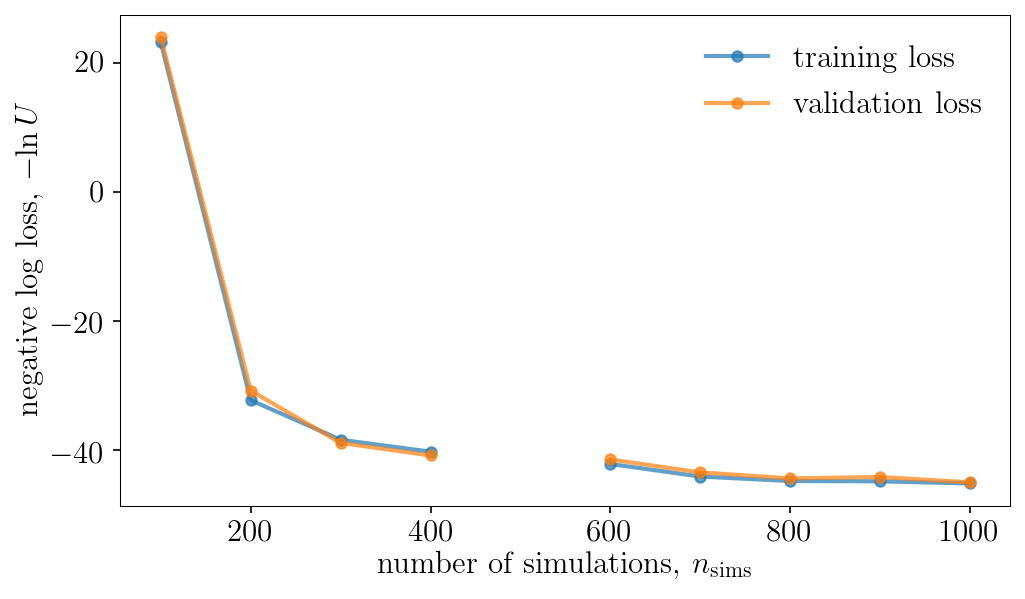

Population 10/10
Sampling proposal density...
Done.


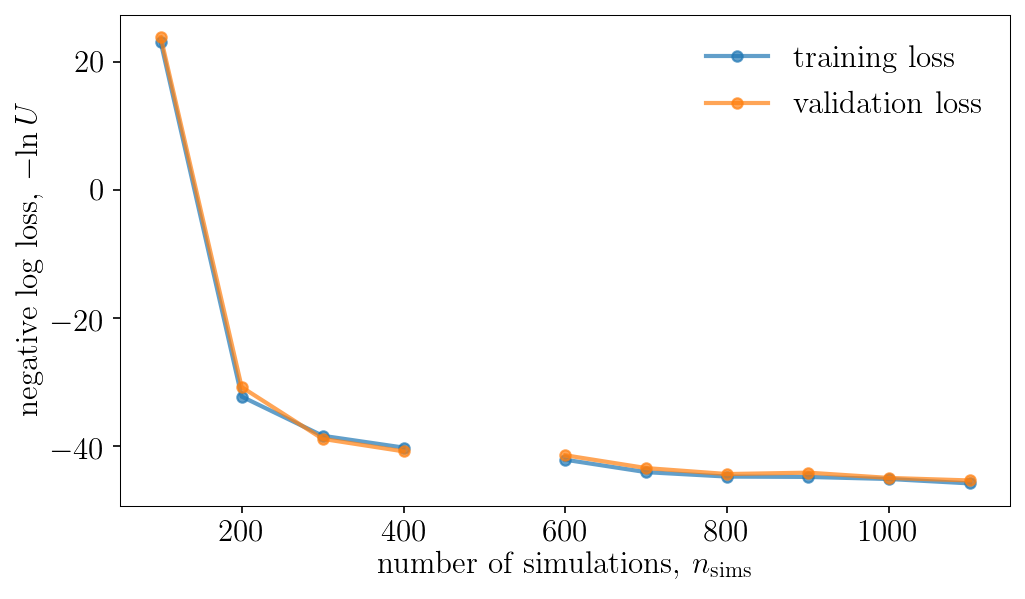

In [21]:
DelfiEnsemble2.sequential_training(simulator, compressor, n_initial, n_batch, n_populations, patience=20, 
                                  save_intermediate_posteriors=False)

In [22]:
x0 = DelfiEnsemble2.posterior_samples[np.random.choice(np.arange(len(DelfiEnsemble2.posterior_samples)), 
                                                       p=DelfiEnsemble2.posterior_weights.astype(np.float32)/sum(DelfiEnsemble2.posterior_weights), 
                                                       replace=False, size=DelfiEnsemble2.nwalkers),:]
posterior_samples, posterior_weights, log_prob = DelfiEnsemble2.emcee_sample(x0=x0)


/home/aizhana/.local/lib/python3.7/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in double_scalars
  lnpdiff = f + nlp - state.log_prob[j]


Removed no burn in


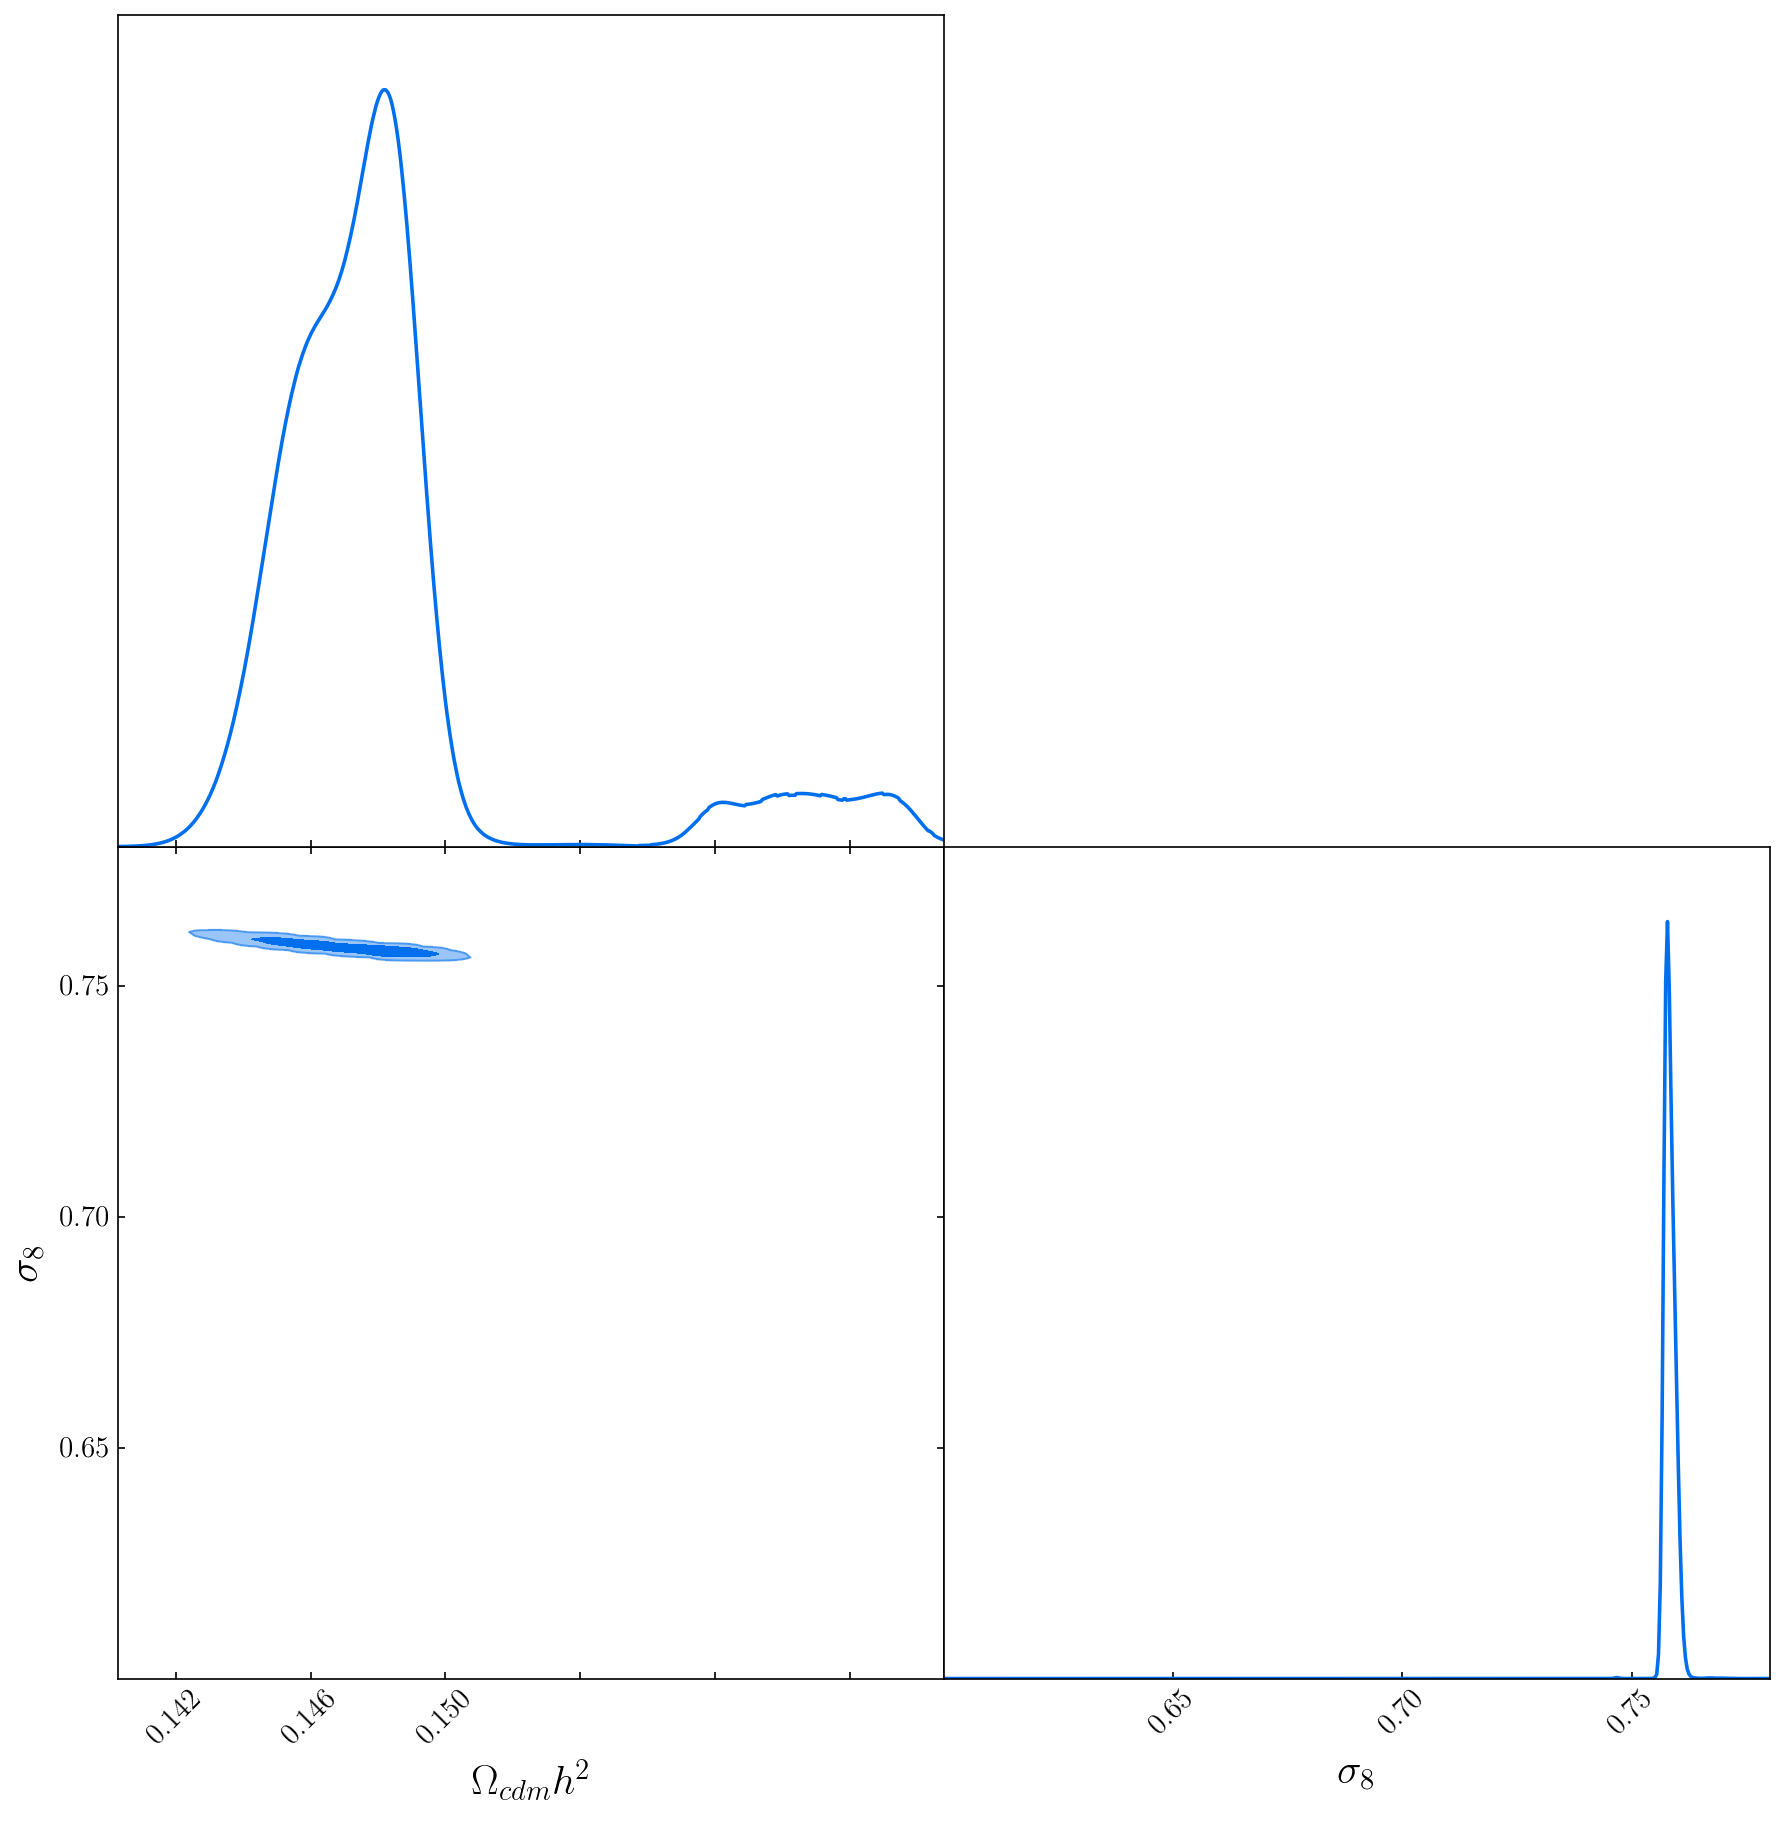

In [23]:
DelfiEnsemble2.triangle_plot(samples=[posterior_samples], weights=[posterior_weights])

## Create DELFI object

In [19]:
DelfiEnsemble = delfi.Delfi(N_counts_data.reshape(n_data_points), prior, NDEs1, 
                            theta_fiducial = theta_fiducial, 
                            param_limits = [lower, upper],
                            param_names = ['\\Omega_{cdm}h^{2}', '\\sigma_{8}'],
                            results_dir = "simulators/mass_function_n_counts/results_nonzero_counts_2params_omega_b_1000sims/")

## Sequential Neural Likelihood

In [21]:
n_initial = 20 #200
n_batch = 50 #200
n_populations = 20 #20

Sampling approximate posterior...
Done.
Removed no burn in


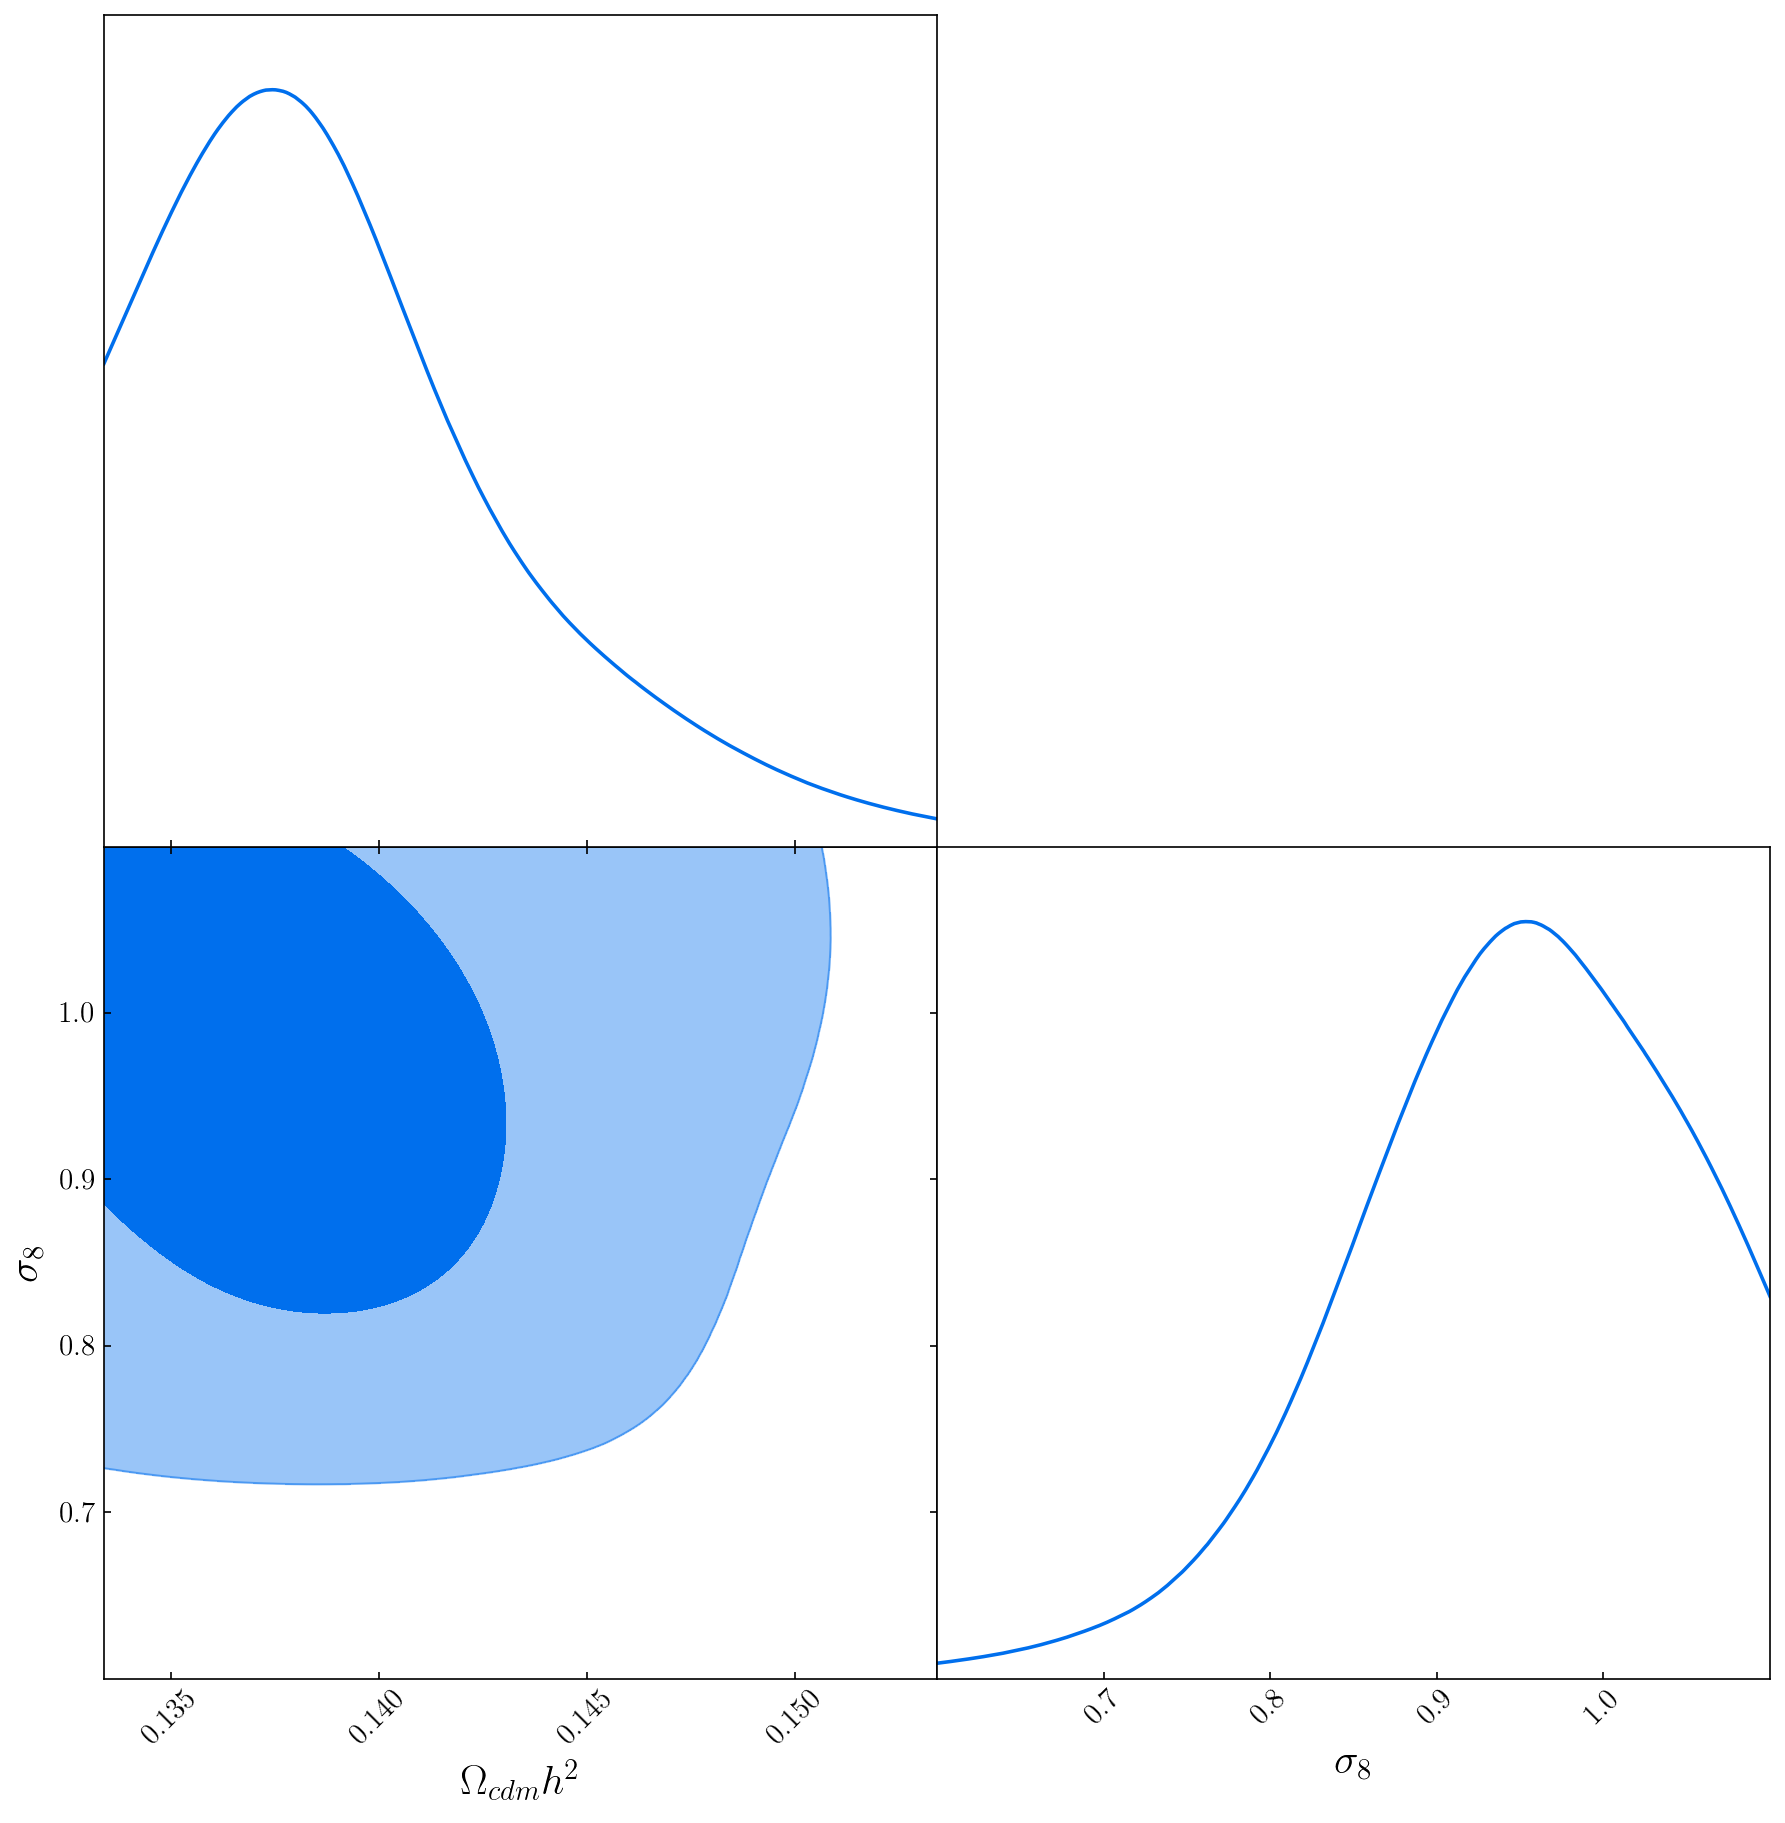

Population 1/20
Sampling proposal density...
Done.


Sampling approximate posterior...
Done.
Removed no burn in


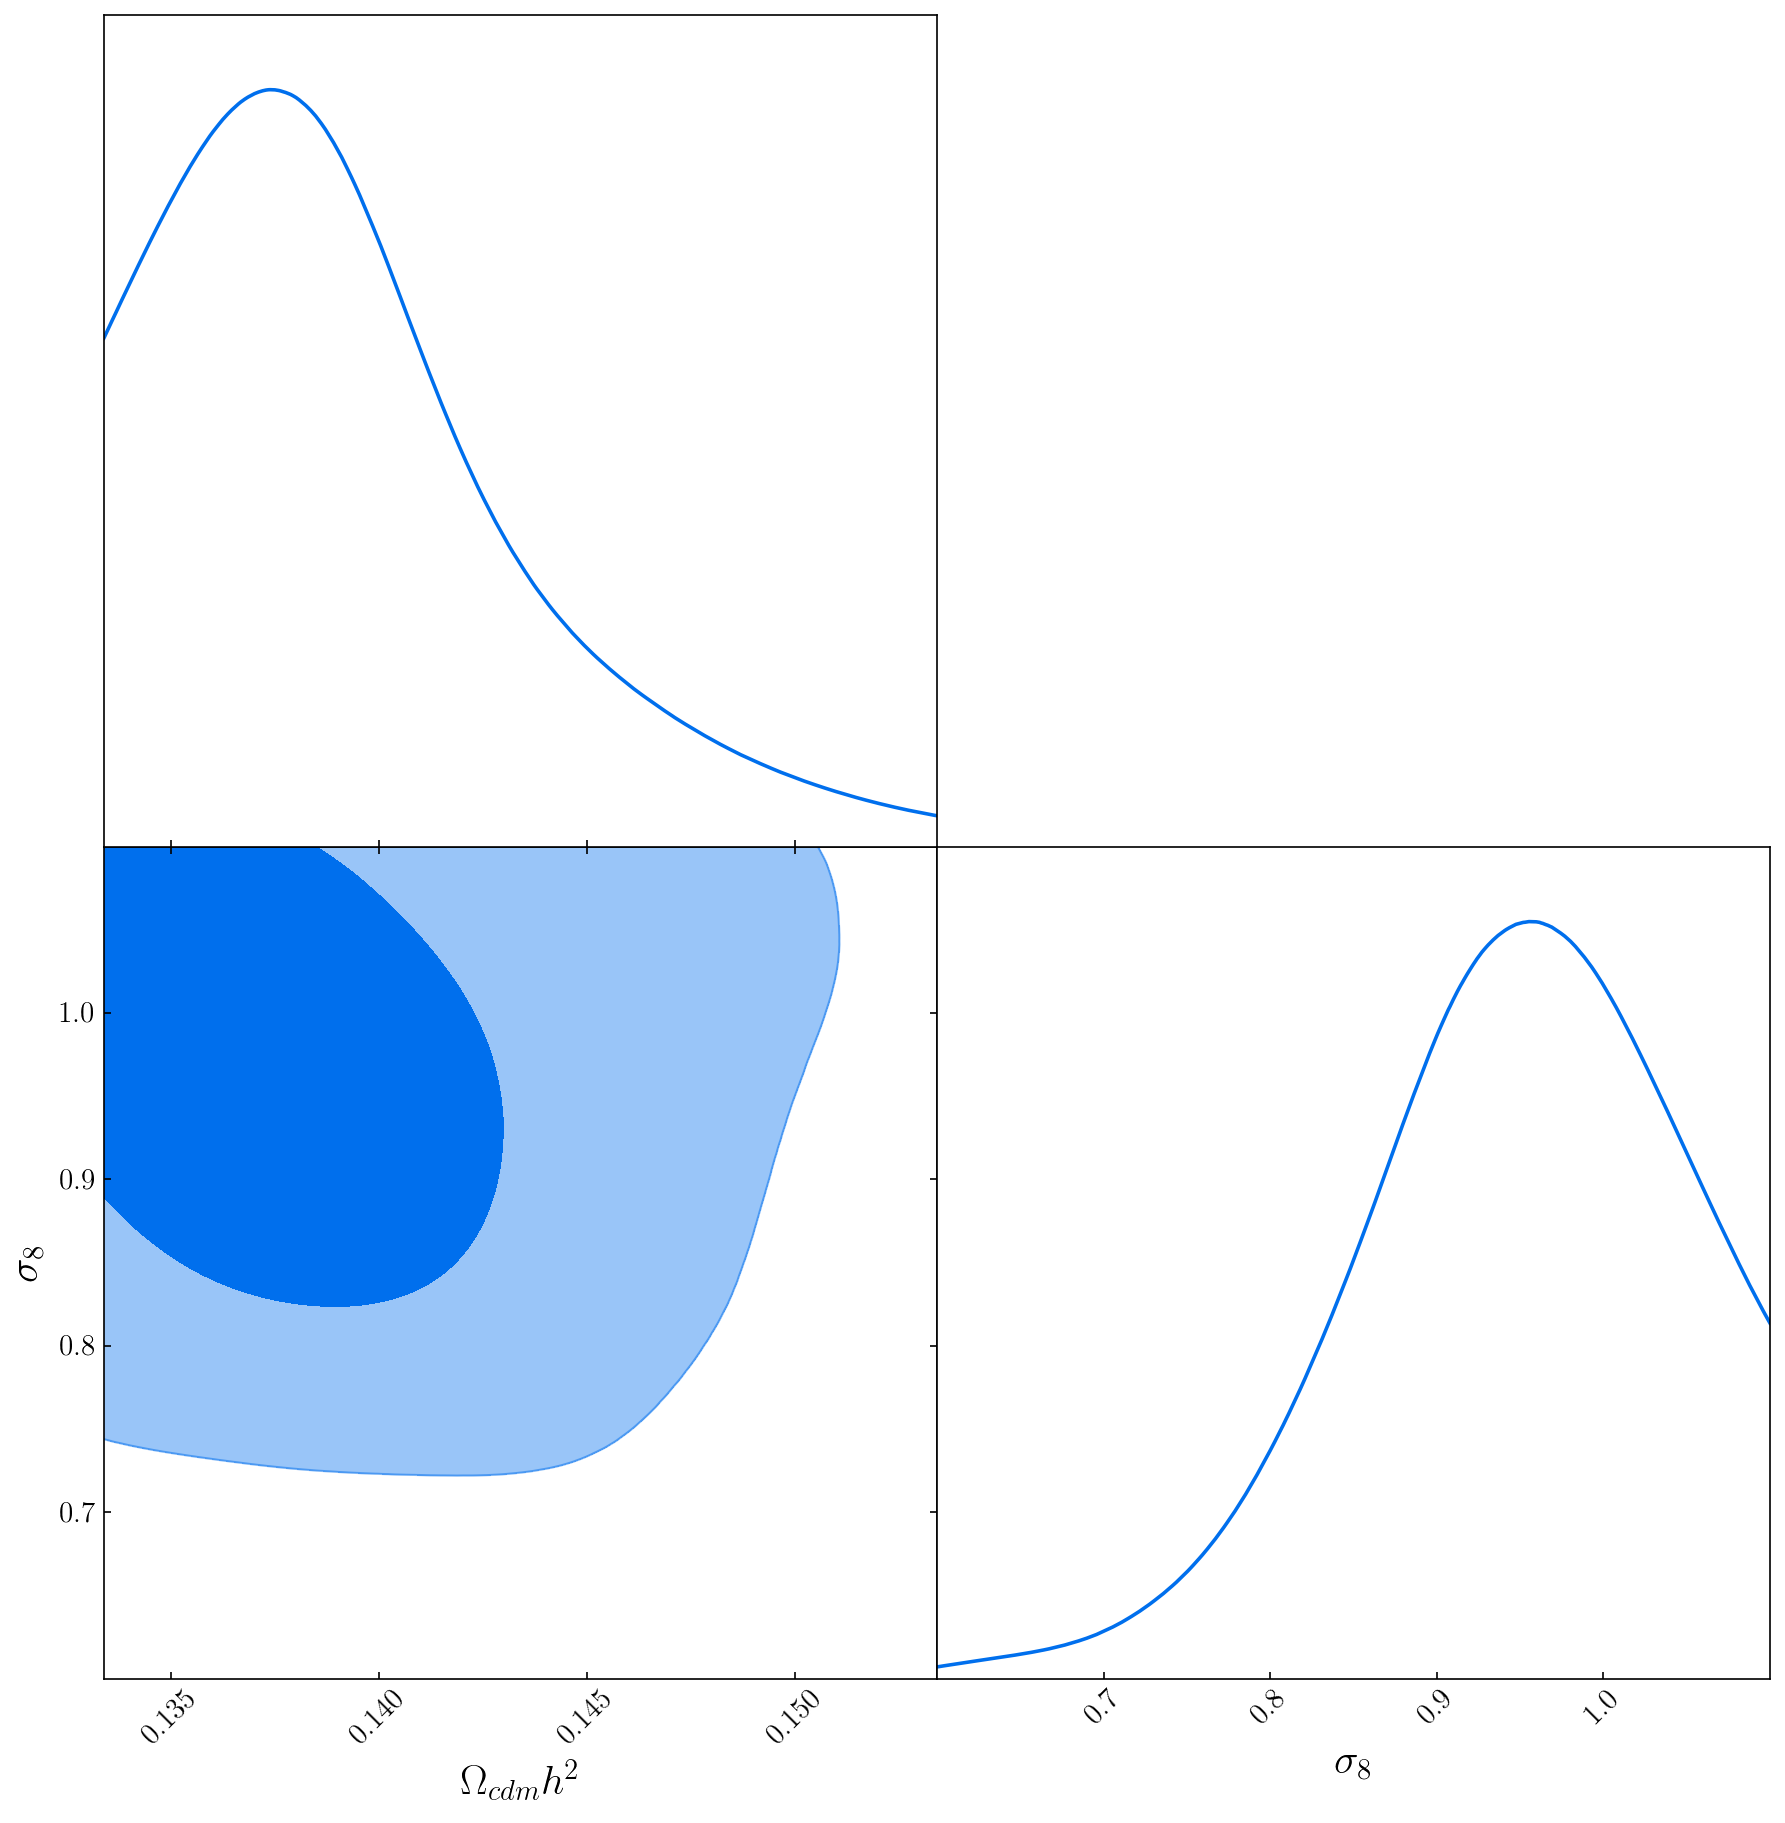

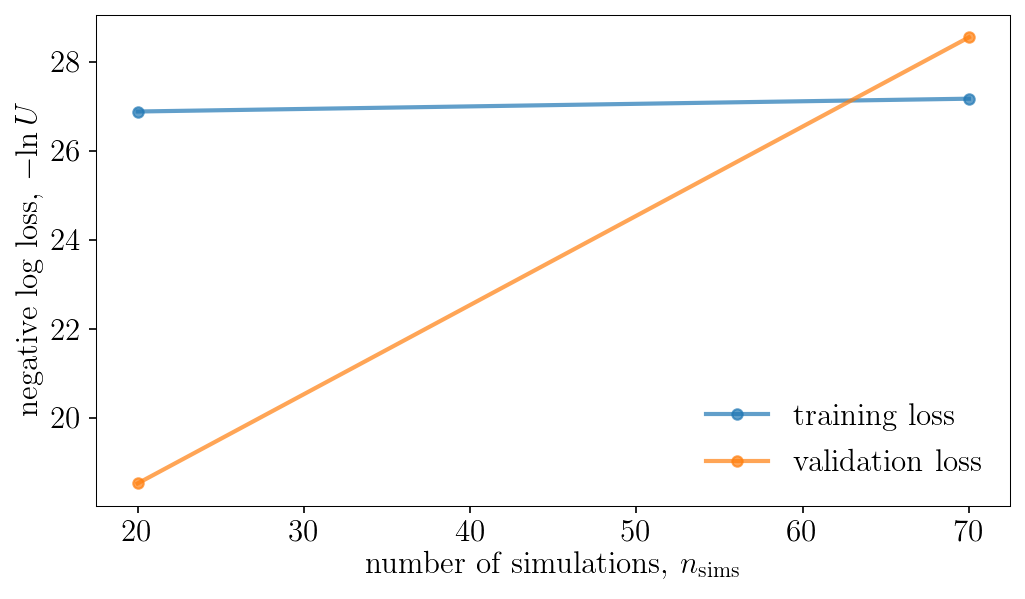

Population 2/20
Sampling proposal density...
Done.


Sampling approximate posterior...


/home/aizhana/.local/lib/python3.7/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in double_scalars
  lnpdiff = f + nlp - state.log_prob[j]


Done.
Removed no burn in


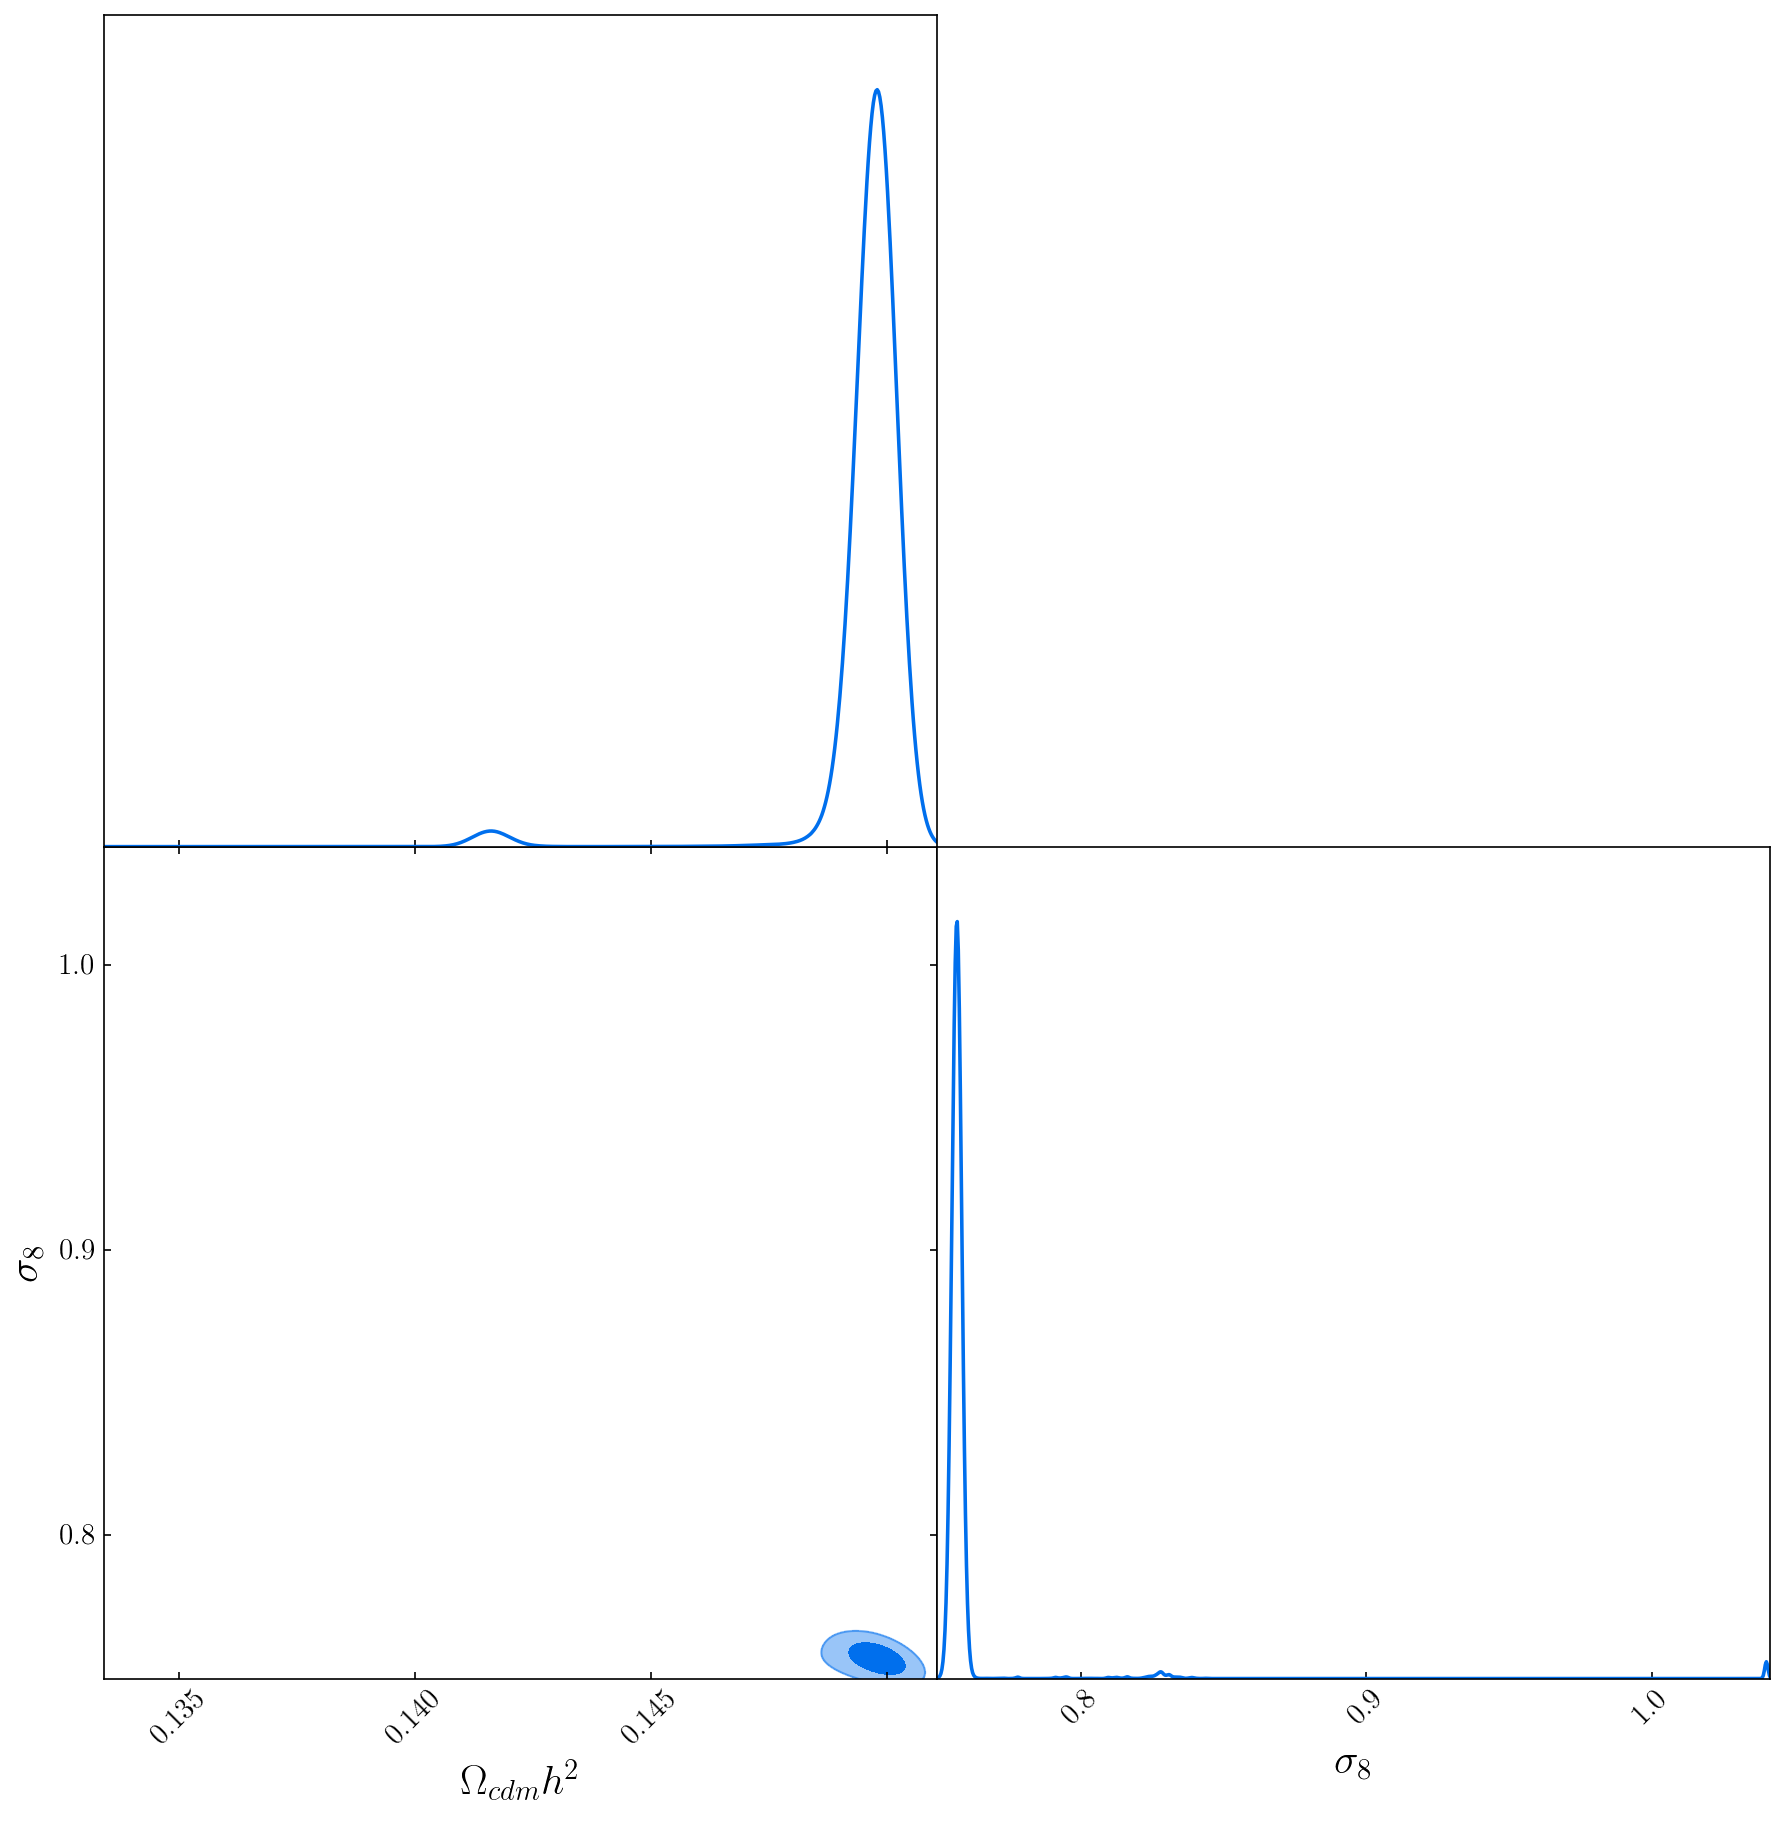

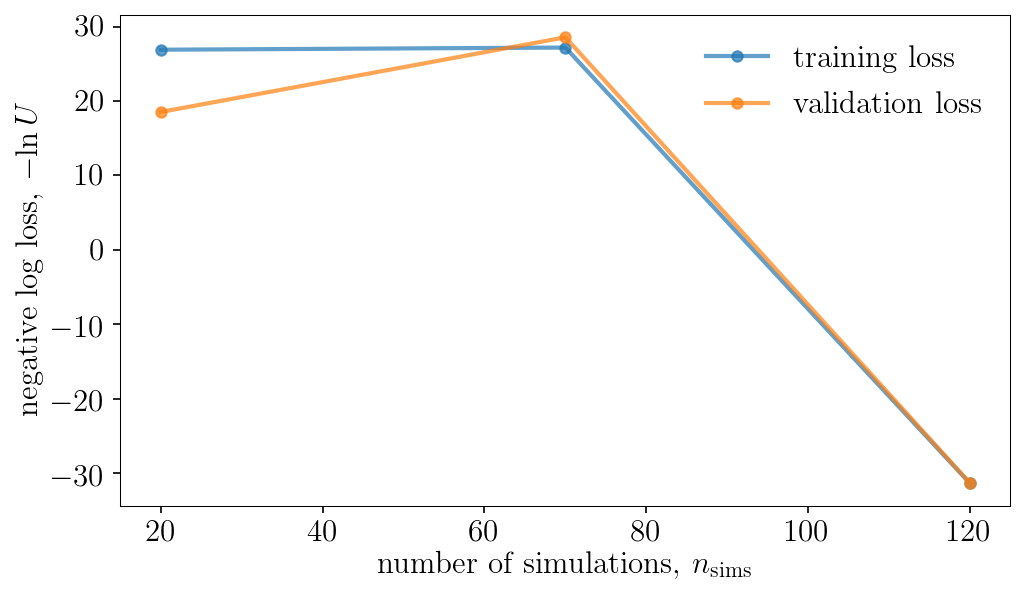

Population 3/20
Sampling proposal density...
Done.


Sampling approximate posterior...


/home/aizhana/.local/lib/python3.7/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in double_scalars
  lnpdiff = f + nlp - state.log_prob[j]


Done.
Removed no burn in


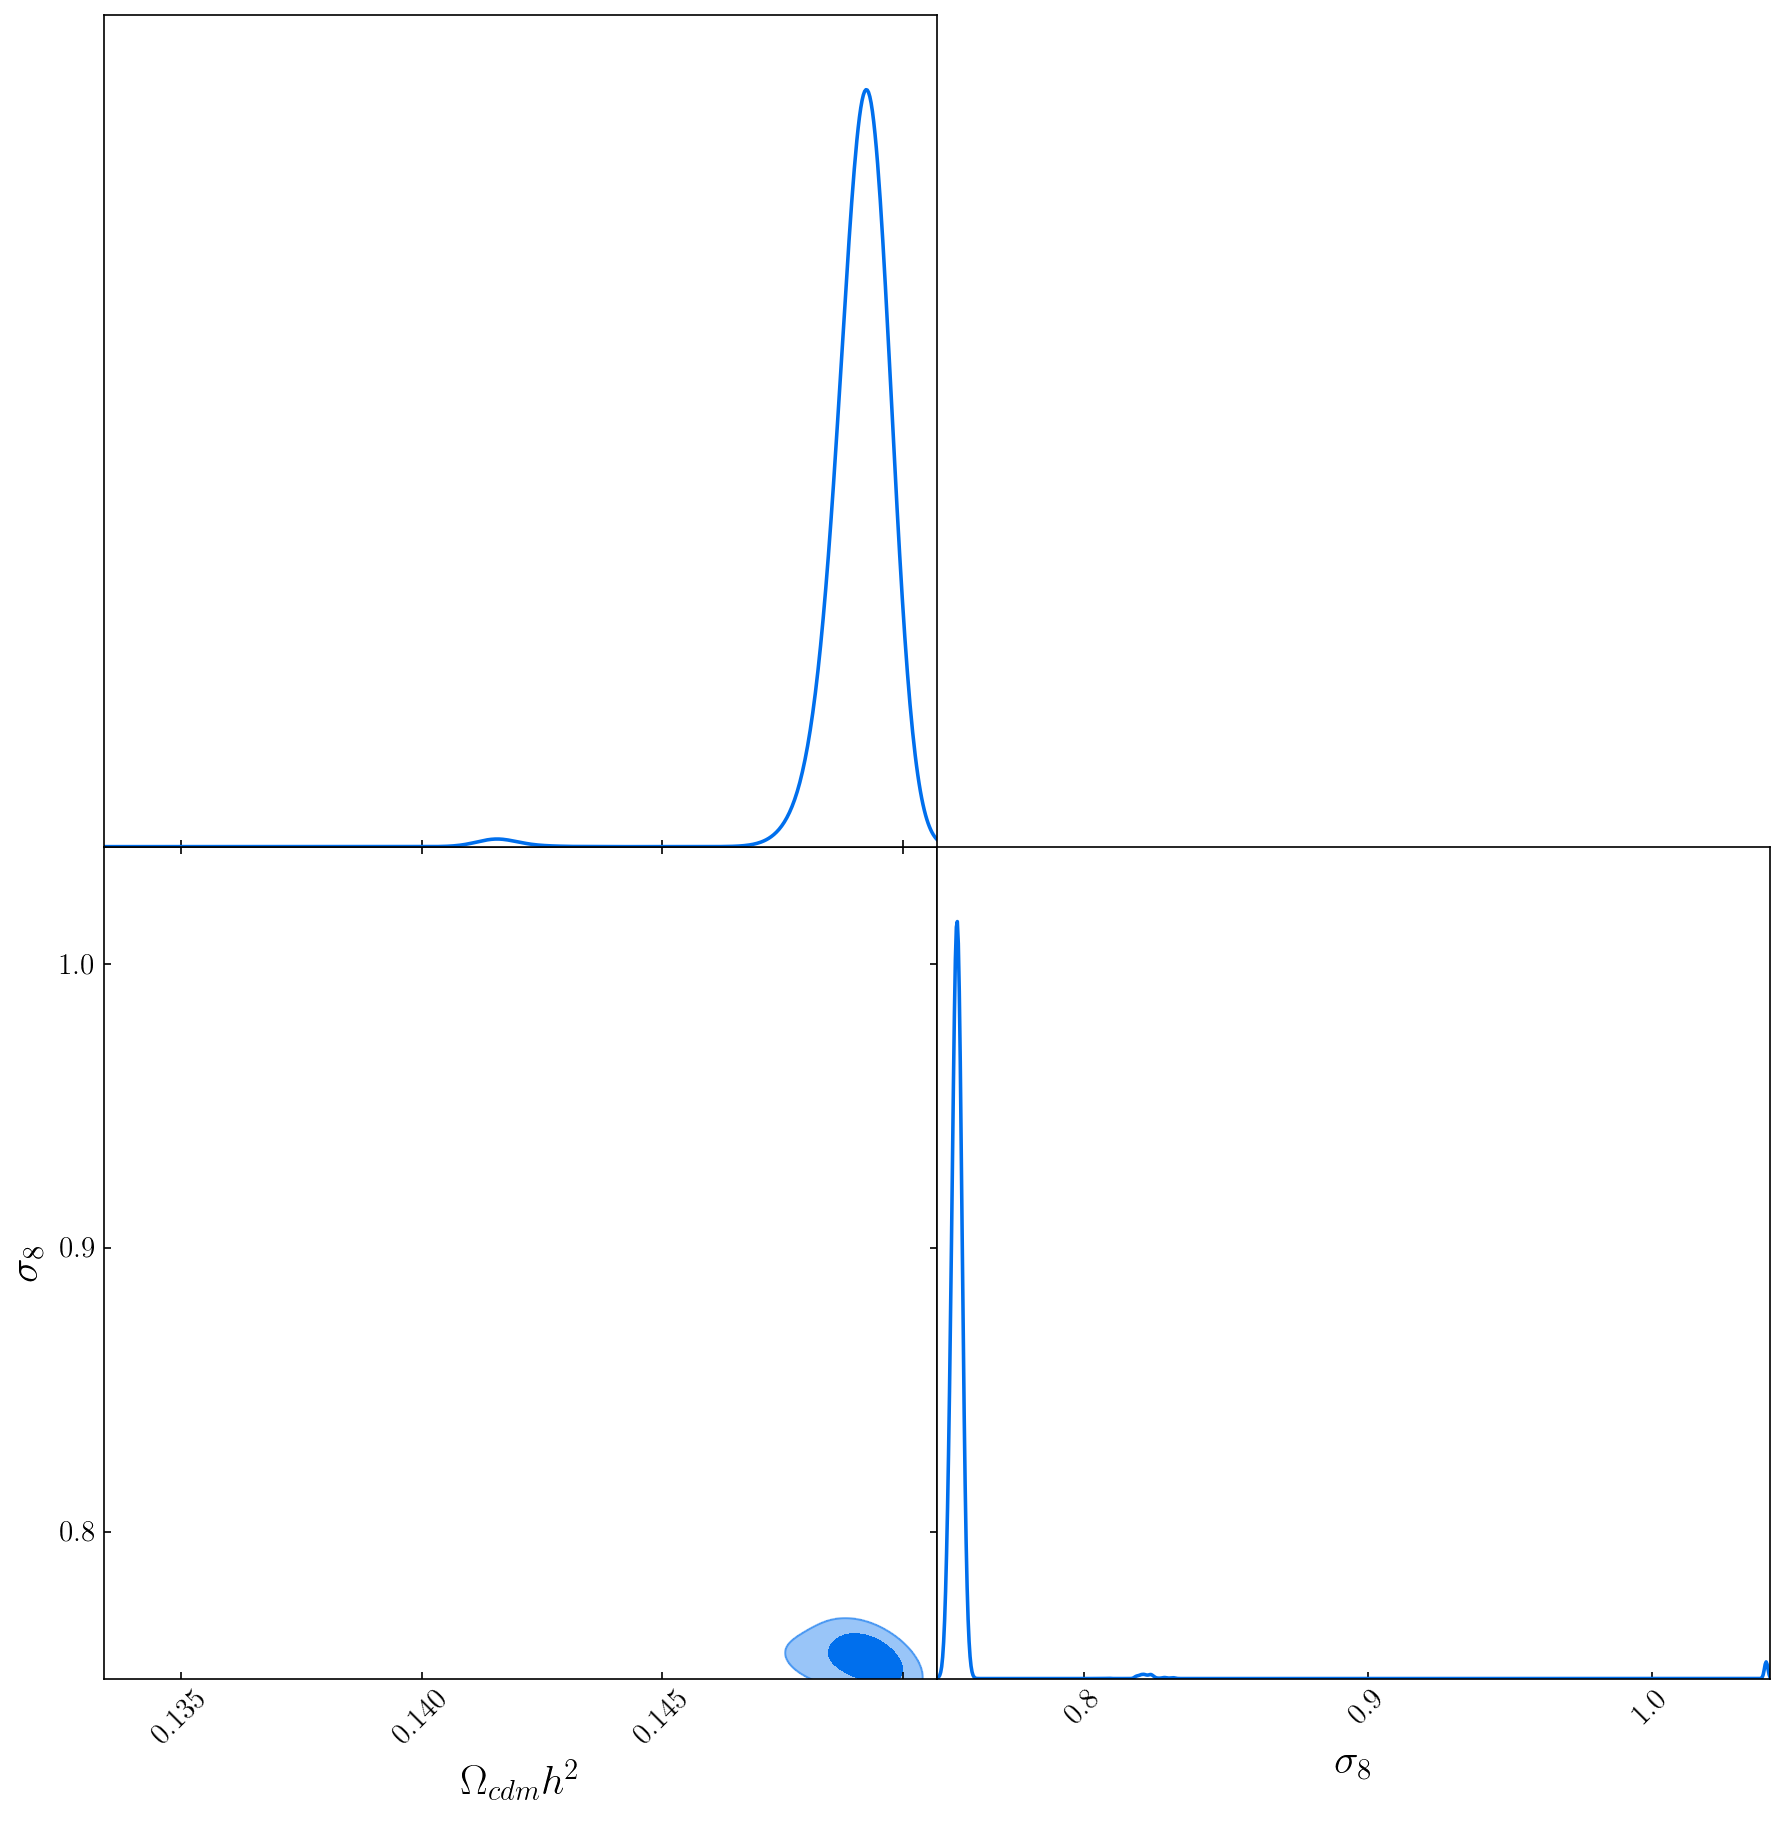

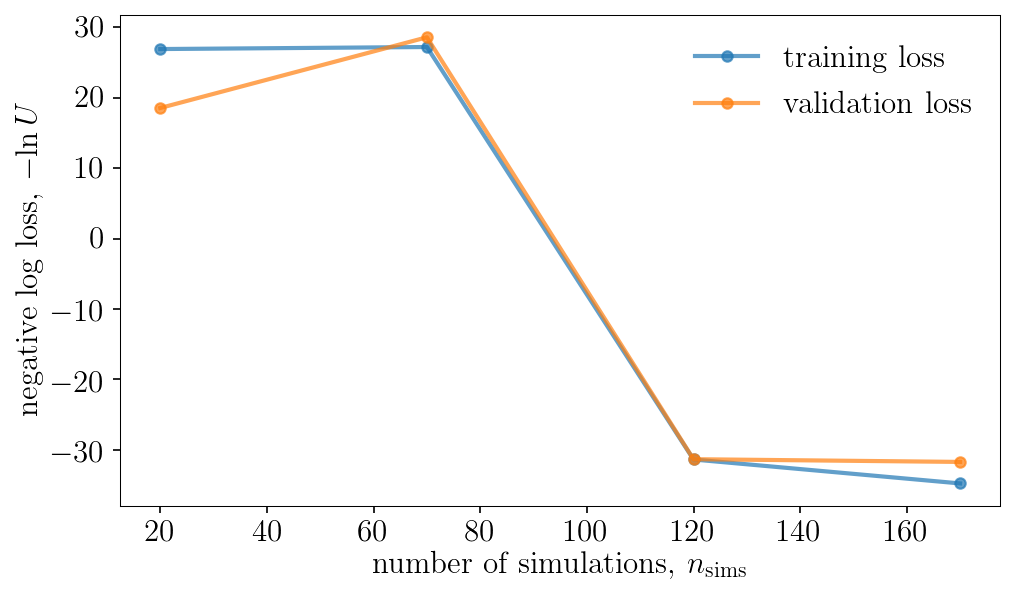

Population 4/20
Sampling proposal density...


/home/aizhana/.local/lib/python3.7/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in double_scalars
  lnpdiff = f + nlp - state.log_prob[j]


Done.


Sampling approximate posterior...


Done.
Removed no burn in


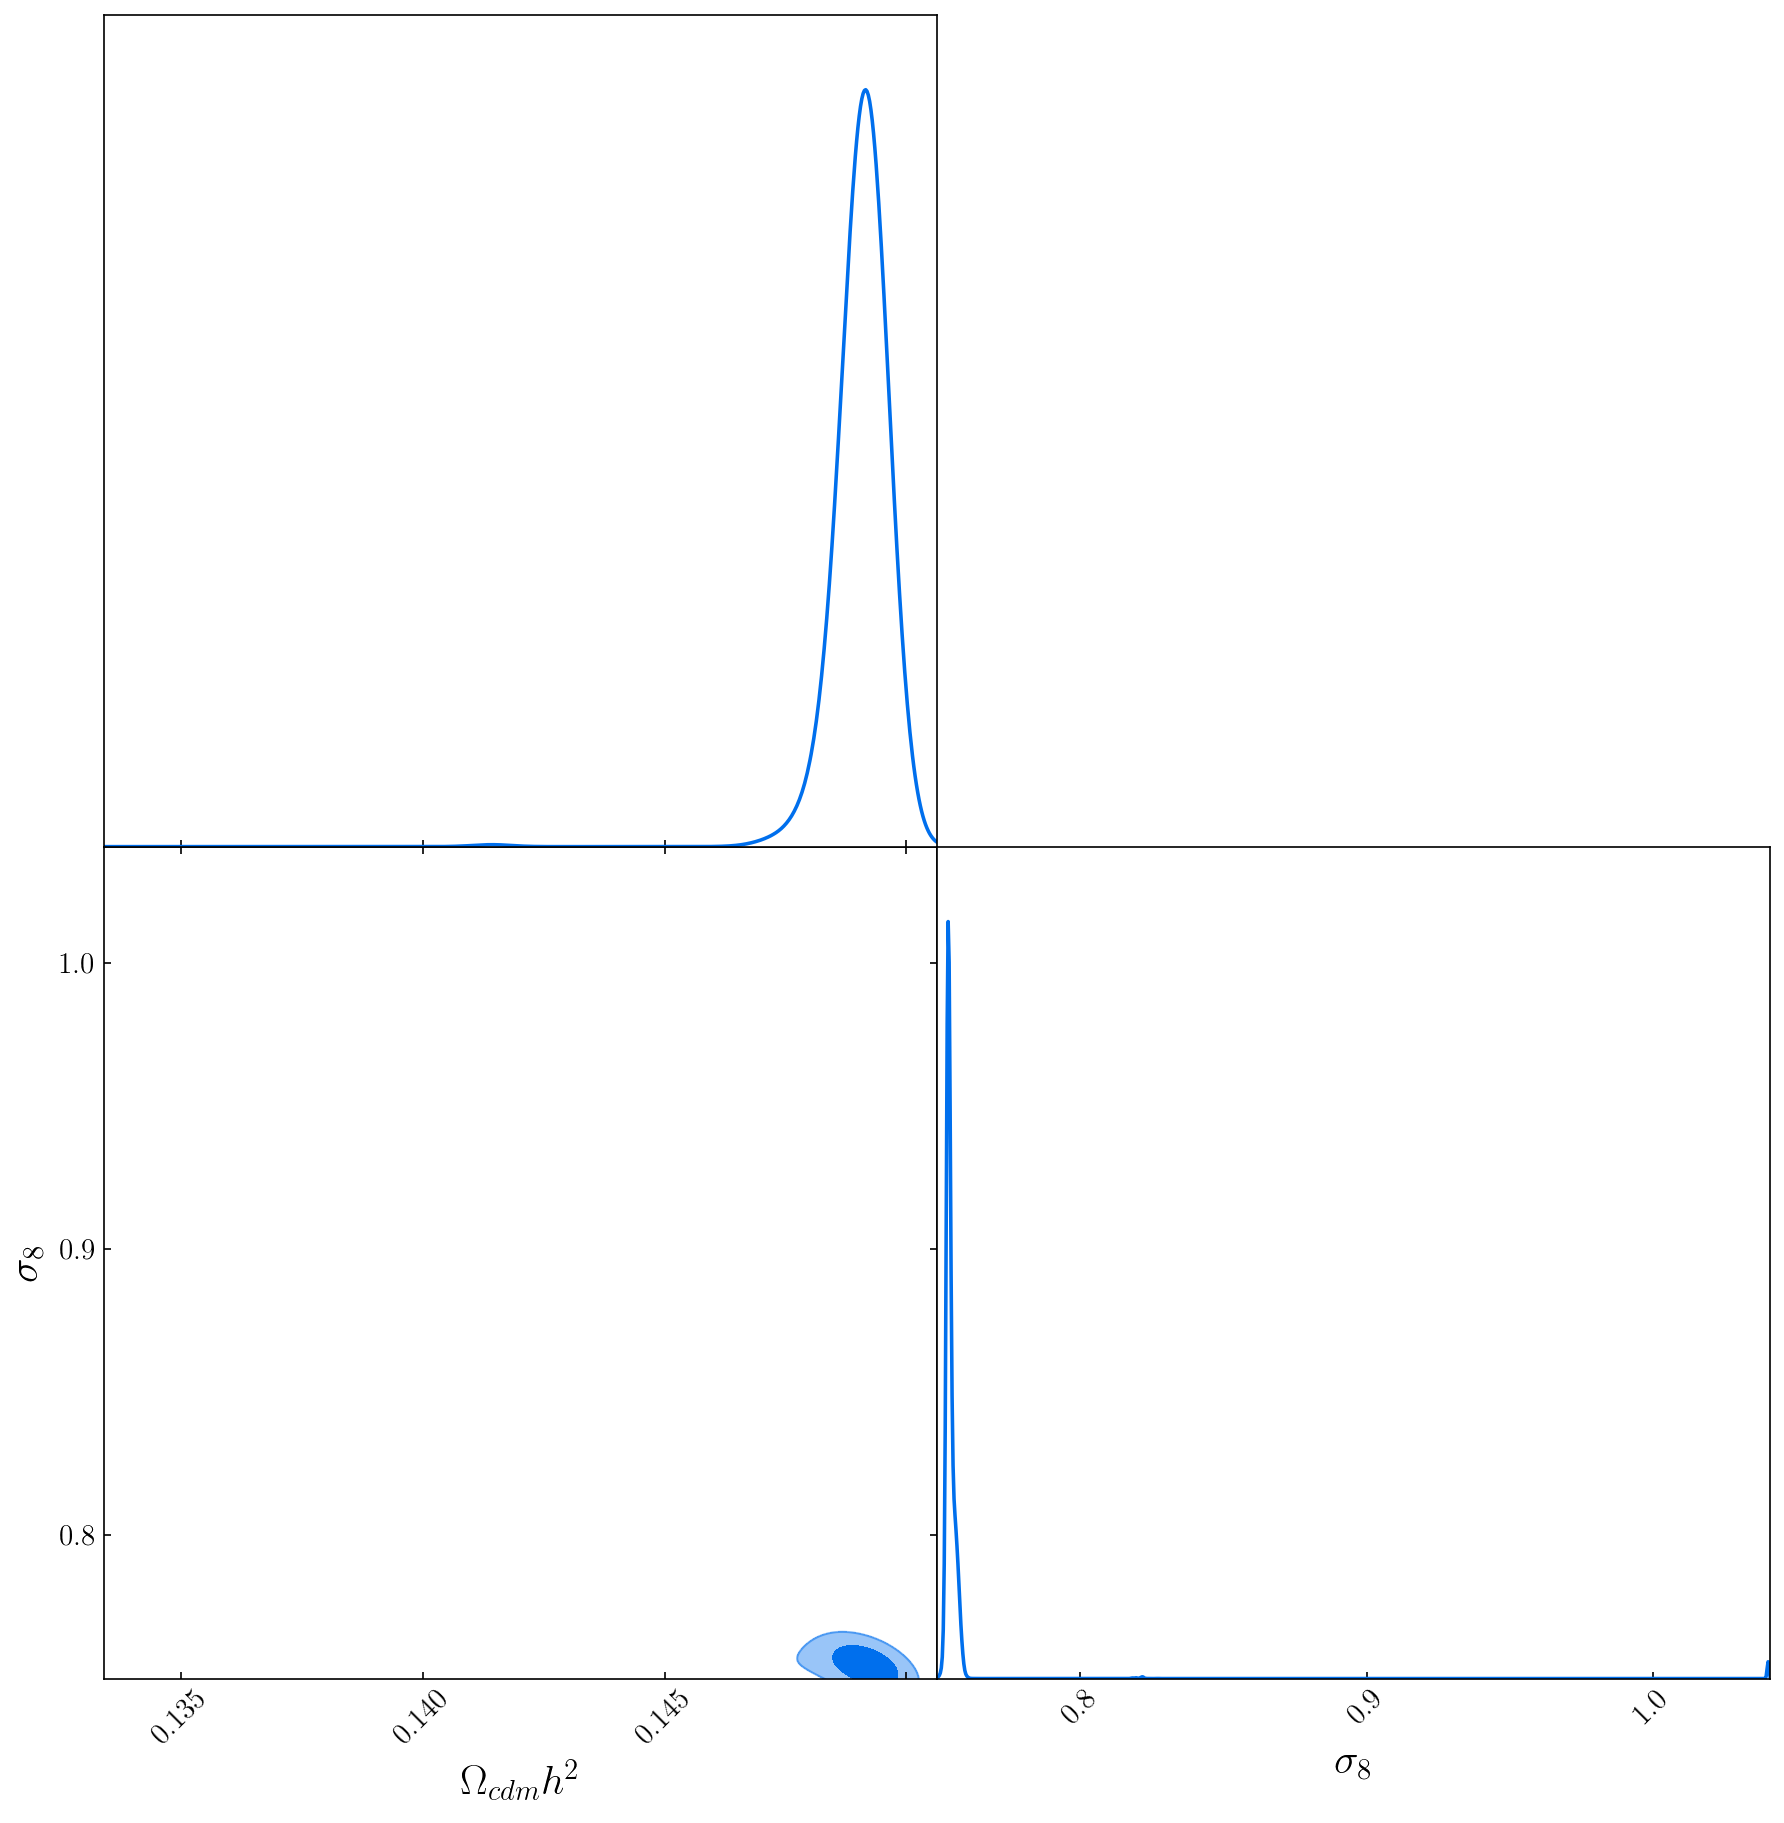

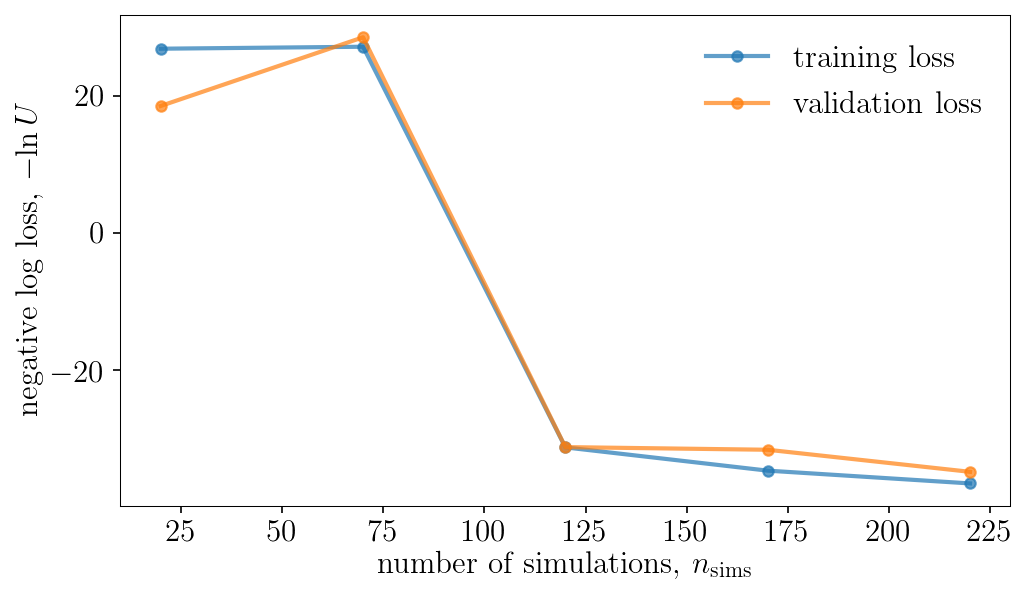

Population 5/20
Sampling proposal density...


/home/aizhana/.local/lib/python3.7/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in double_scalars
  lnpdiff = f + nlp - state.log_prob[j]


Done.


Sampling approximate posterior...


Done.
Removed no burn in


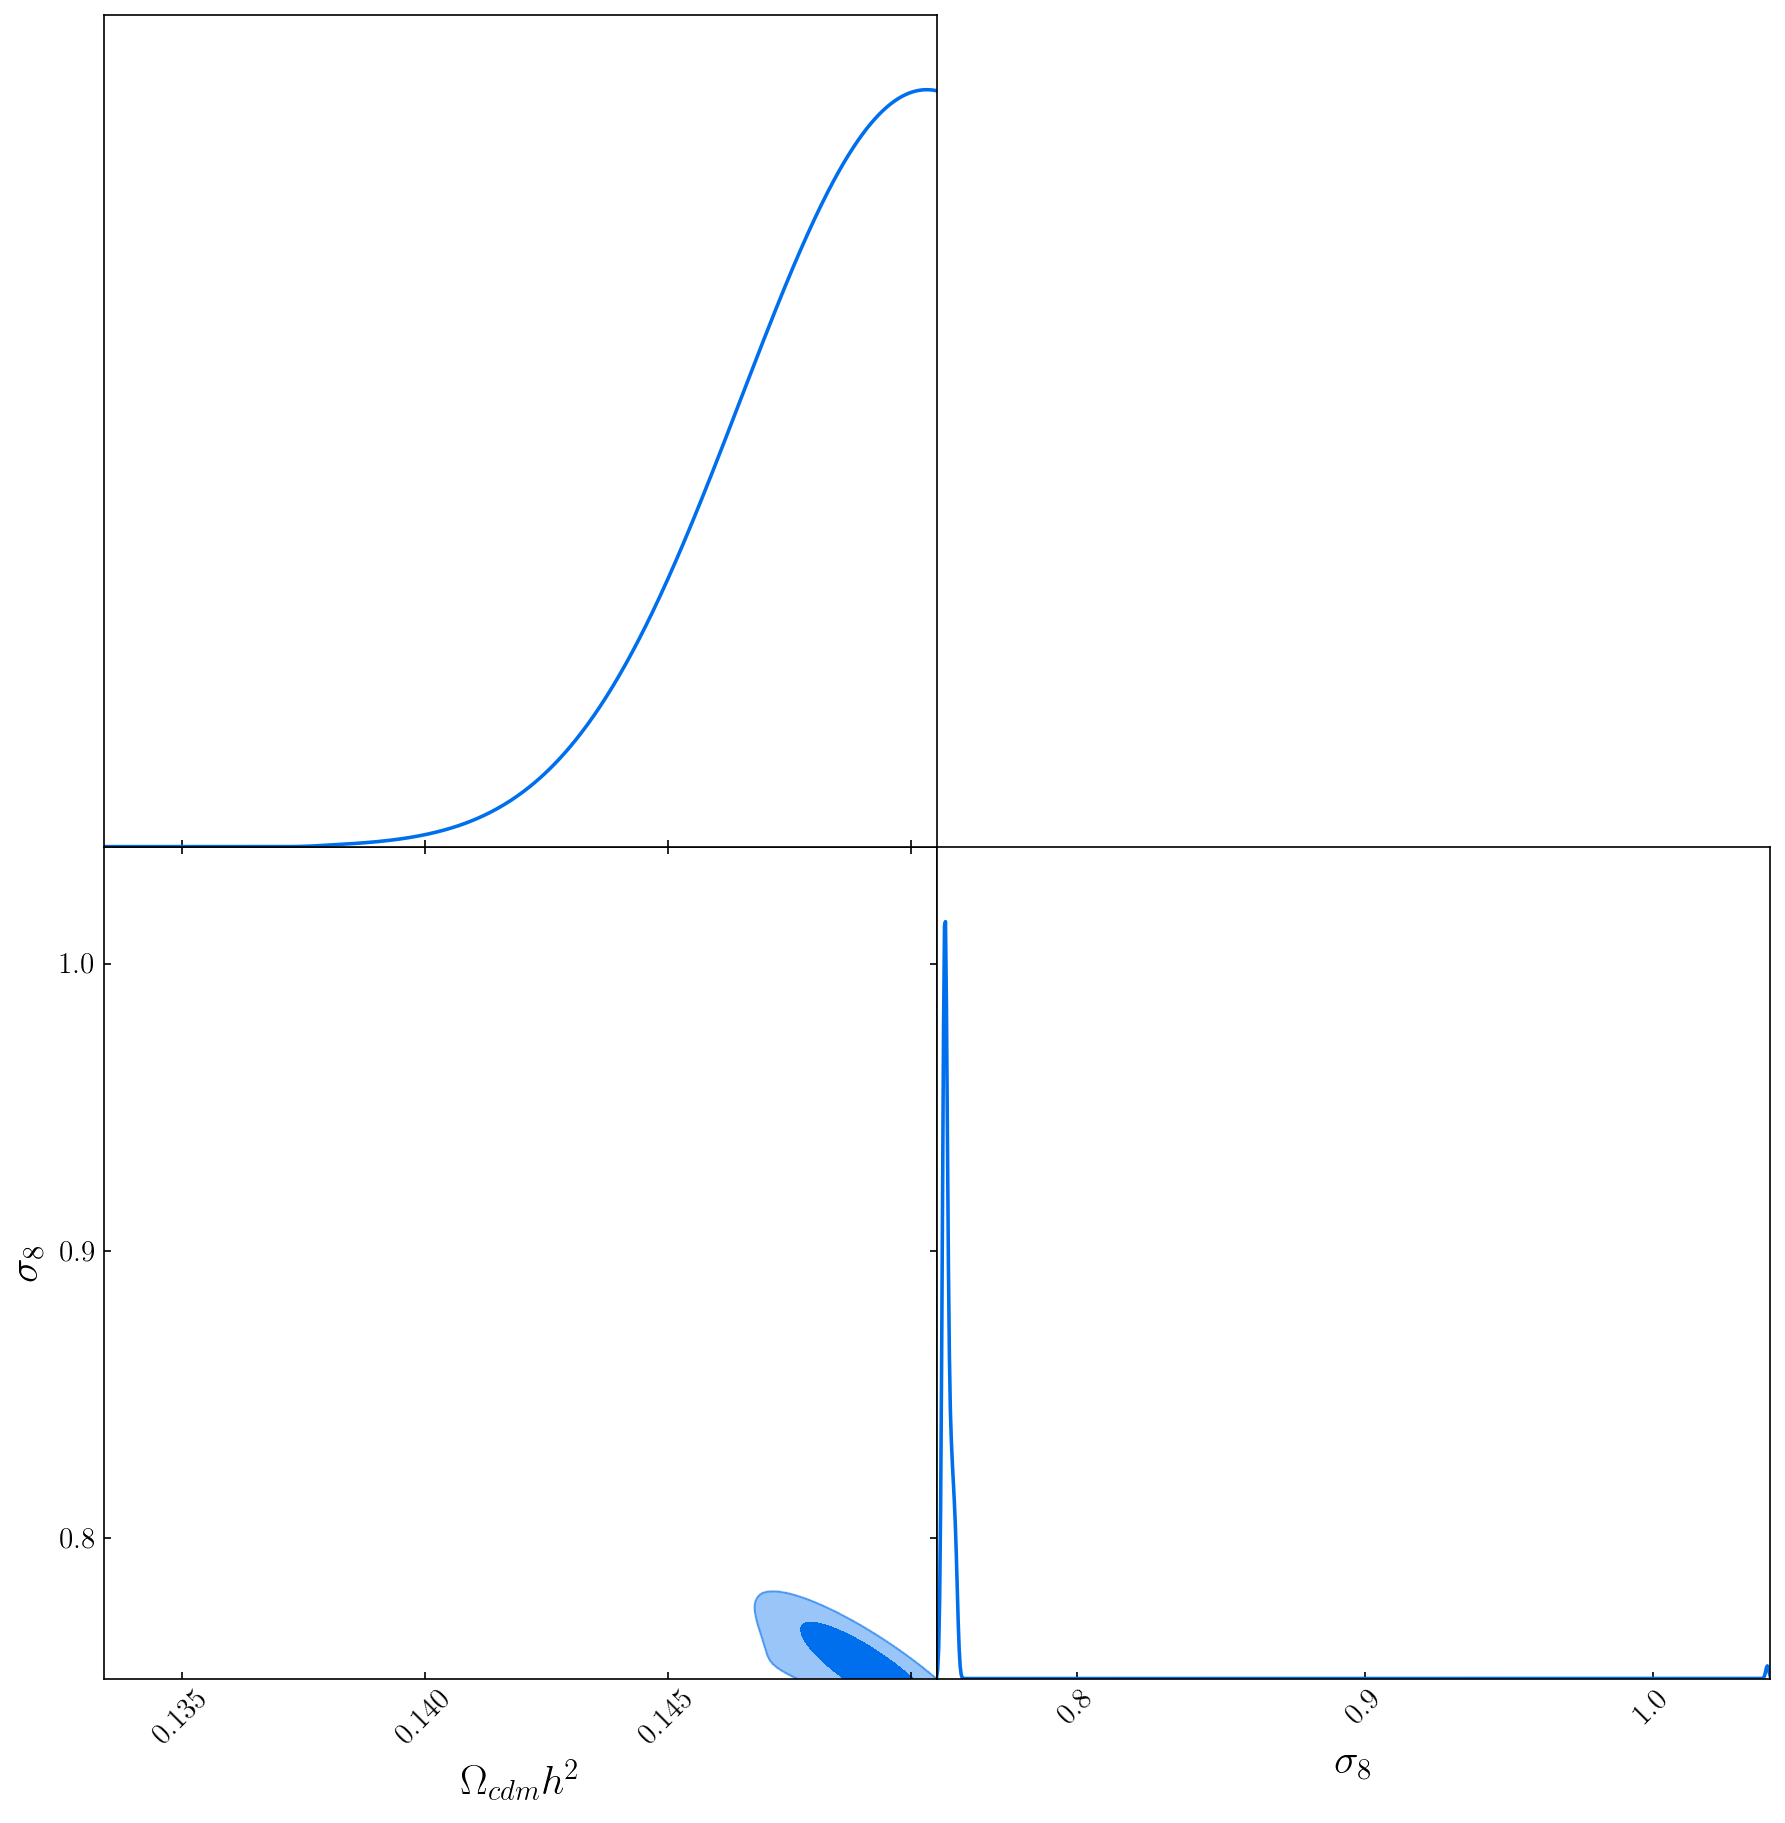

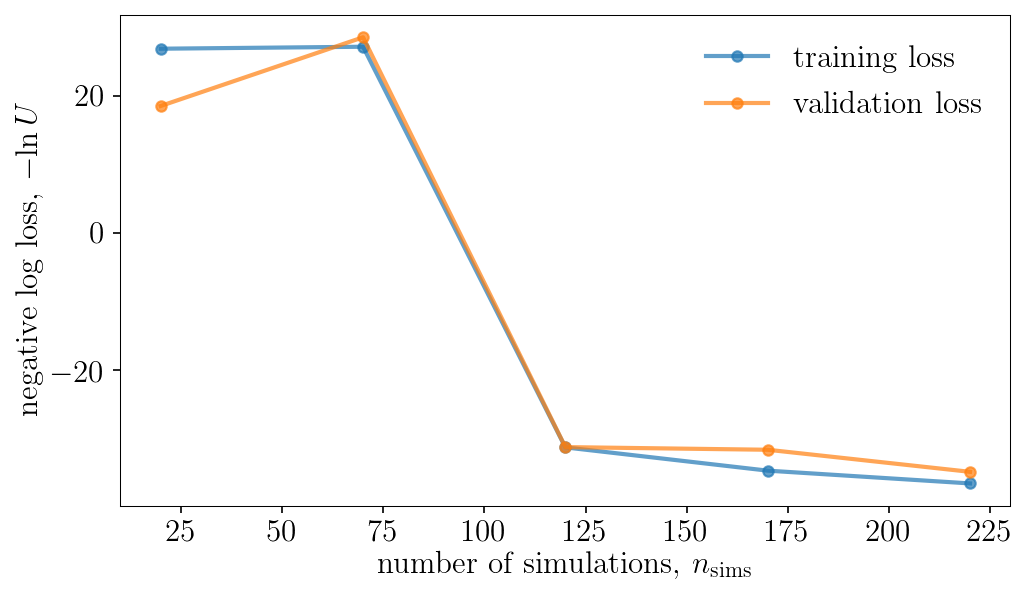

Population 6/20
Sampling proposal density...


/home/aizhana/.local/lib/python3.7/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in double_scalars
  lnpdiff = f + nlp - state.log_prob[j]


Done.


Sampling approximate posterior...


Done.
Removed no burn in


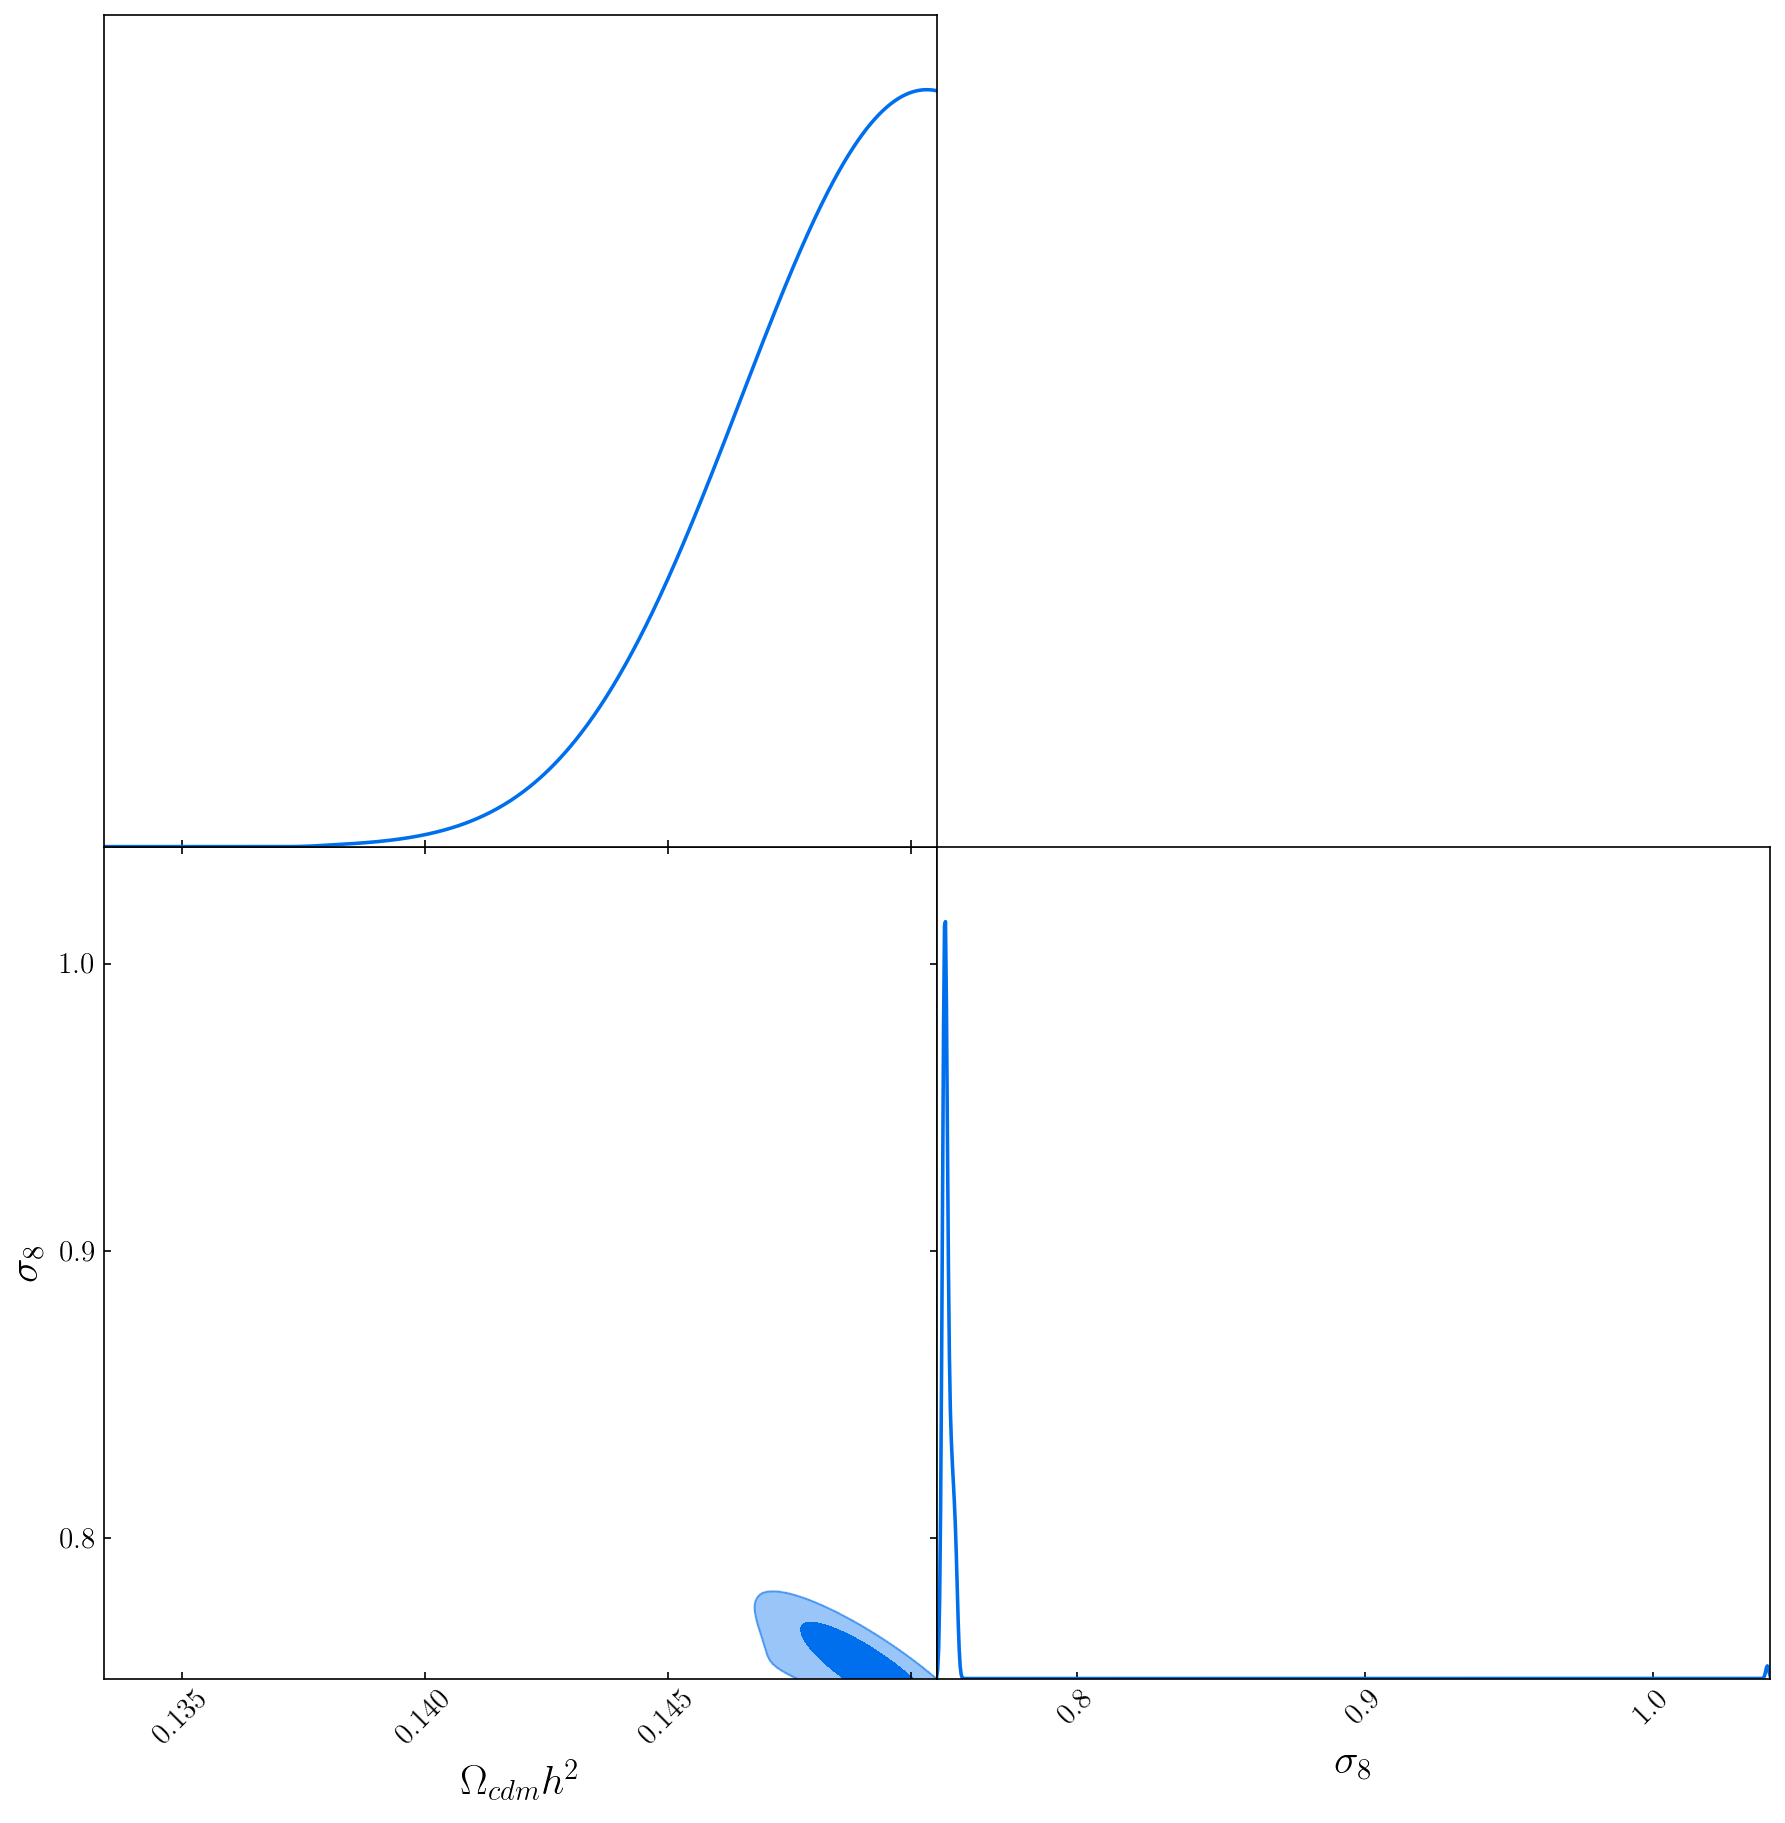

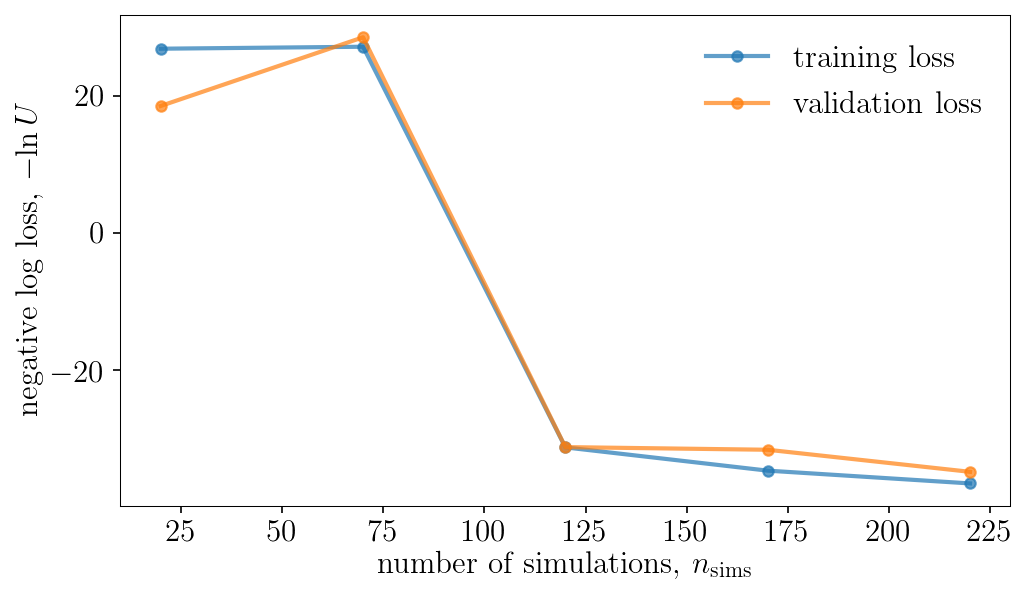

Population 7/20
Sampling proposal density...


/home/aizhana/.local/lib/python3.7/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in double_scalars
  lnpdiff = f + nlp - state.log_prob[j]


Done.


Sampling approximate posterior...


Done.
Removed no burn in


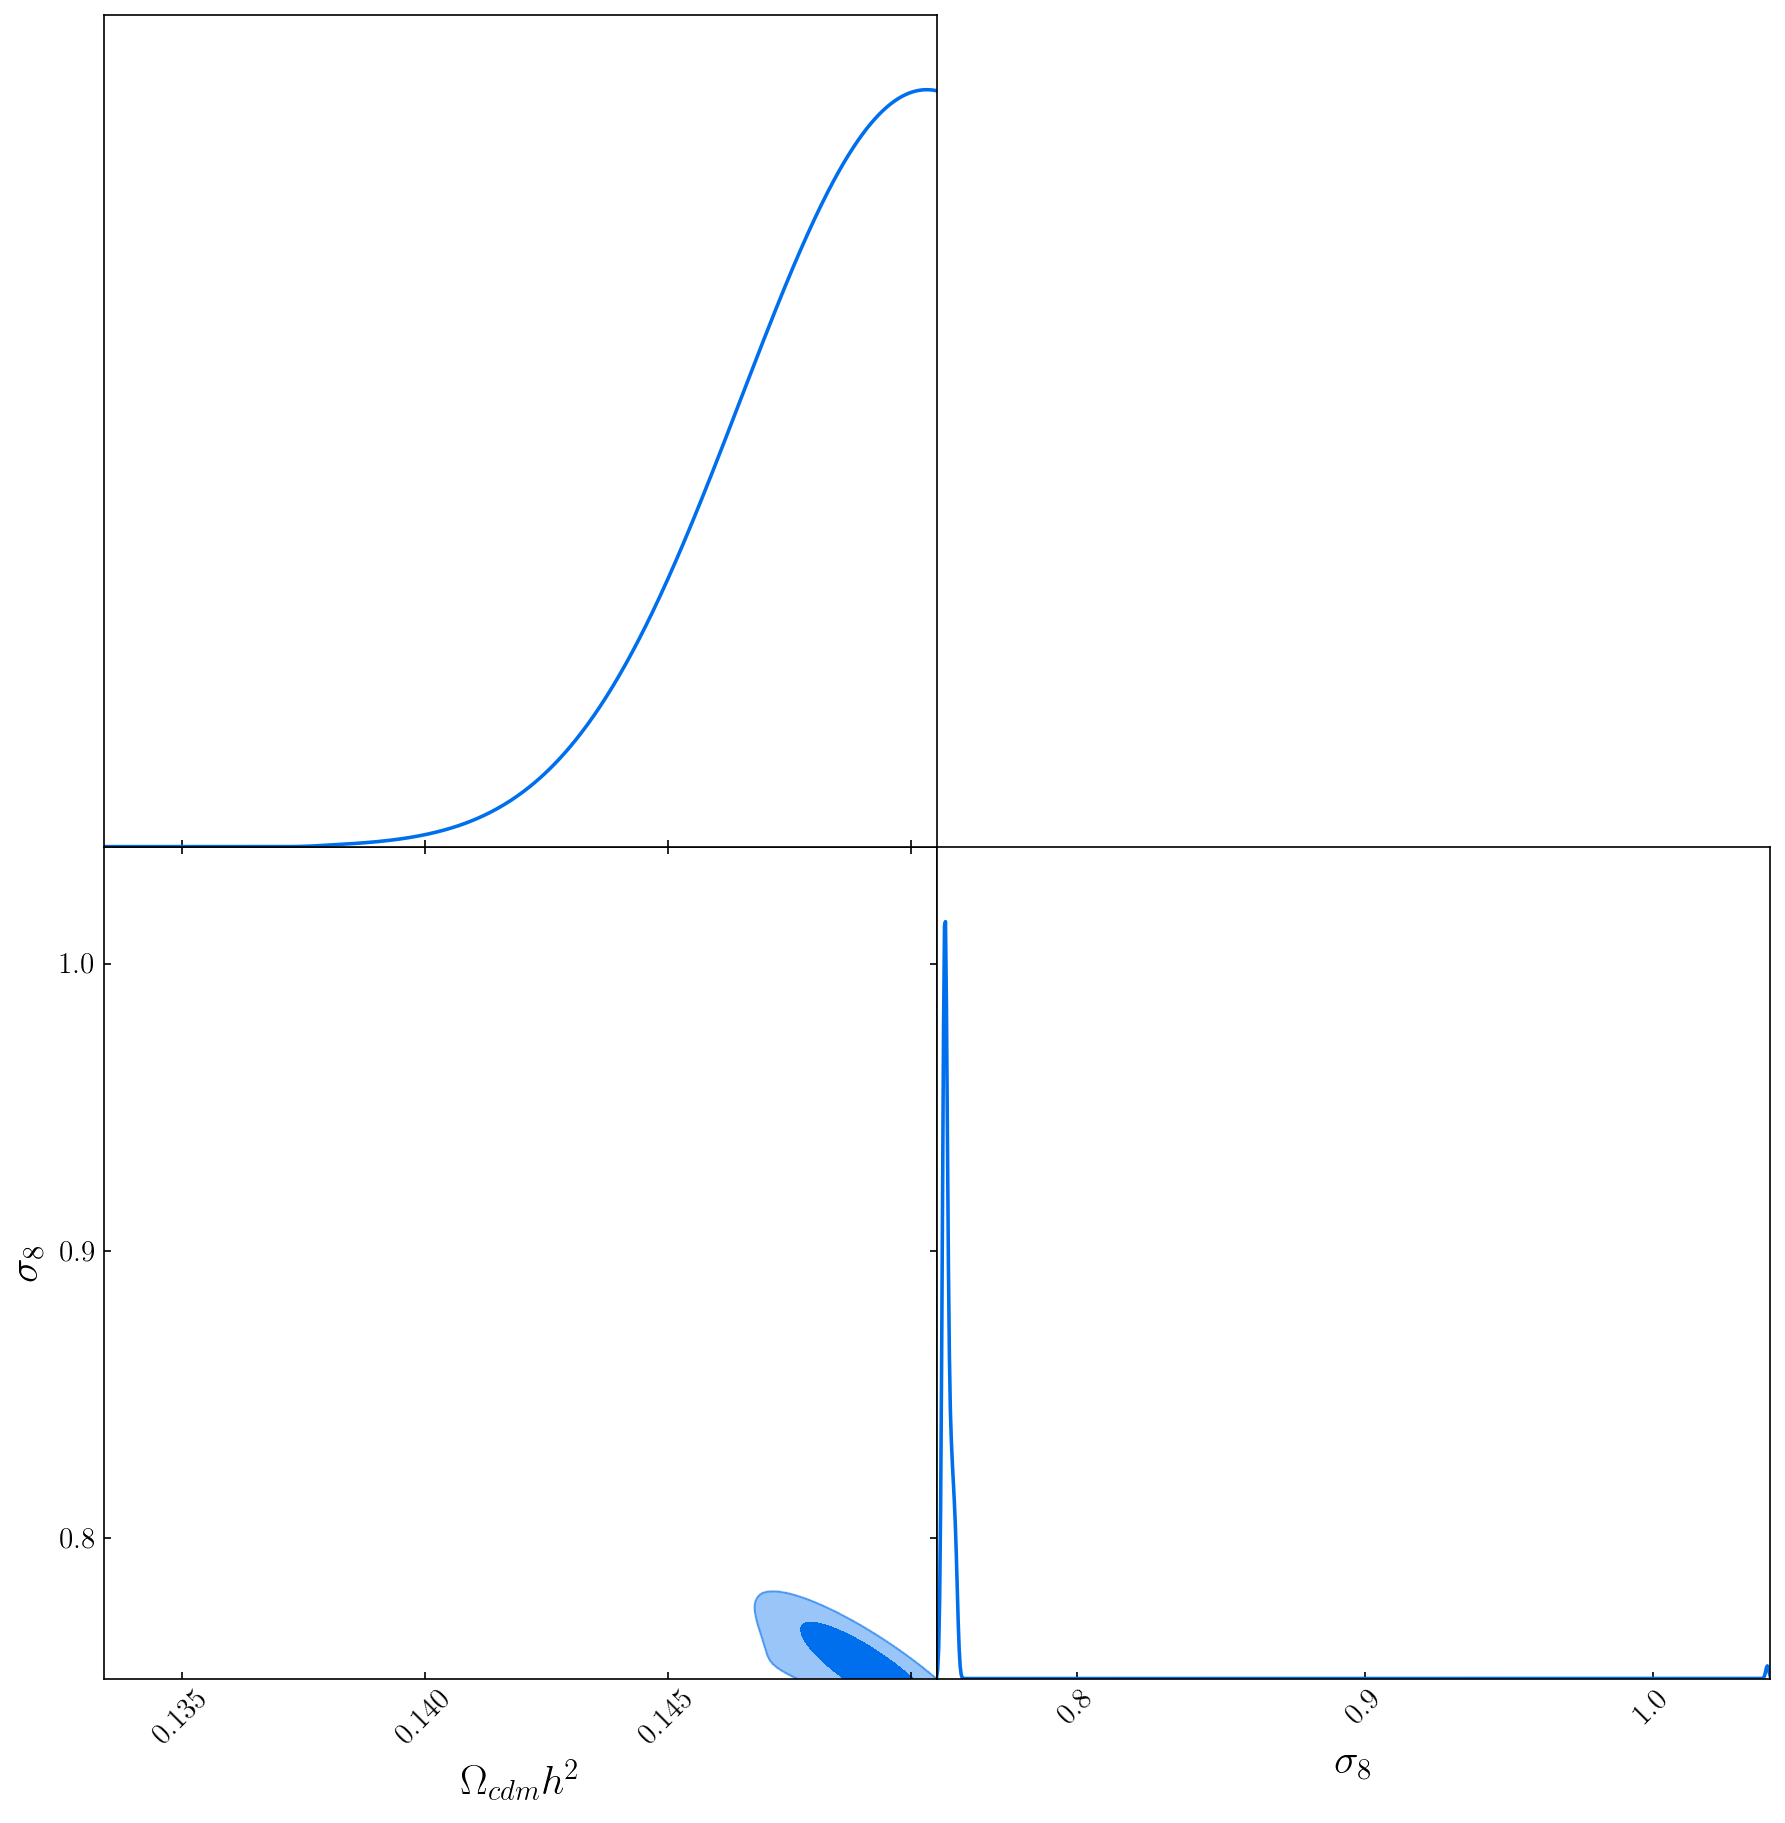

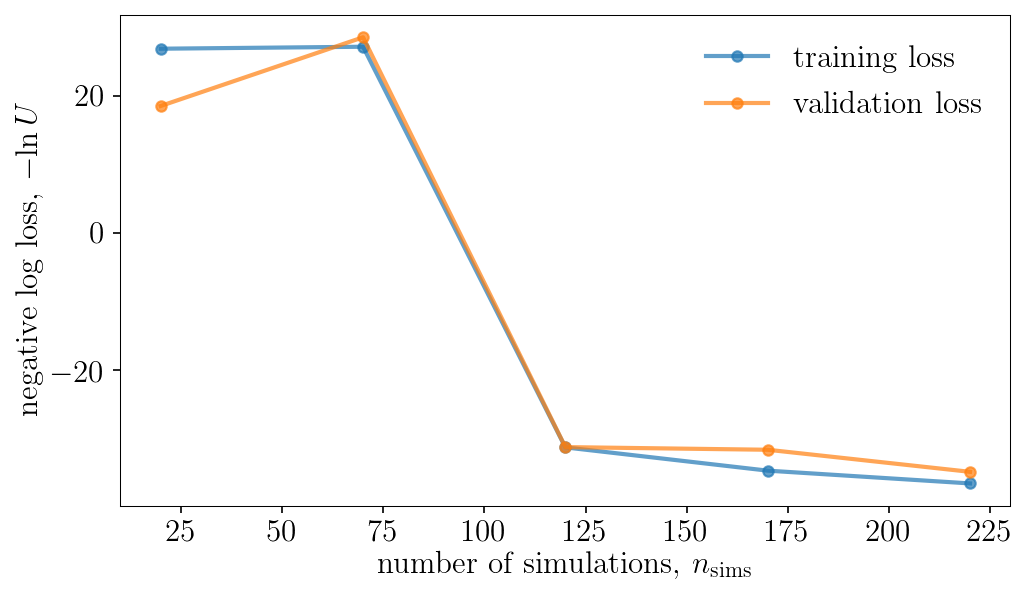

Population 8/20
Sampling proposal density...


/home/aizhana/.local/lib/python3.7/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in double_scalars
  lnpdiff = f + nlp - state.log_prob[j]


Done.


Sampling approximate posterior...


Done.
Removed no burn in


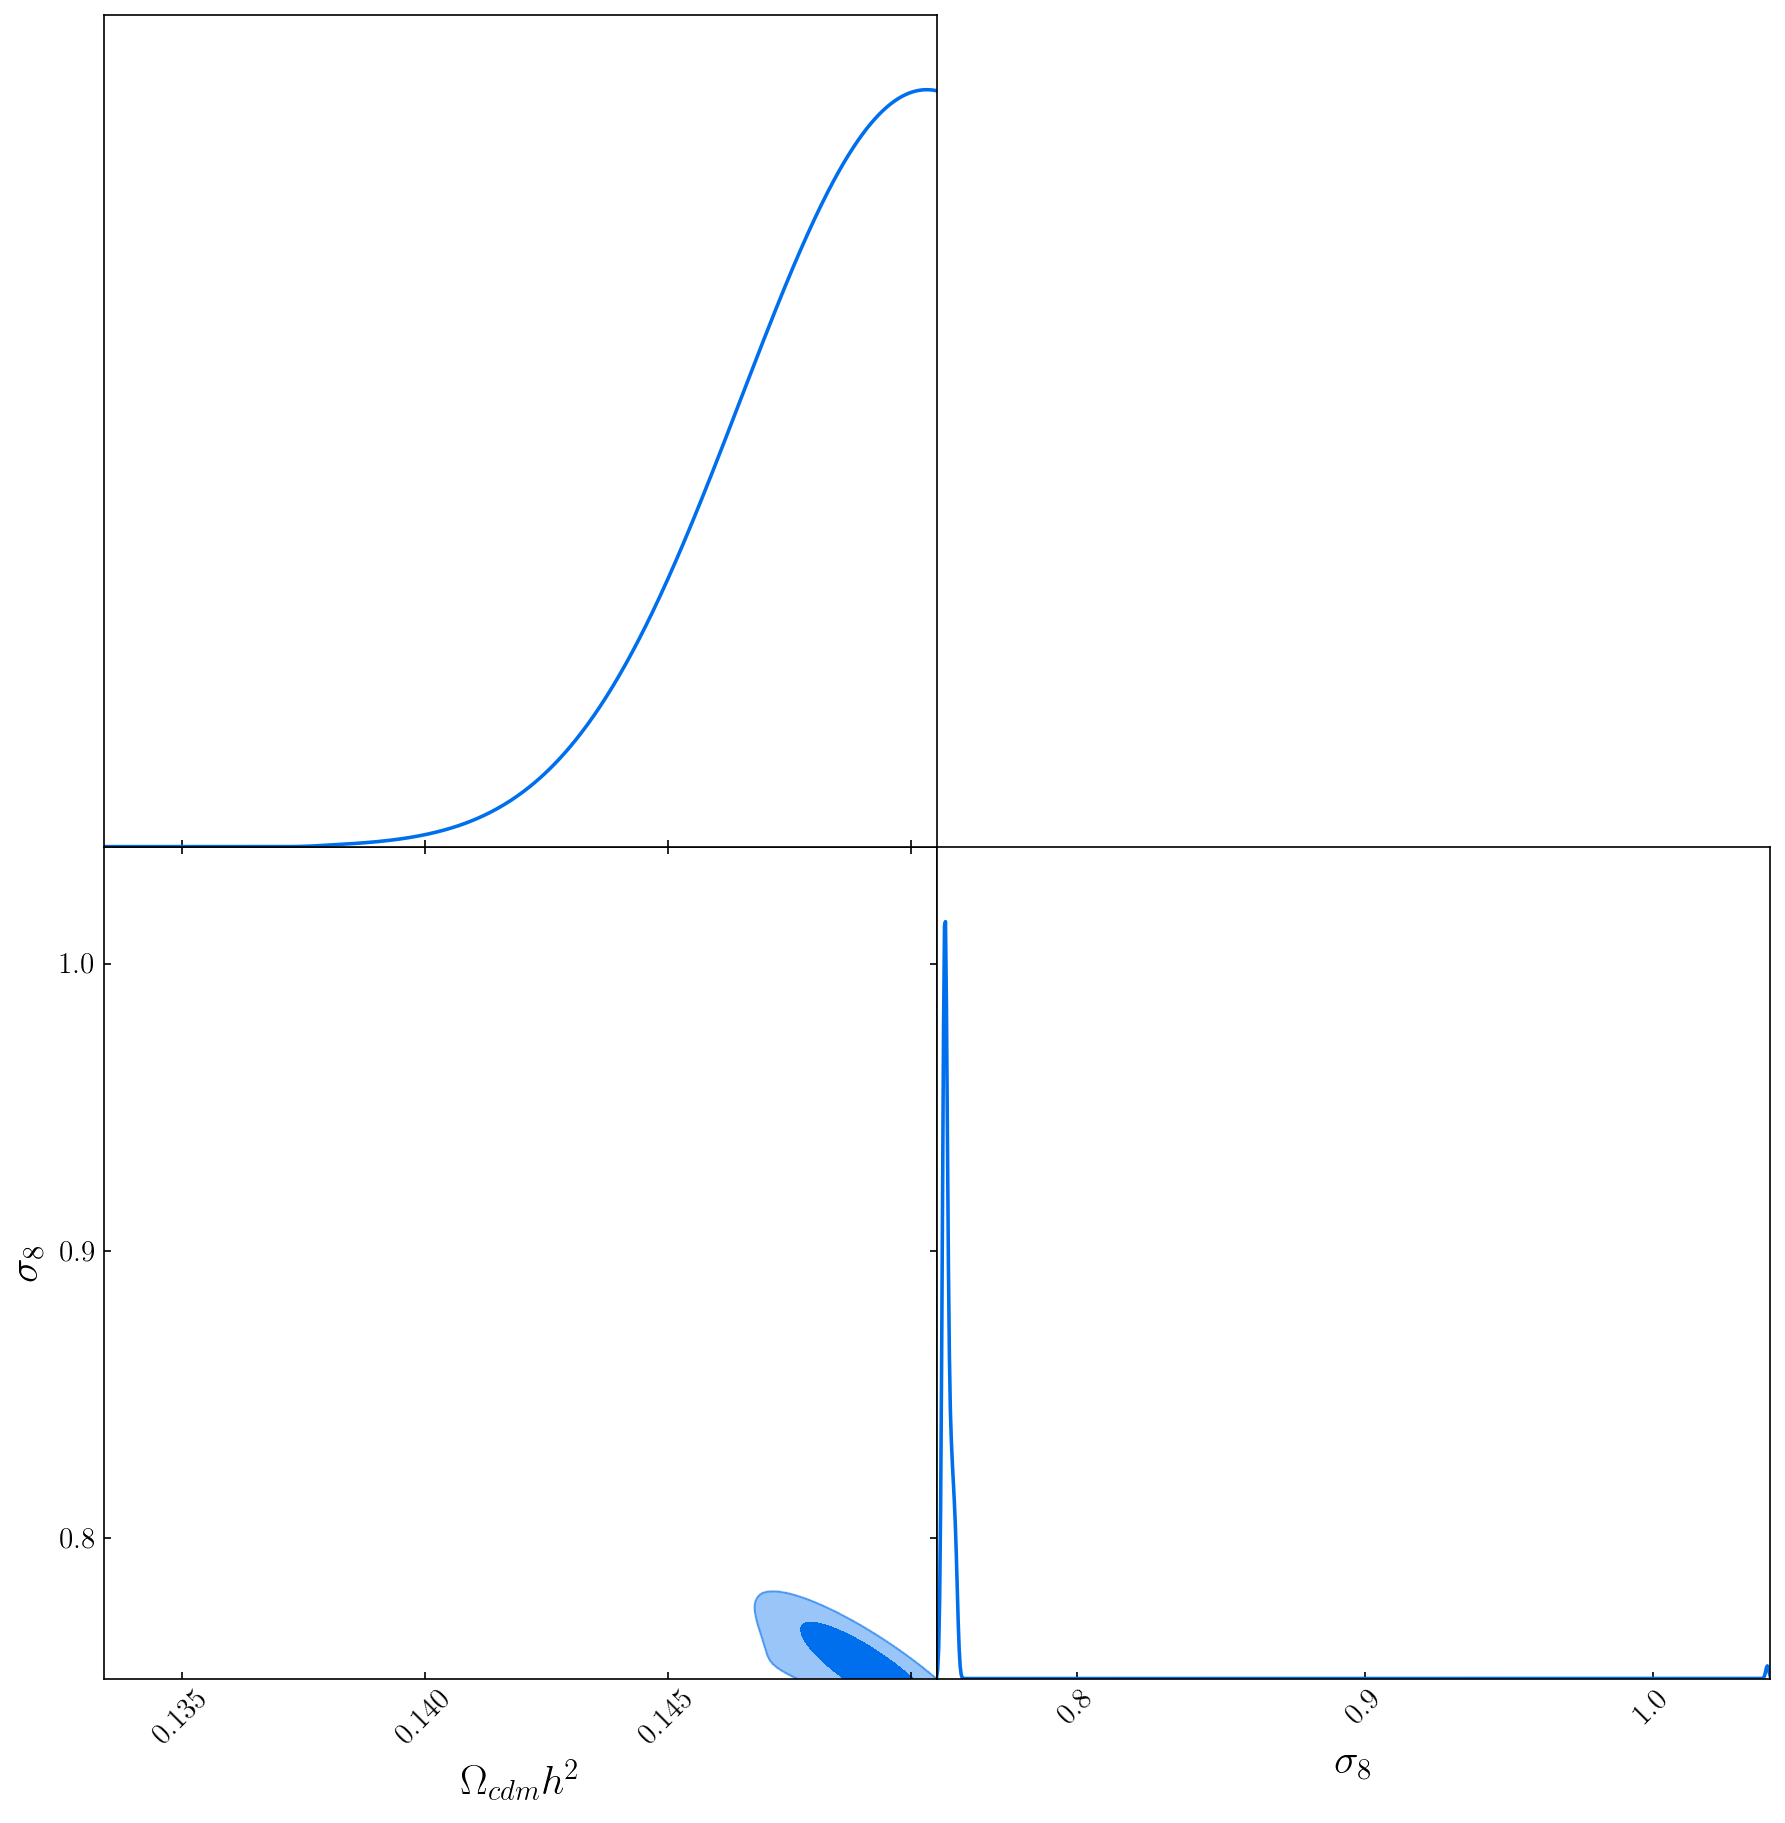

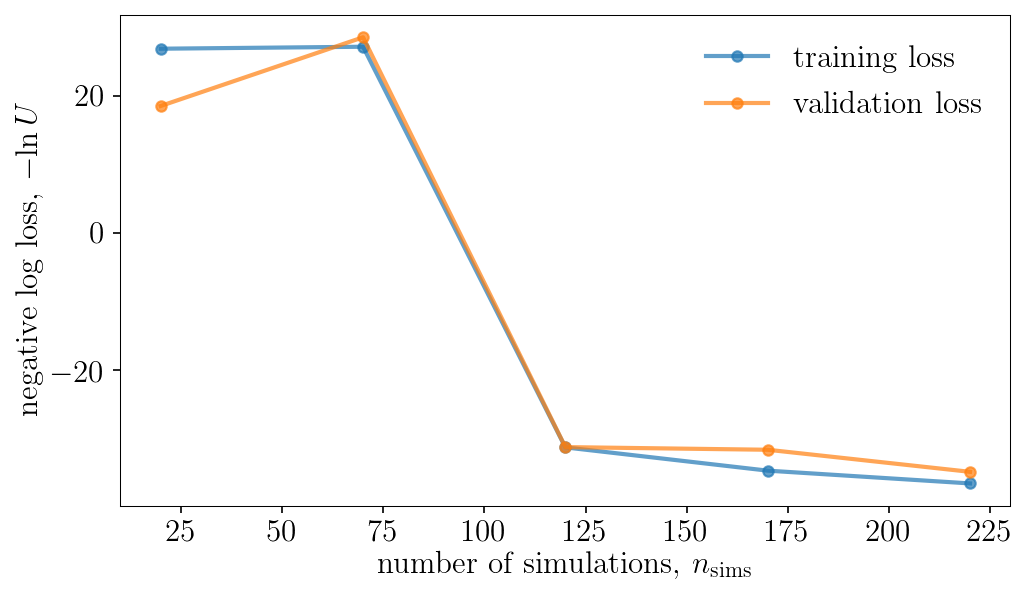

Population 9/20
Sampling proposal density...


/home/aizhana/.local/lib/python3.7/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in double_scalars
  lnpdiff = f + nlp - state.log_prob[j]


Done.


Sampling approximate posterior...


Done.
Removed no burn in


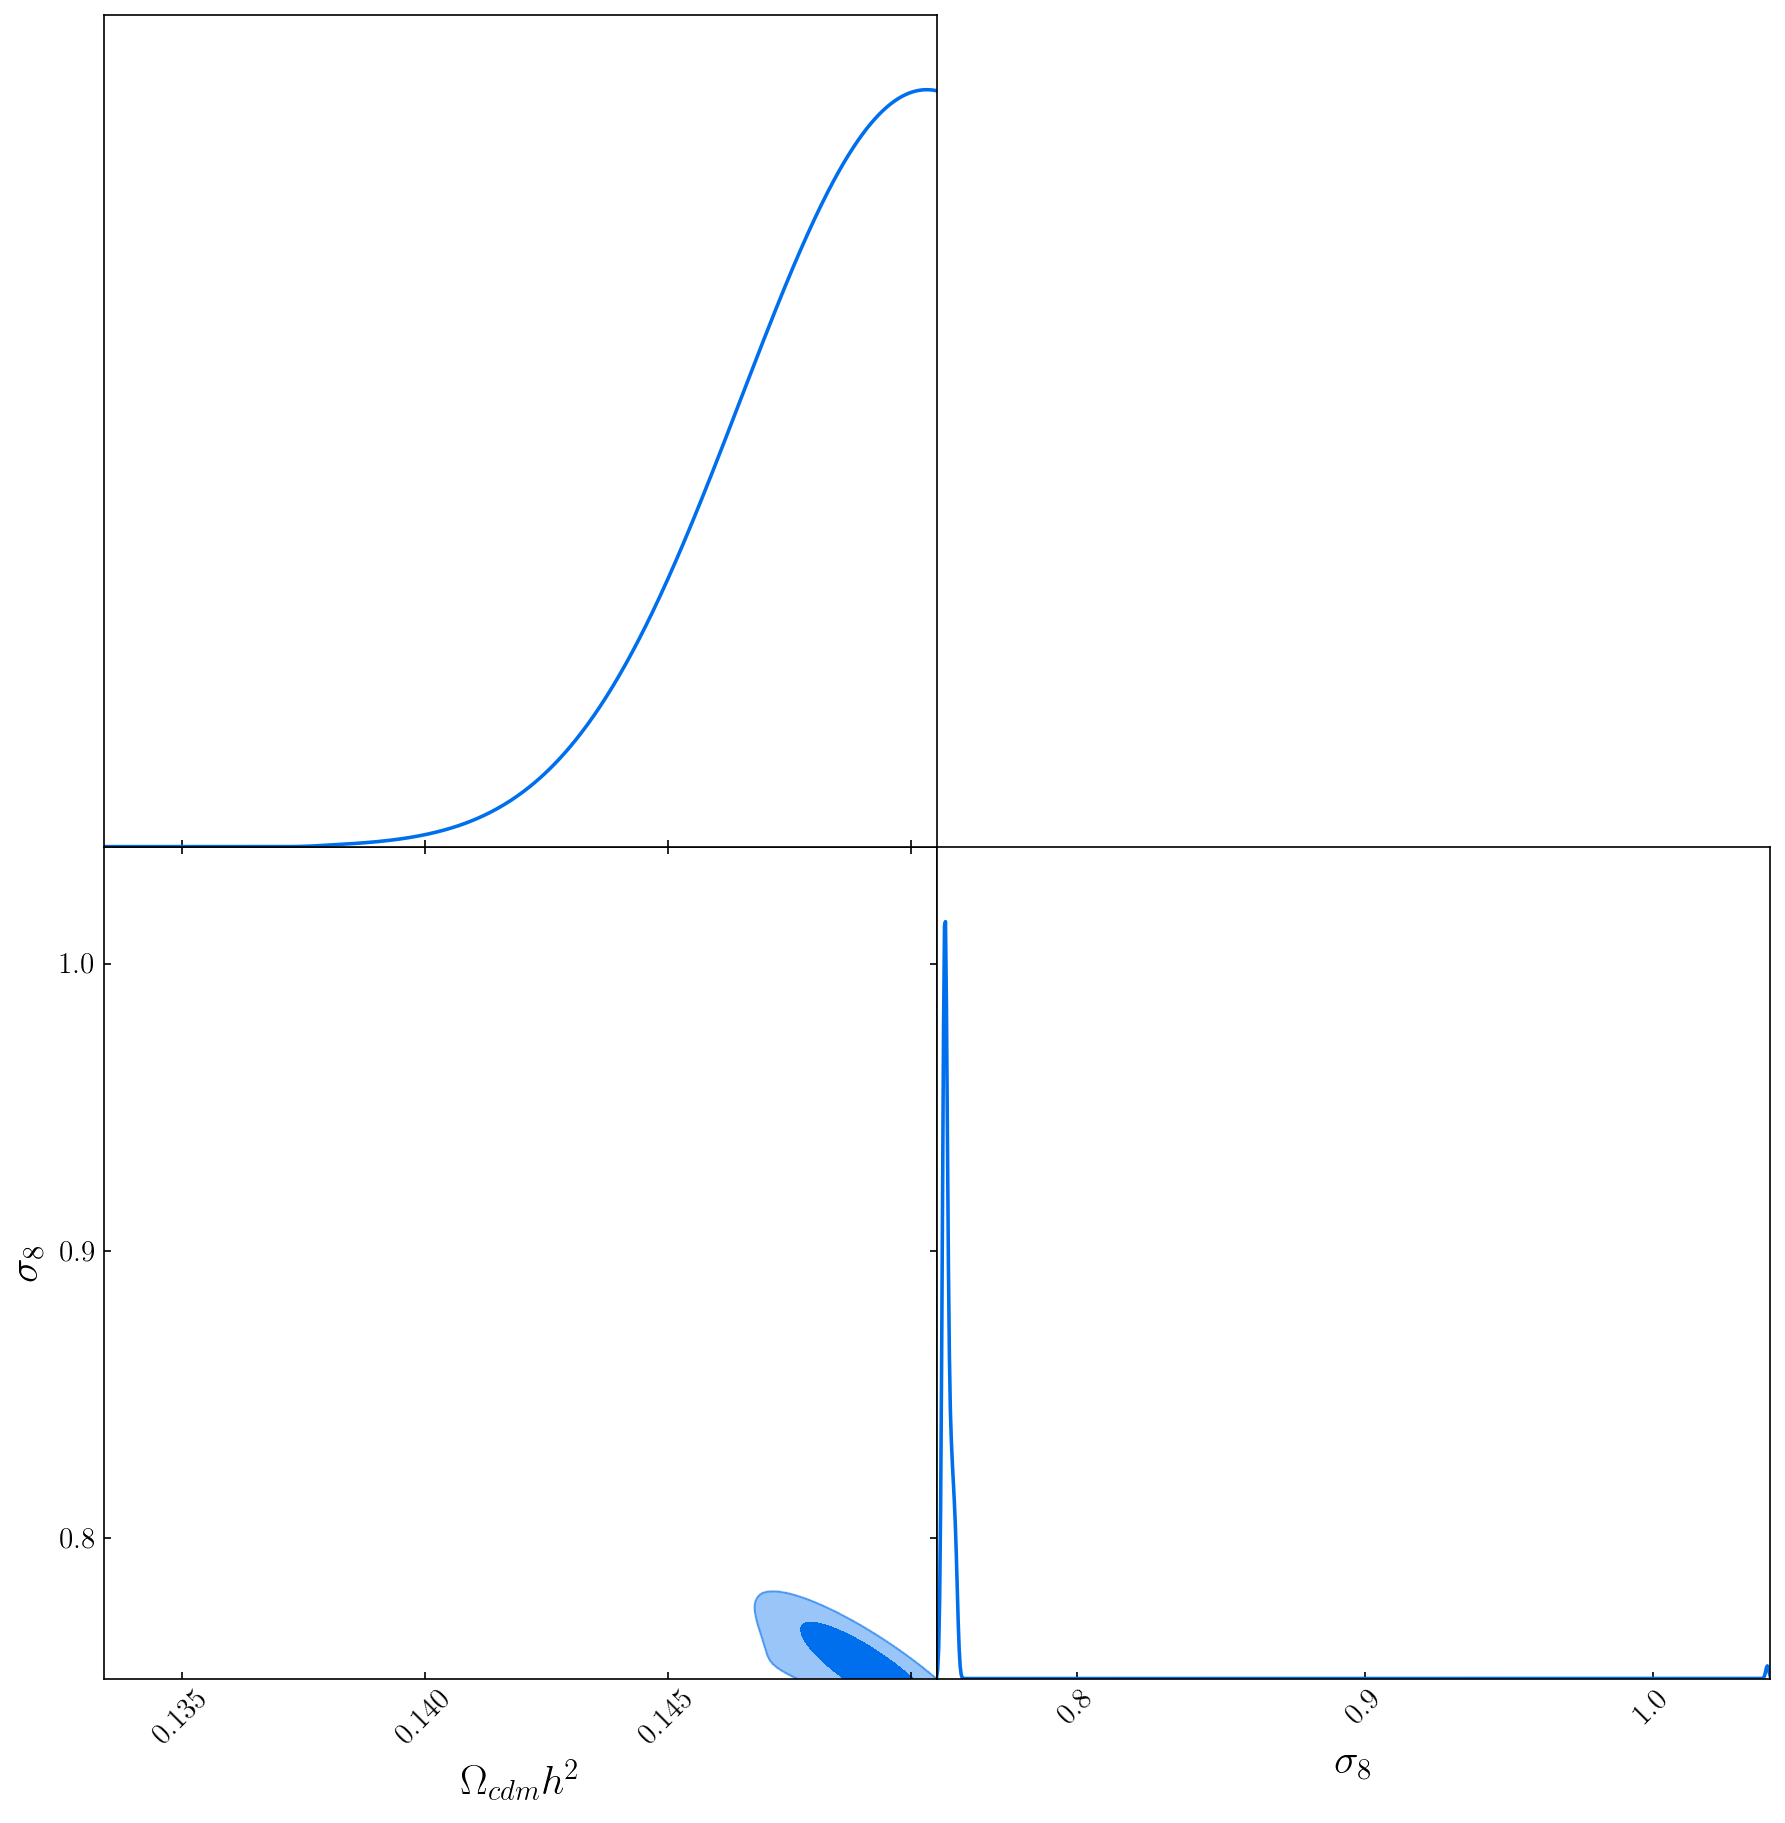

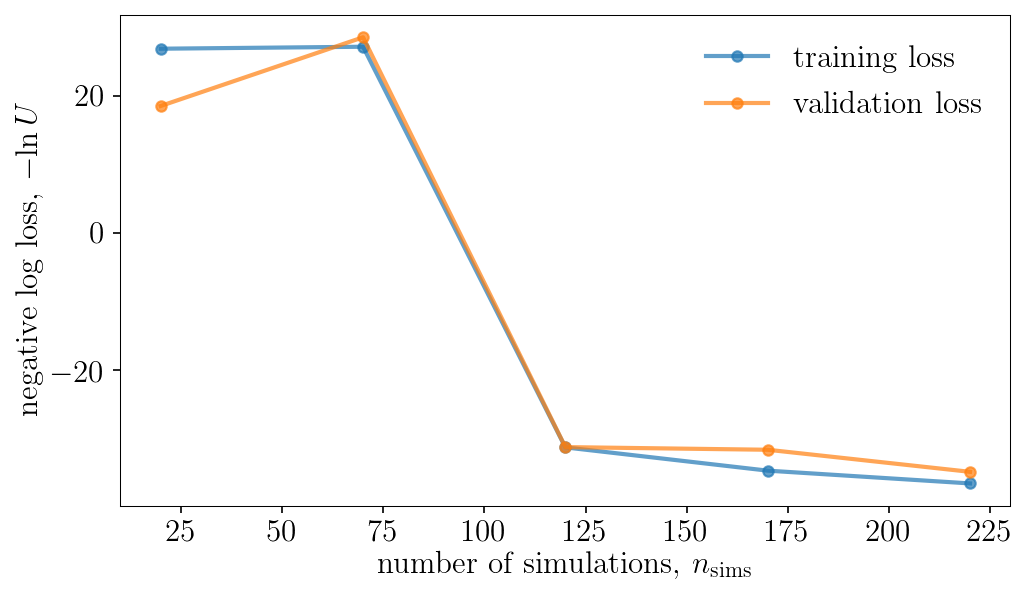

Population 10/20
Sampling proposal density...


/home/aizhana/.local/lib/python3.7/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in double_scalars
  lnpdiff = f + nlp - state.log_prob[j]


Done.


Sampling approximate posterior...


Done.
Removed no burn in


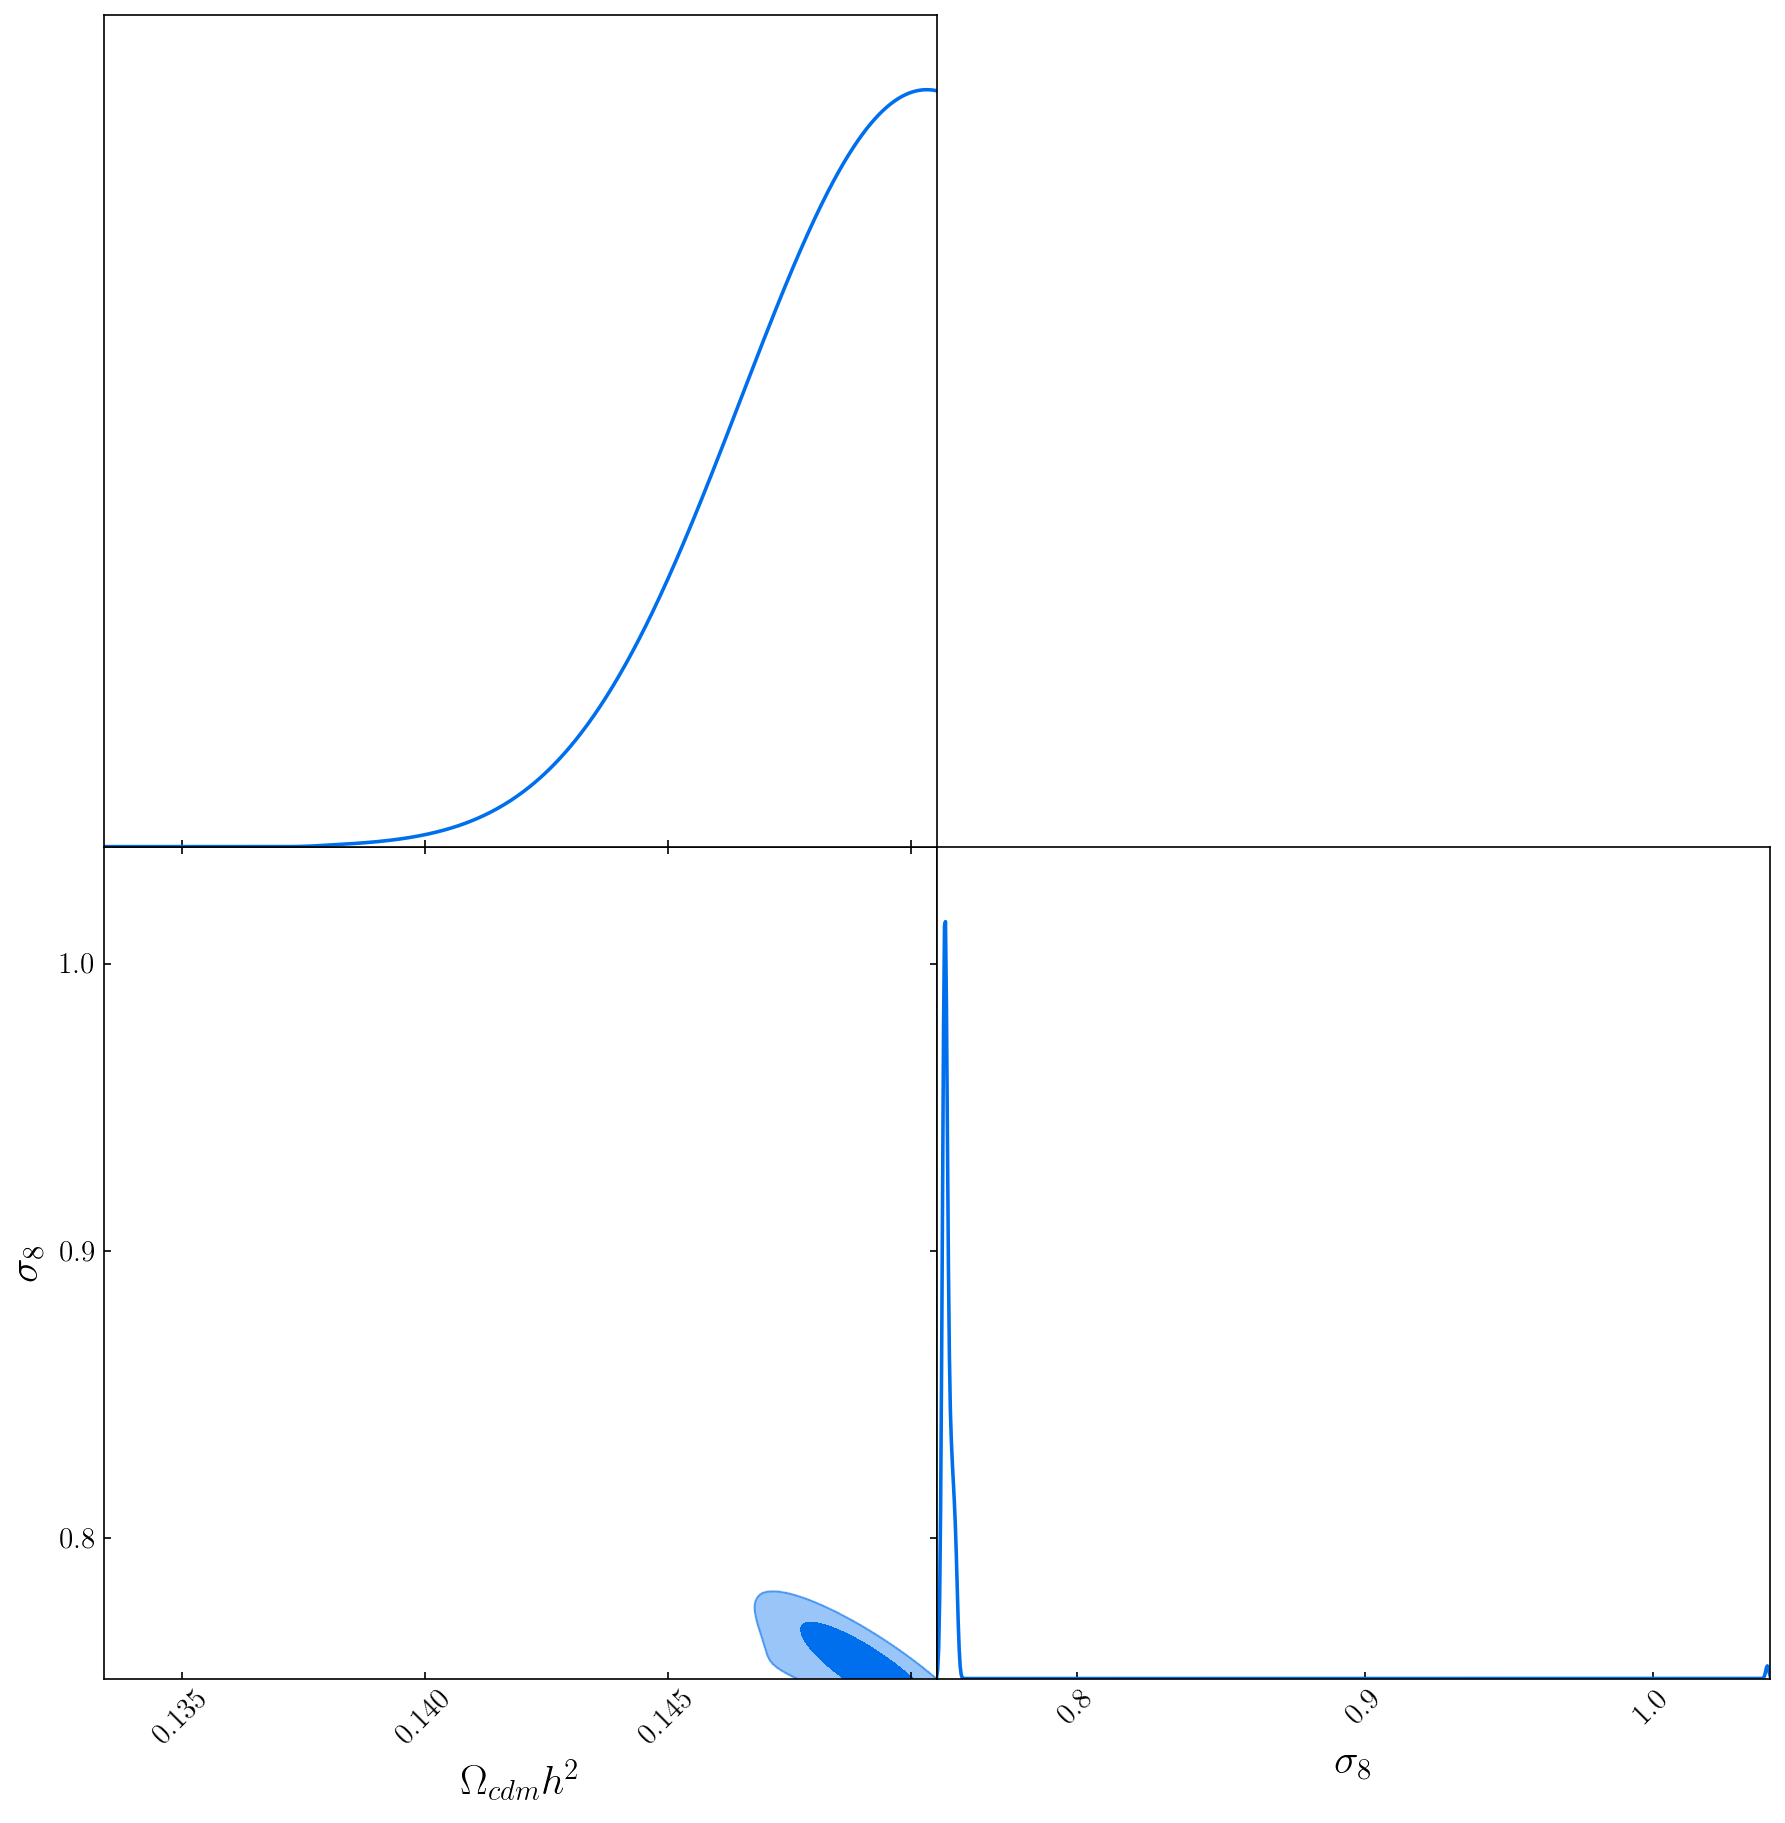

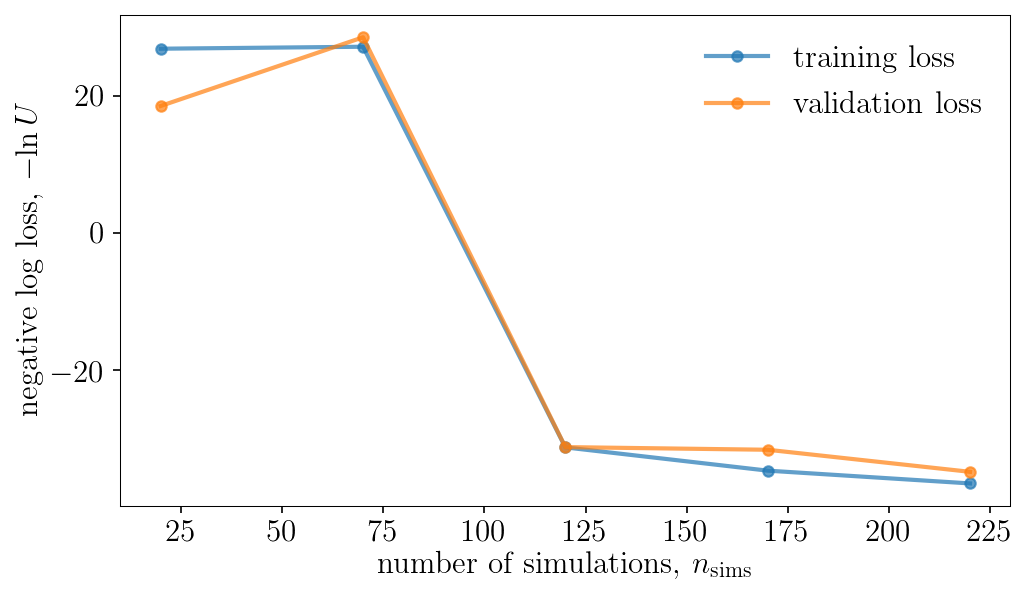

Population 11/20
Sampling proposal density...


/home/aizhana/.local/lib/python3.7/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in double_scalars
  lnpdiff = f + nlp - state.log_prob[j]


Done.


Sampling approximate posterior...


Done.
Removed no burn in


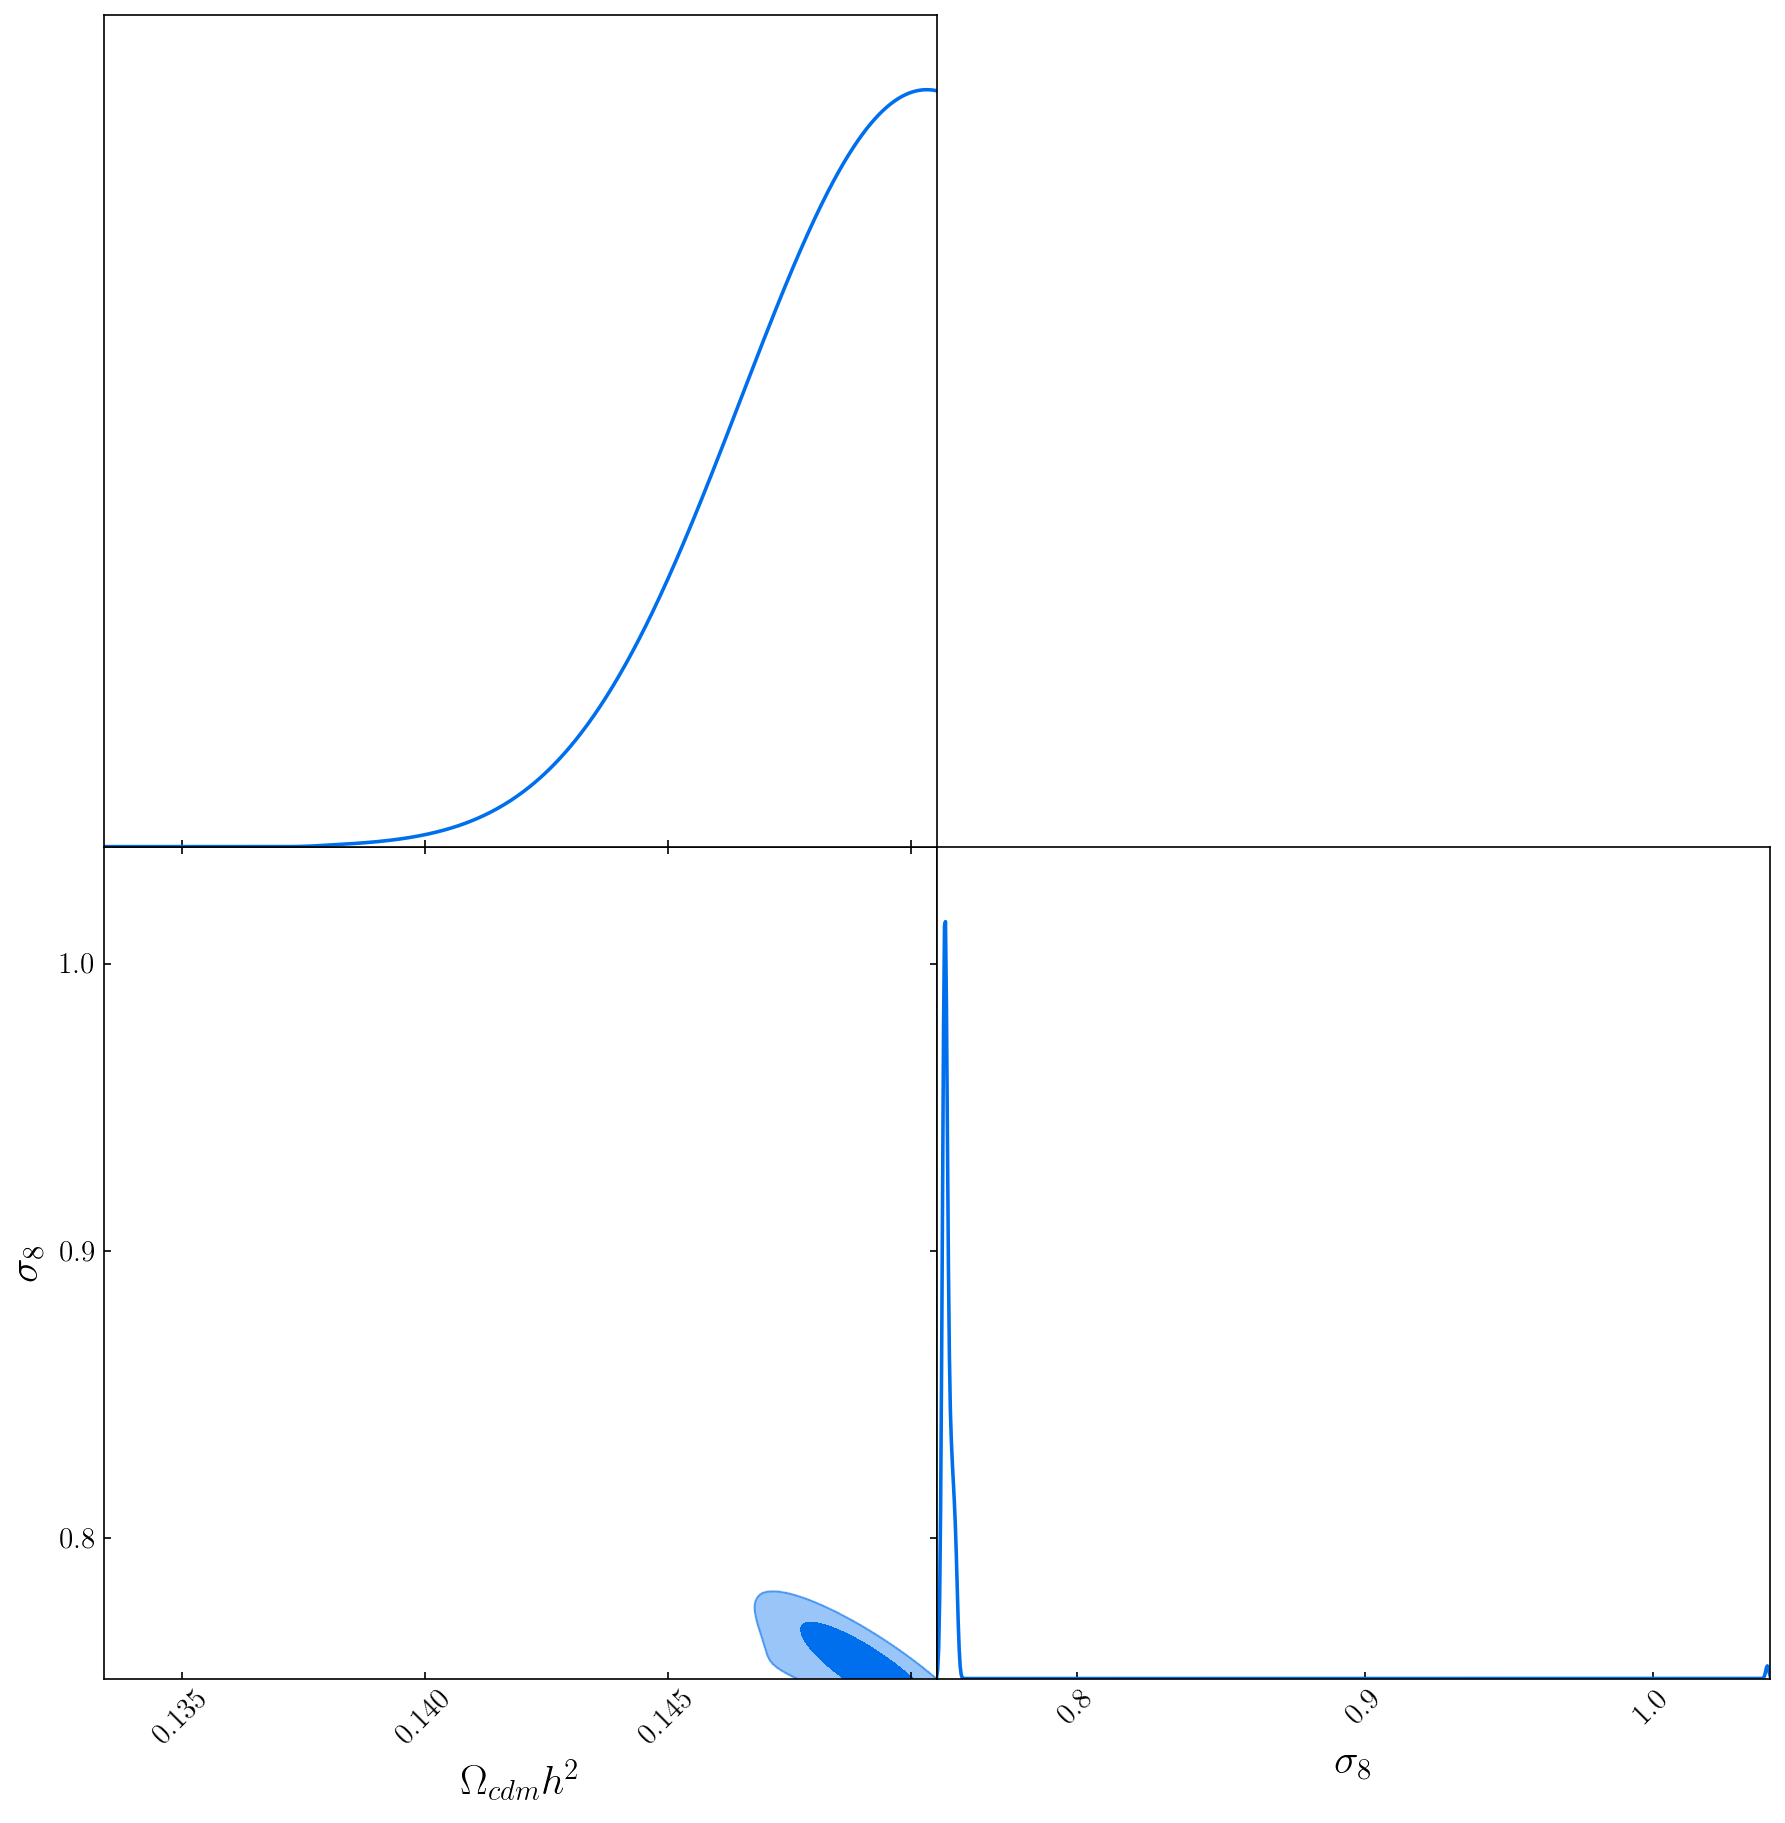

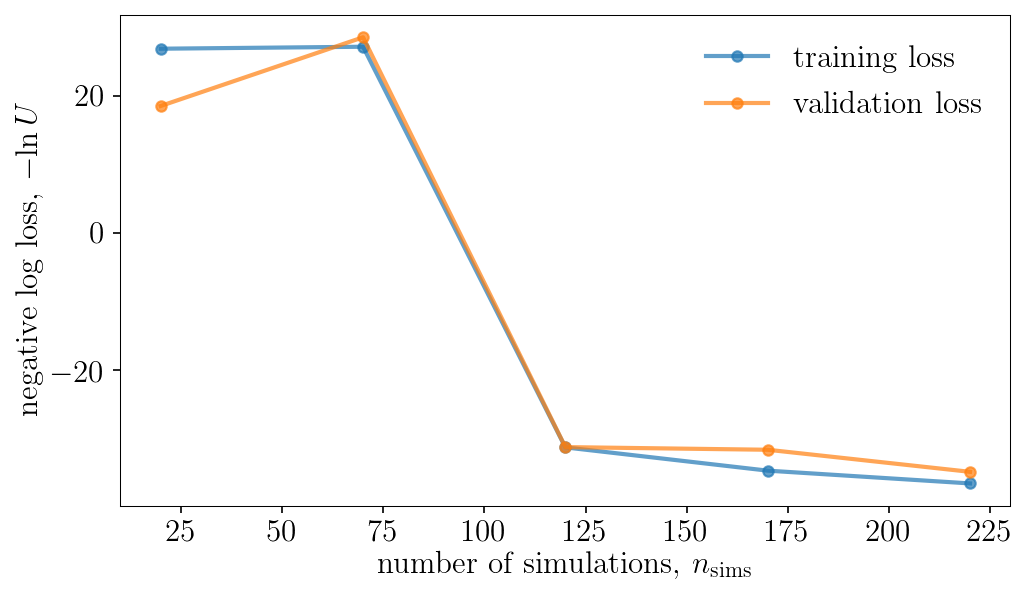

Population 12/20
Sampling proposal density...


/home/aizhana/.local/lib/python3.7/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in double_scalars
  lnpdiff = f + nlp - state.log_prob[j]


Done.


Sampling approximate posterior...


Done.
Removed no burn in


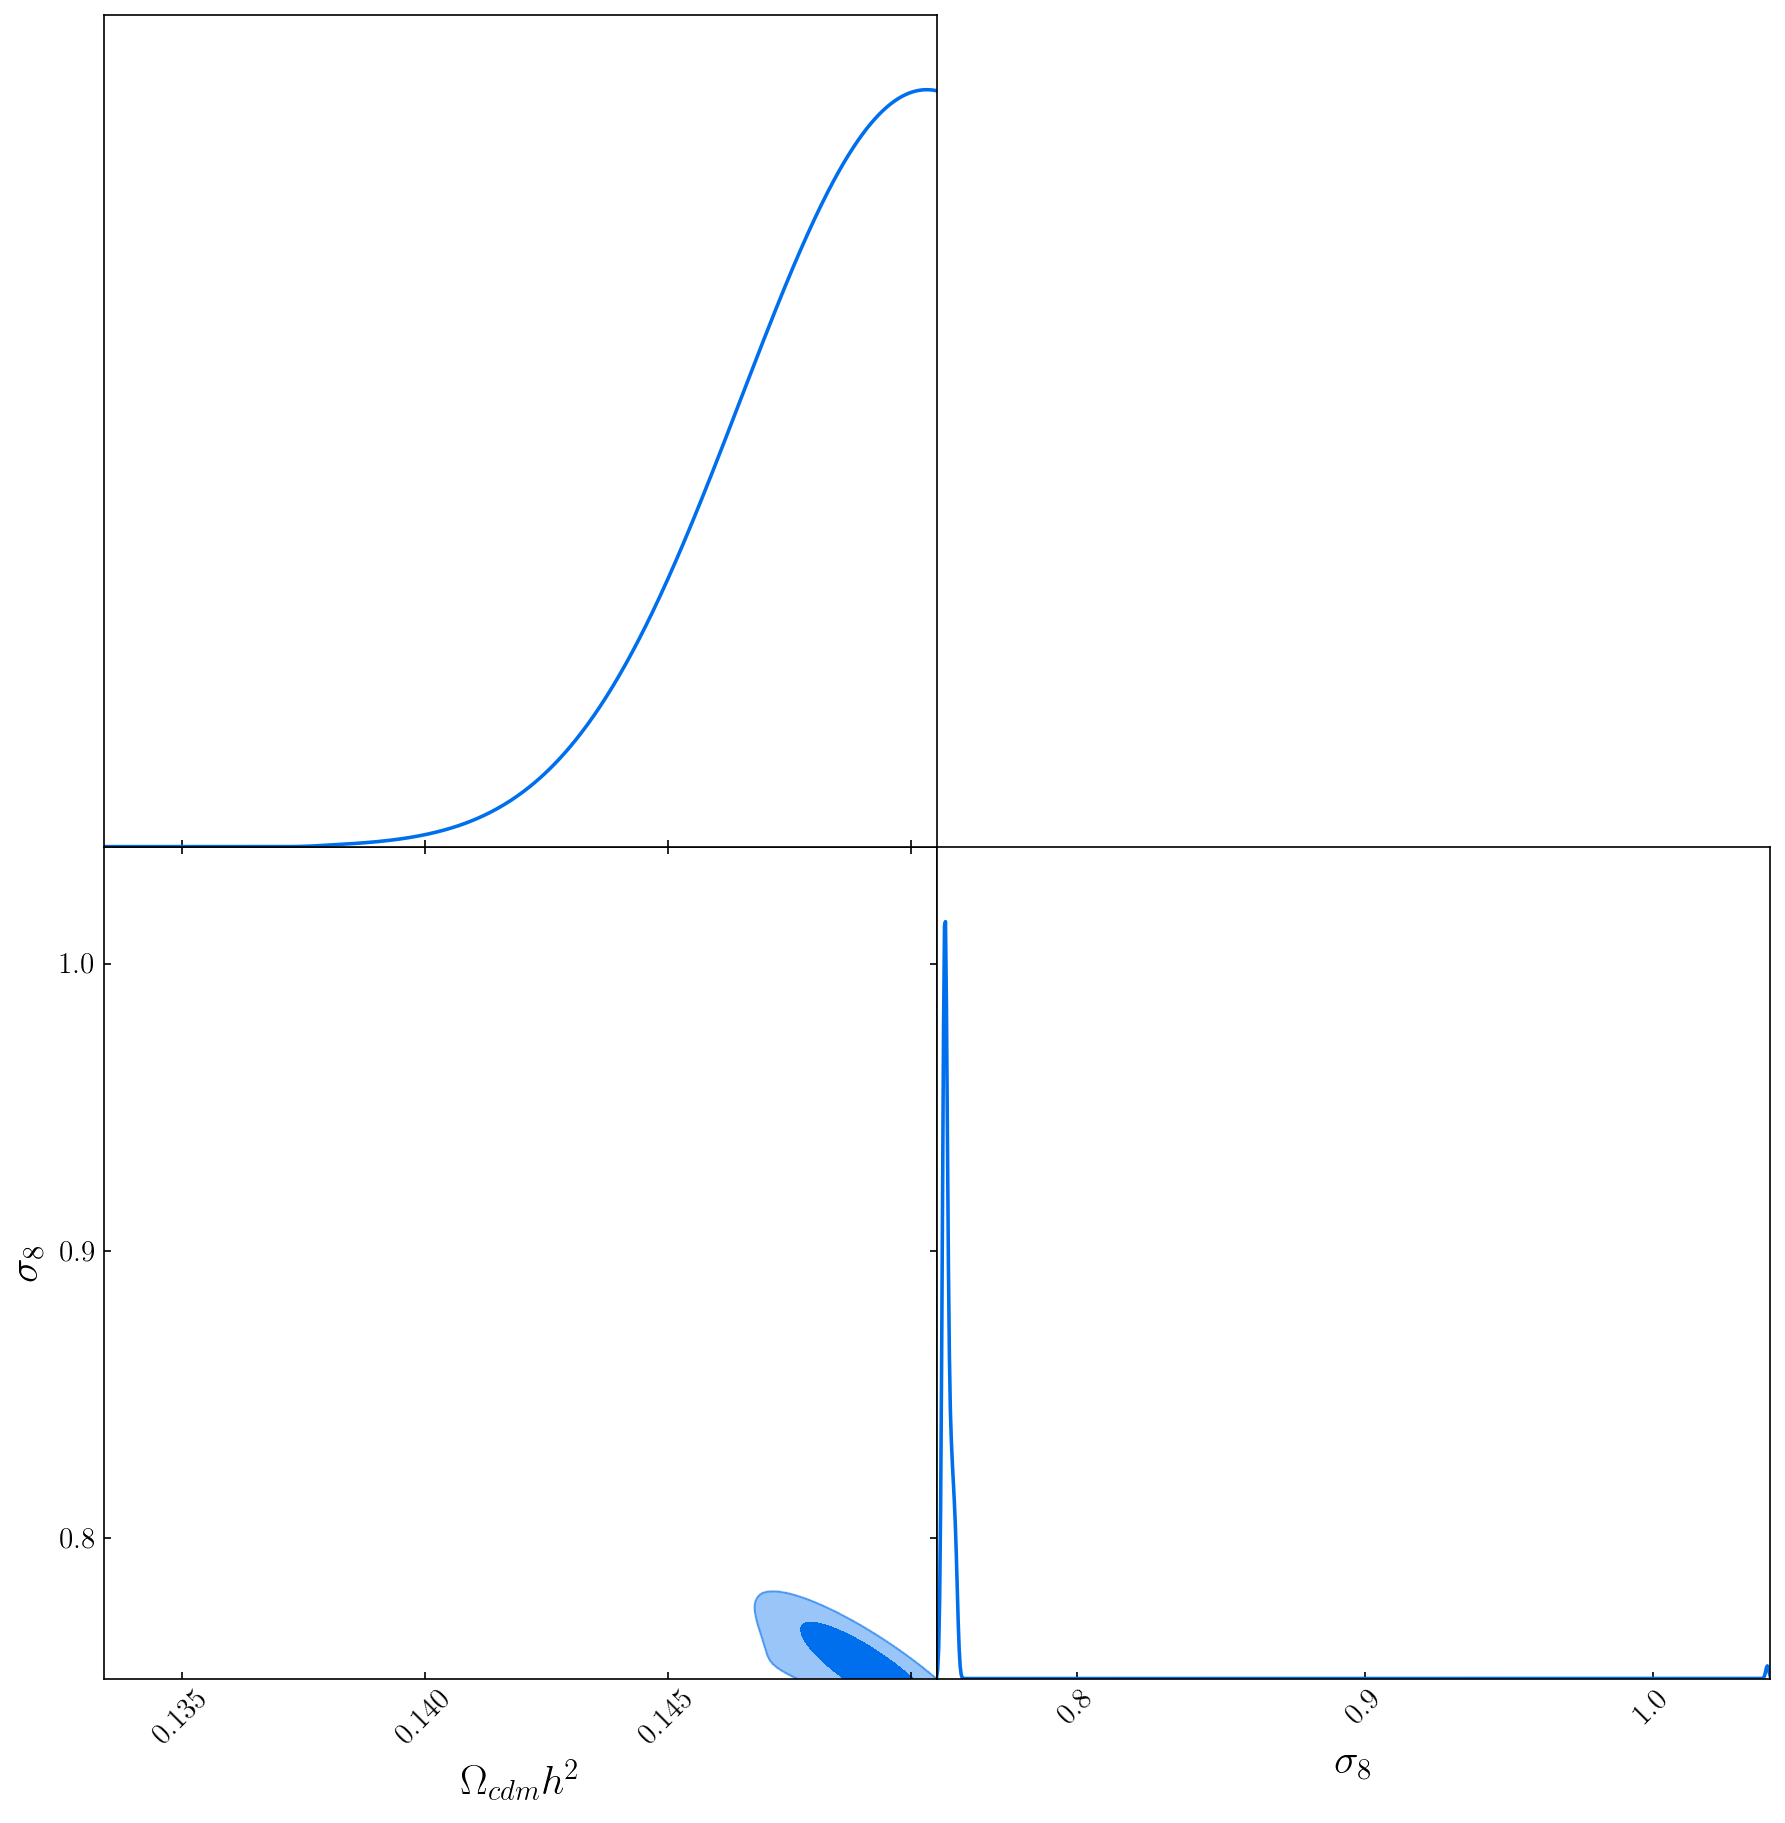

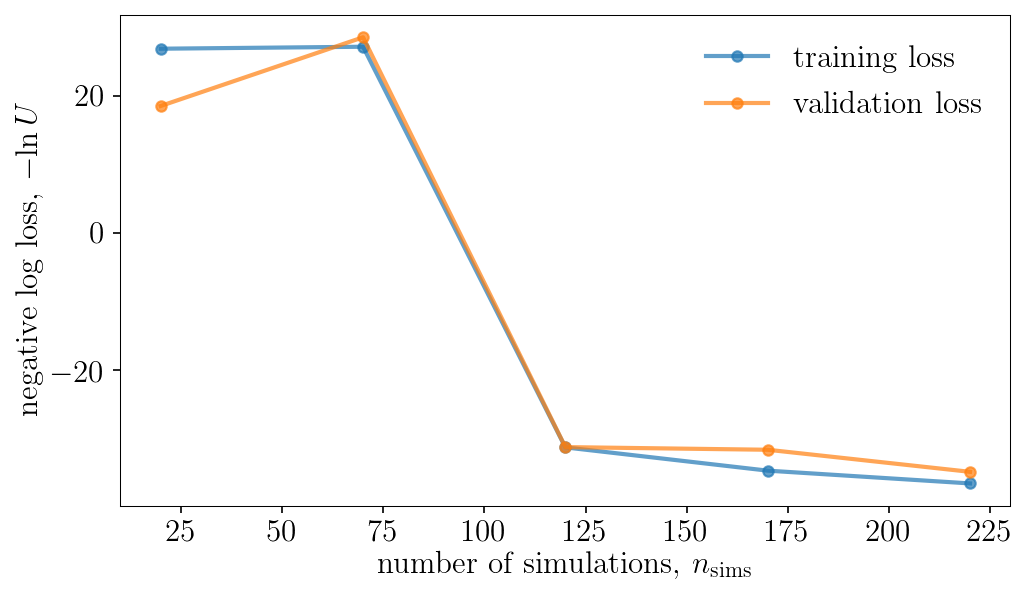

Population 13/20
Sampling proposal density...


/home/aizhana/.local/lib/python3.7/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in double_scalars
  lnpdiff = f + nlp - state.log_prob[j]


Done.


Sampling approximate posterior...


Done.
Removed no burn in


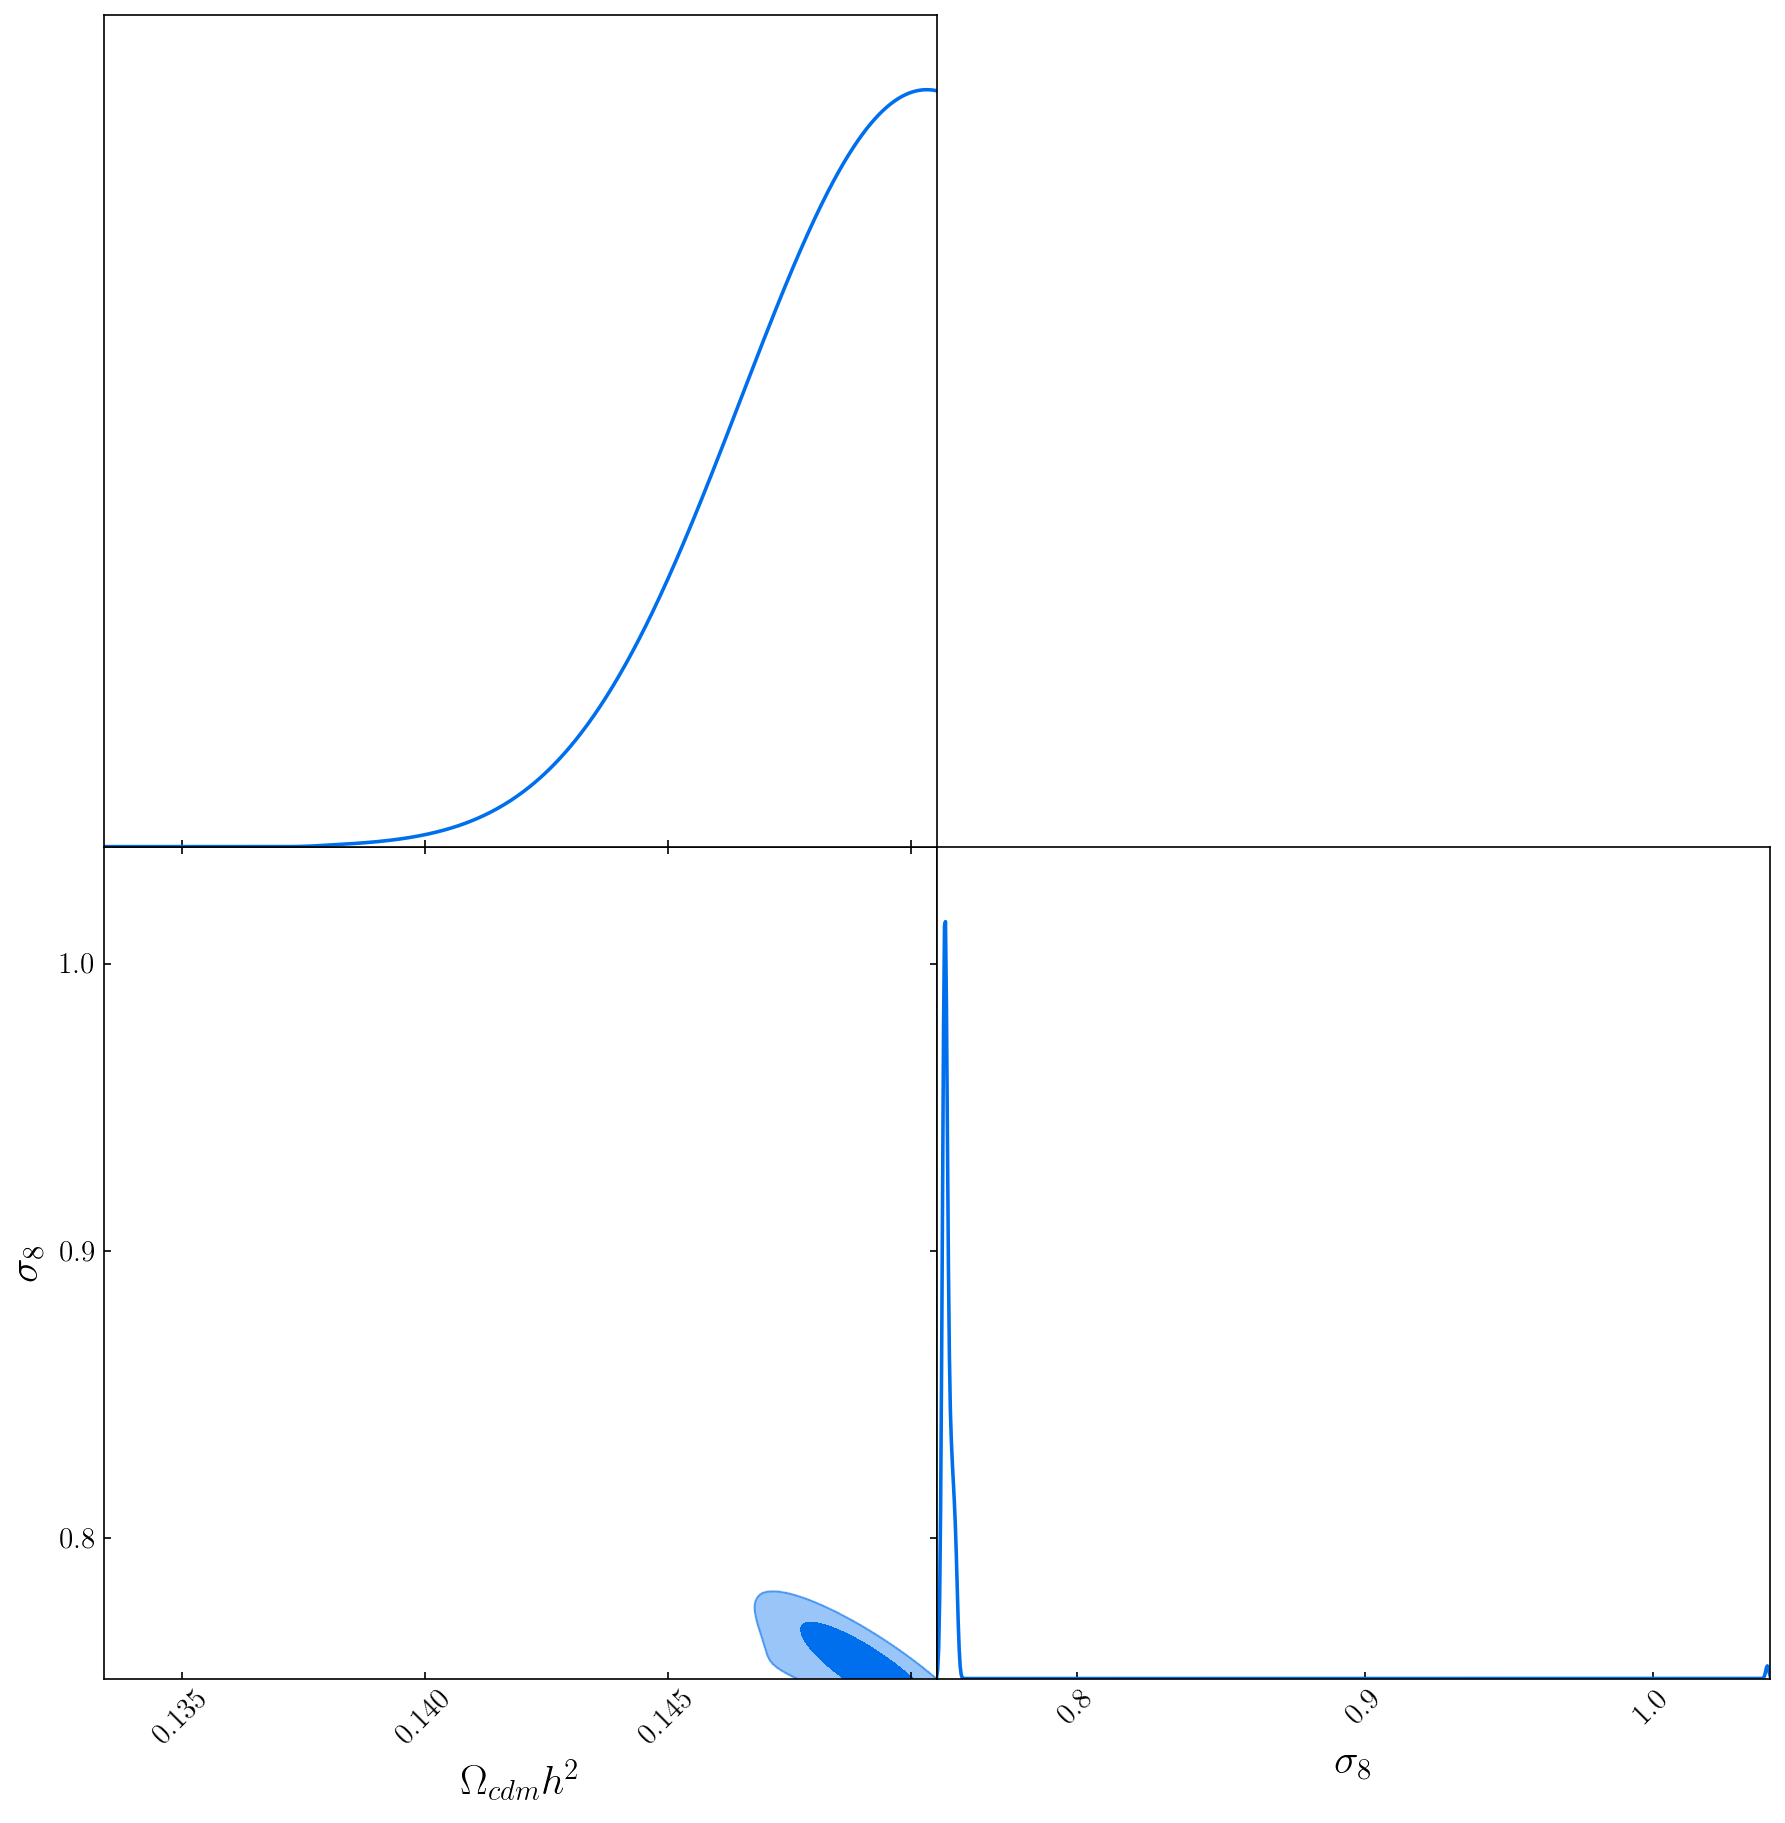

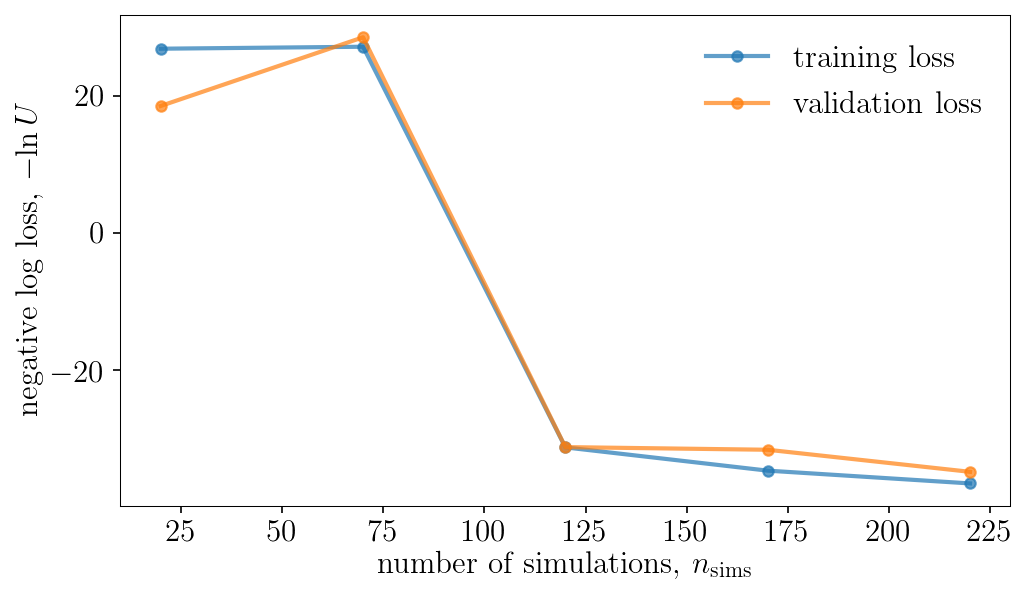

Population 14/20
Sampling proposal density...


/home/aizhana/.local/lib/python3.7/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in double_scalars
  lnpdiff = f + nlp - state.log_prob[j]


Done.


Sampling approximate posterior...


Done.
Removed no burn in


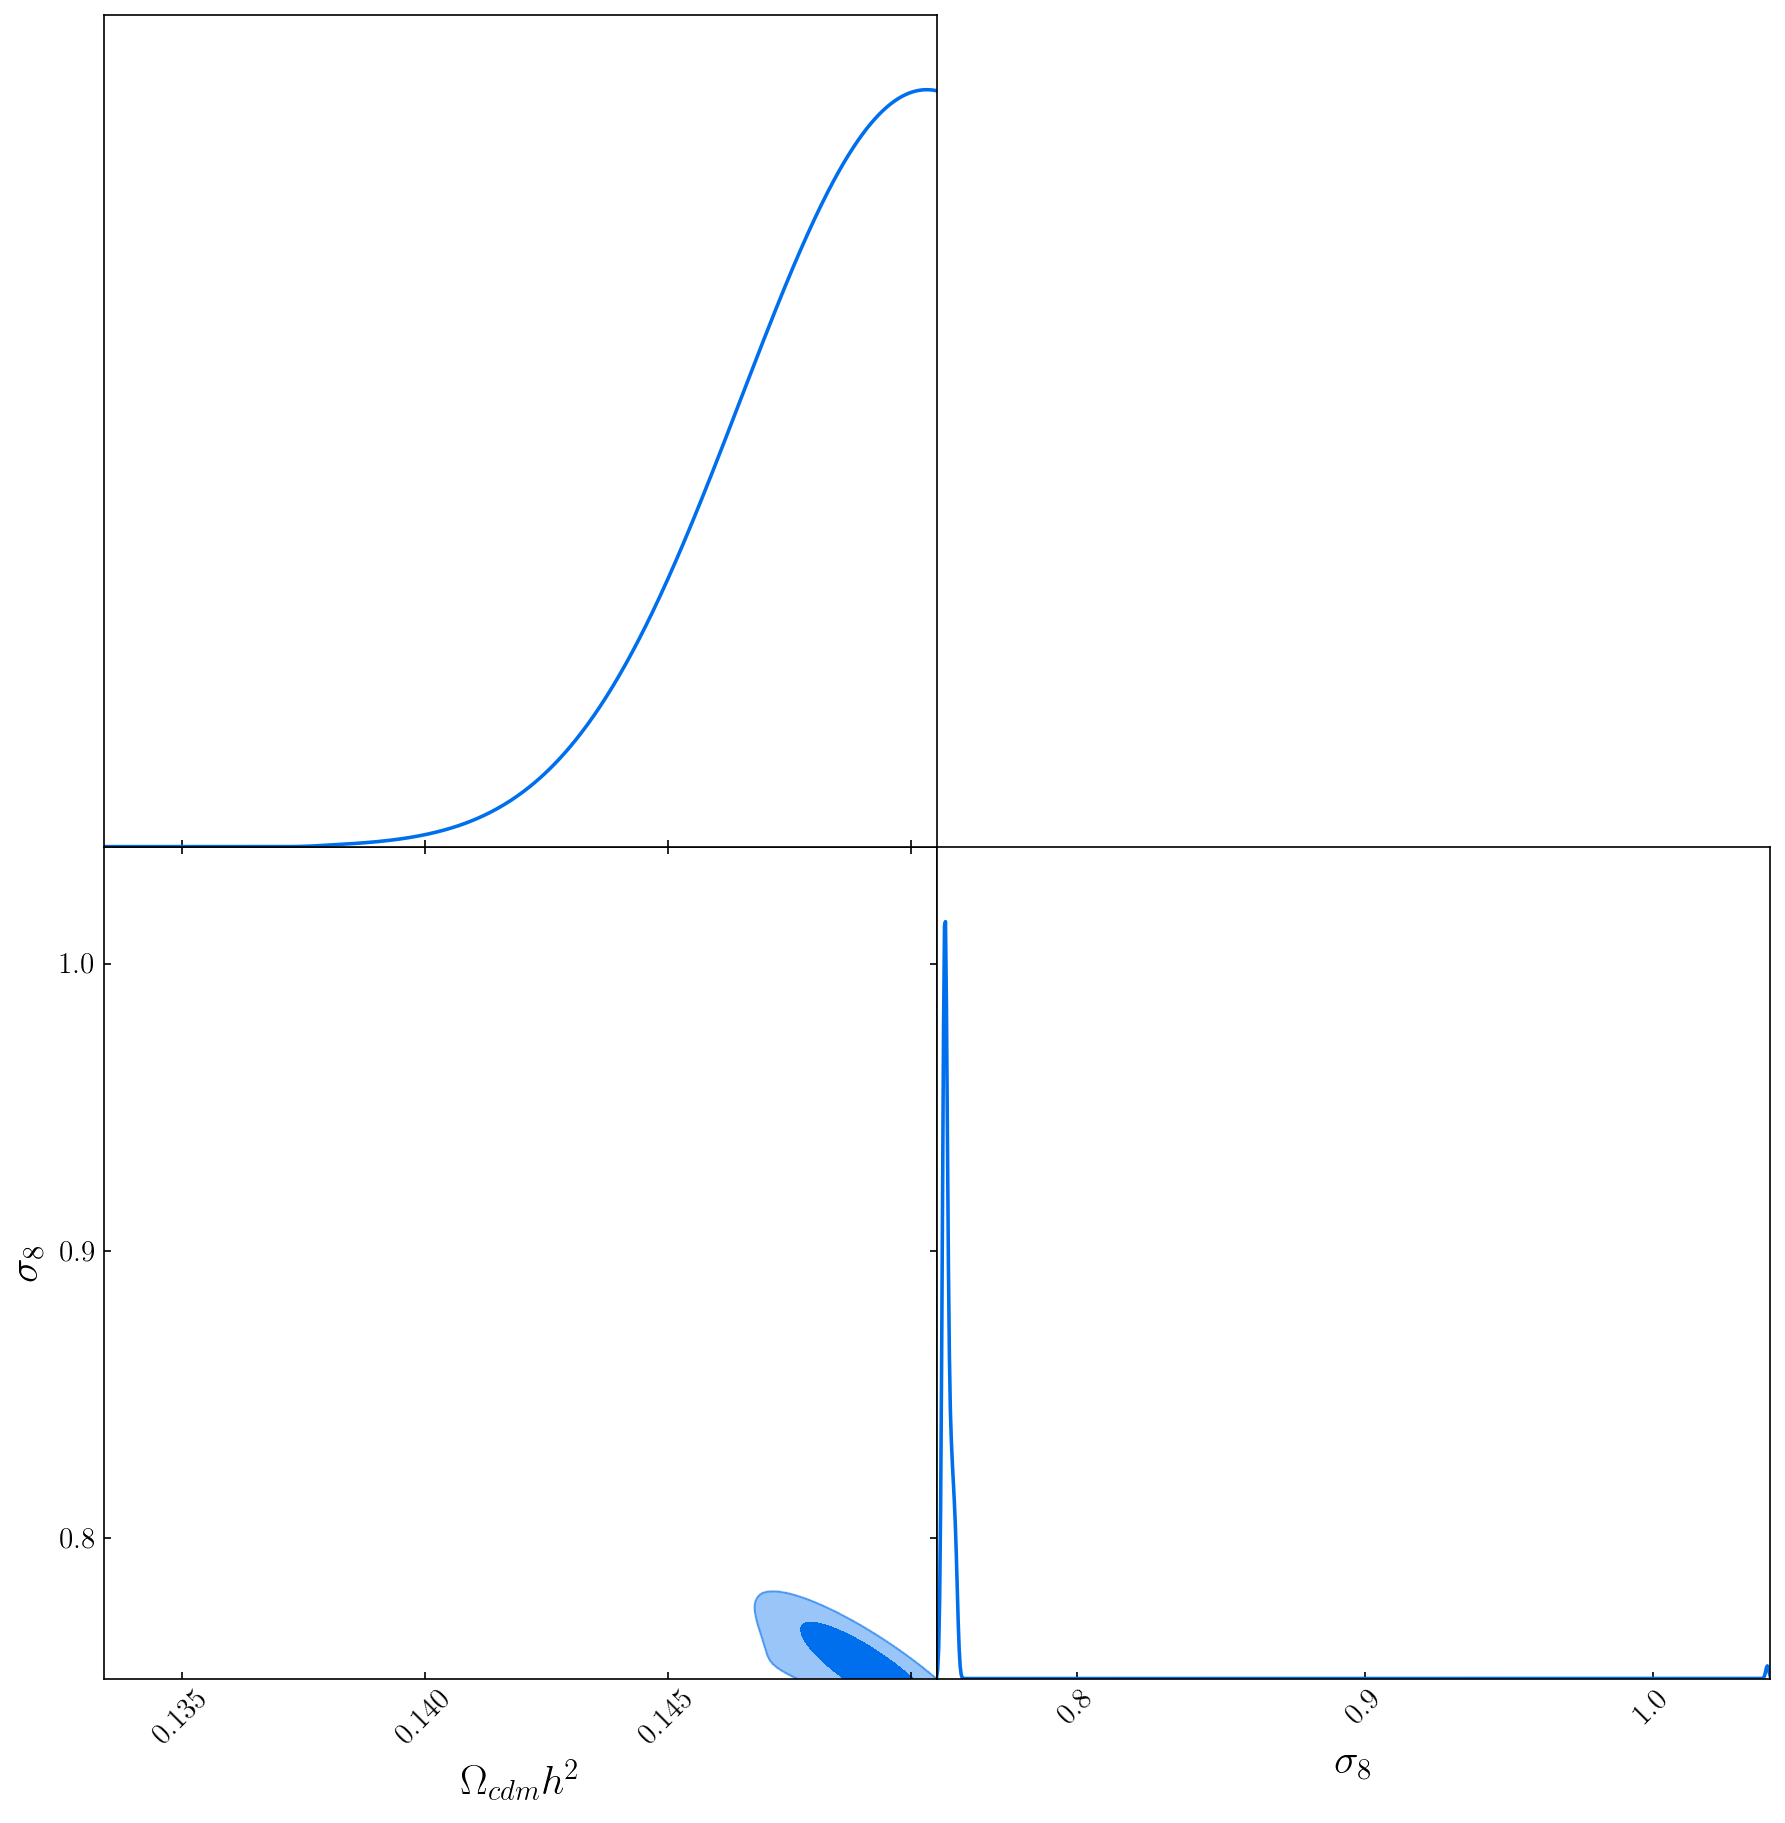

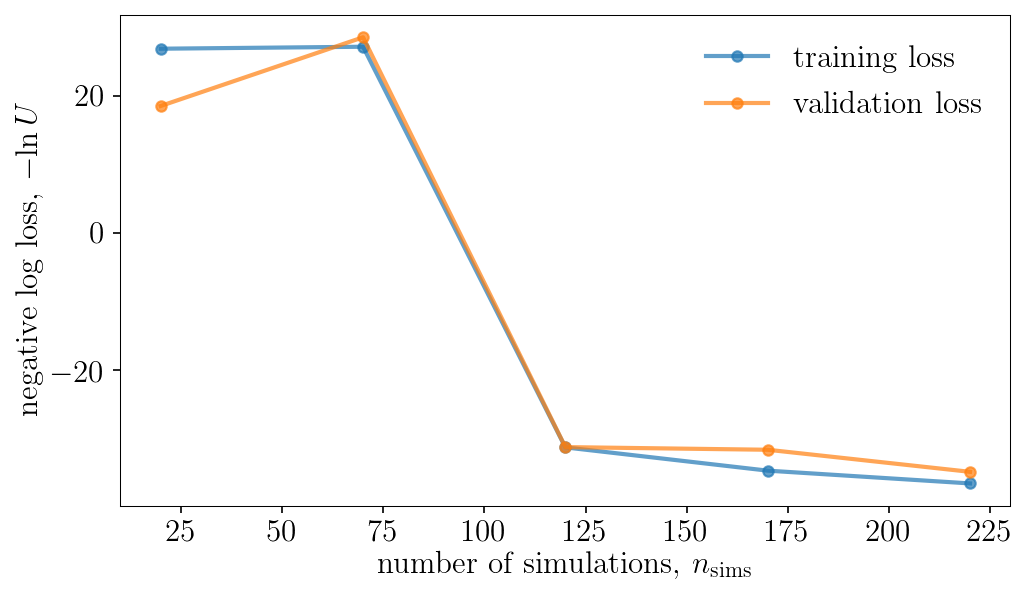

Population 15/20
Sampling proposal density...


/home/aizhana/.local/lib/python3.7/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in double_scalars
  lnpdiff = f + nlp - state.log_prob[j]


Done.


Sampling approximate posterior...


Done.
Removed no burn in


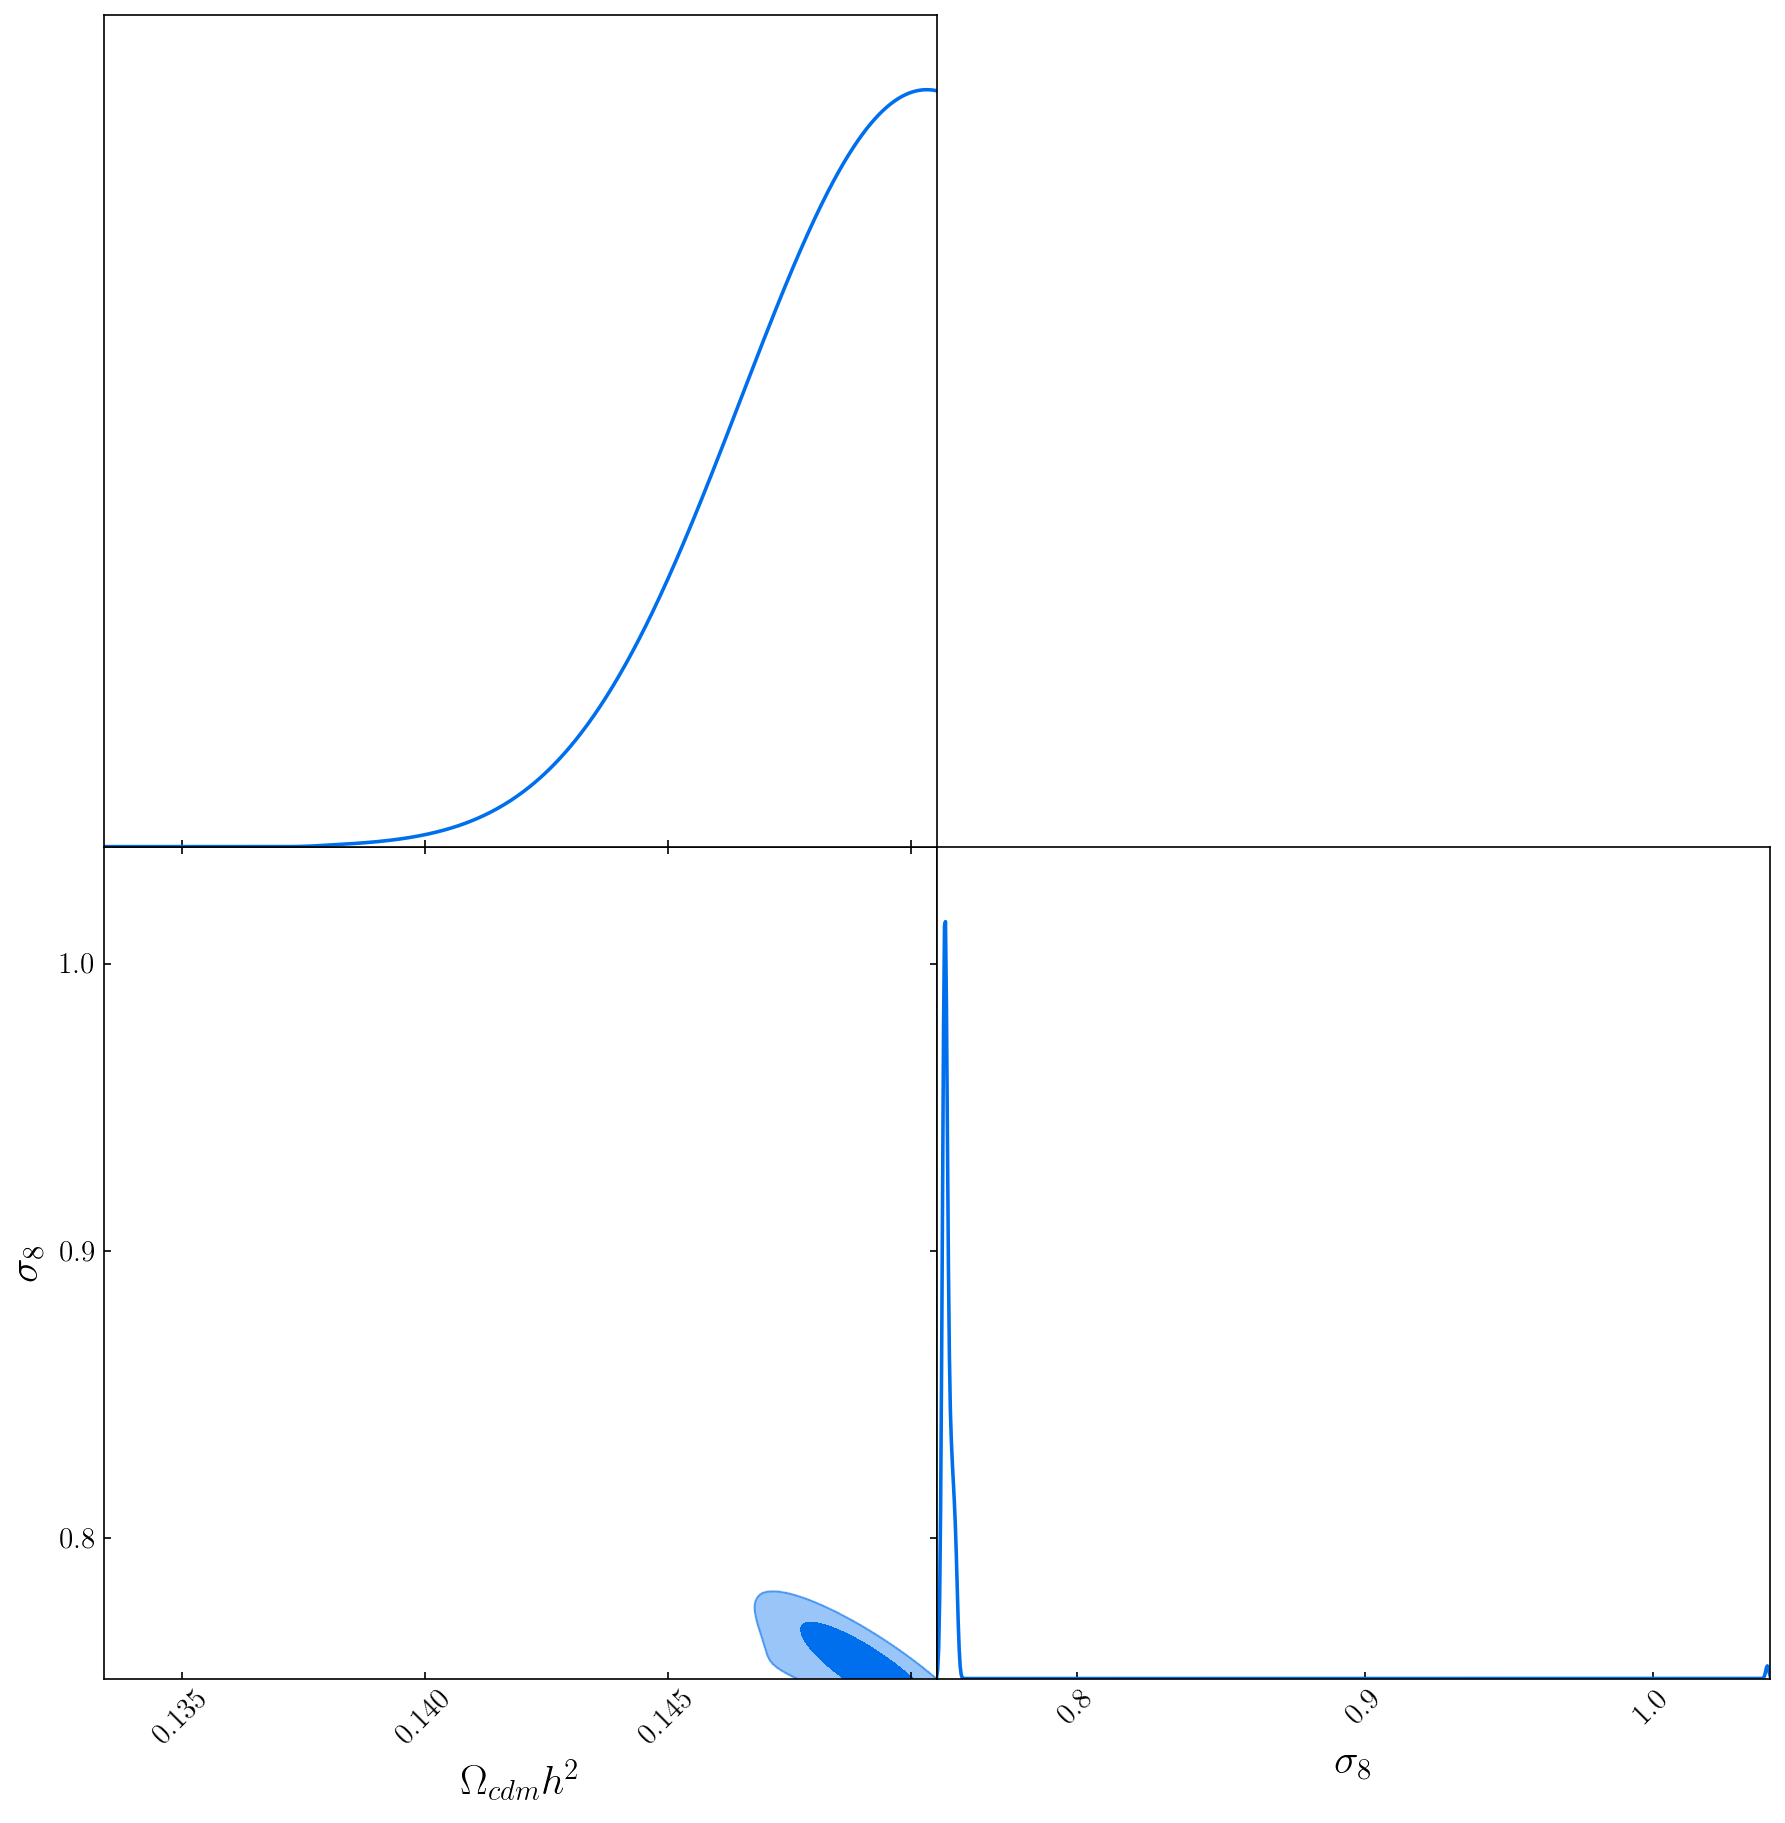

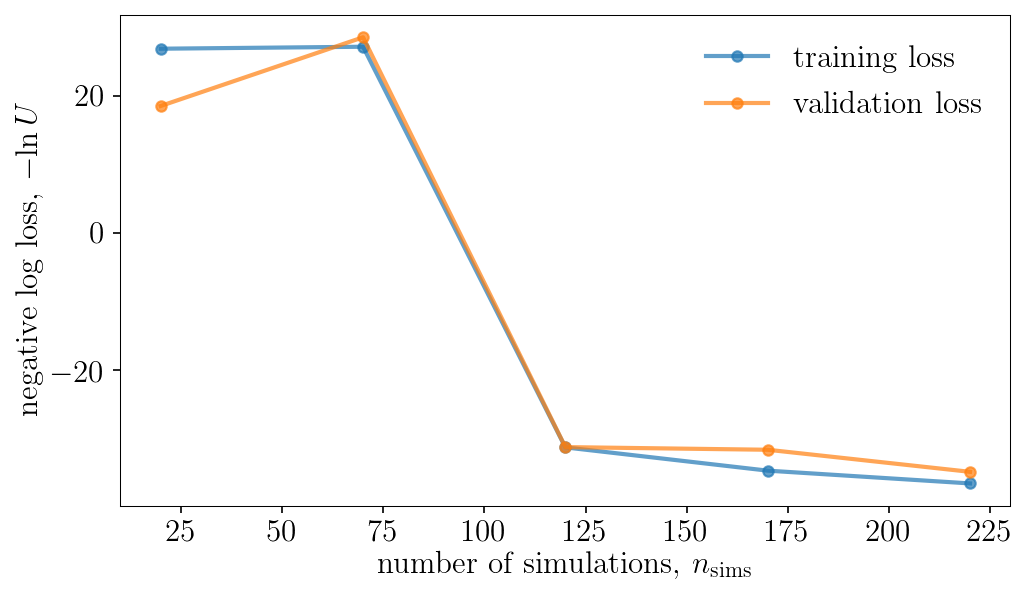

Population 16/20
Sampling proposal density...


/home/aizhana/.local/lib/python3.7/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in double_scalars
  lnpdiff = f + nlp - state.log_prob[j]


Done.


Sampling approximate posterior...


Done.
Removed no burn in


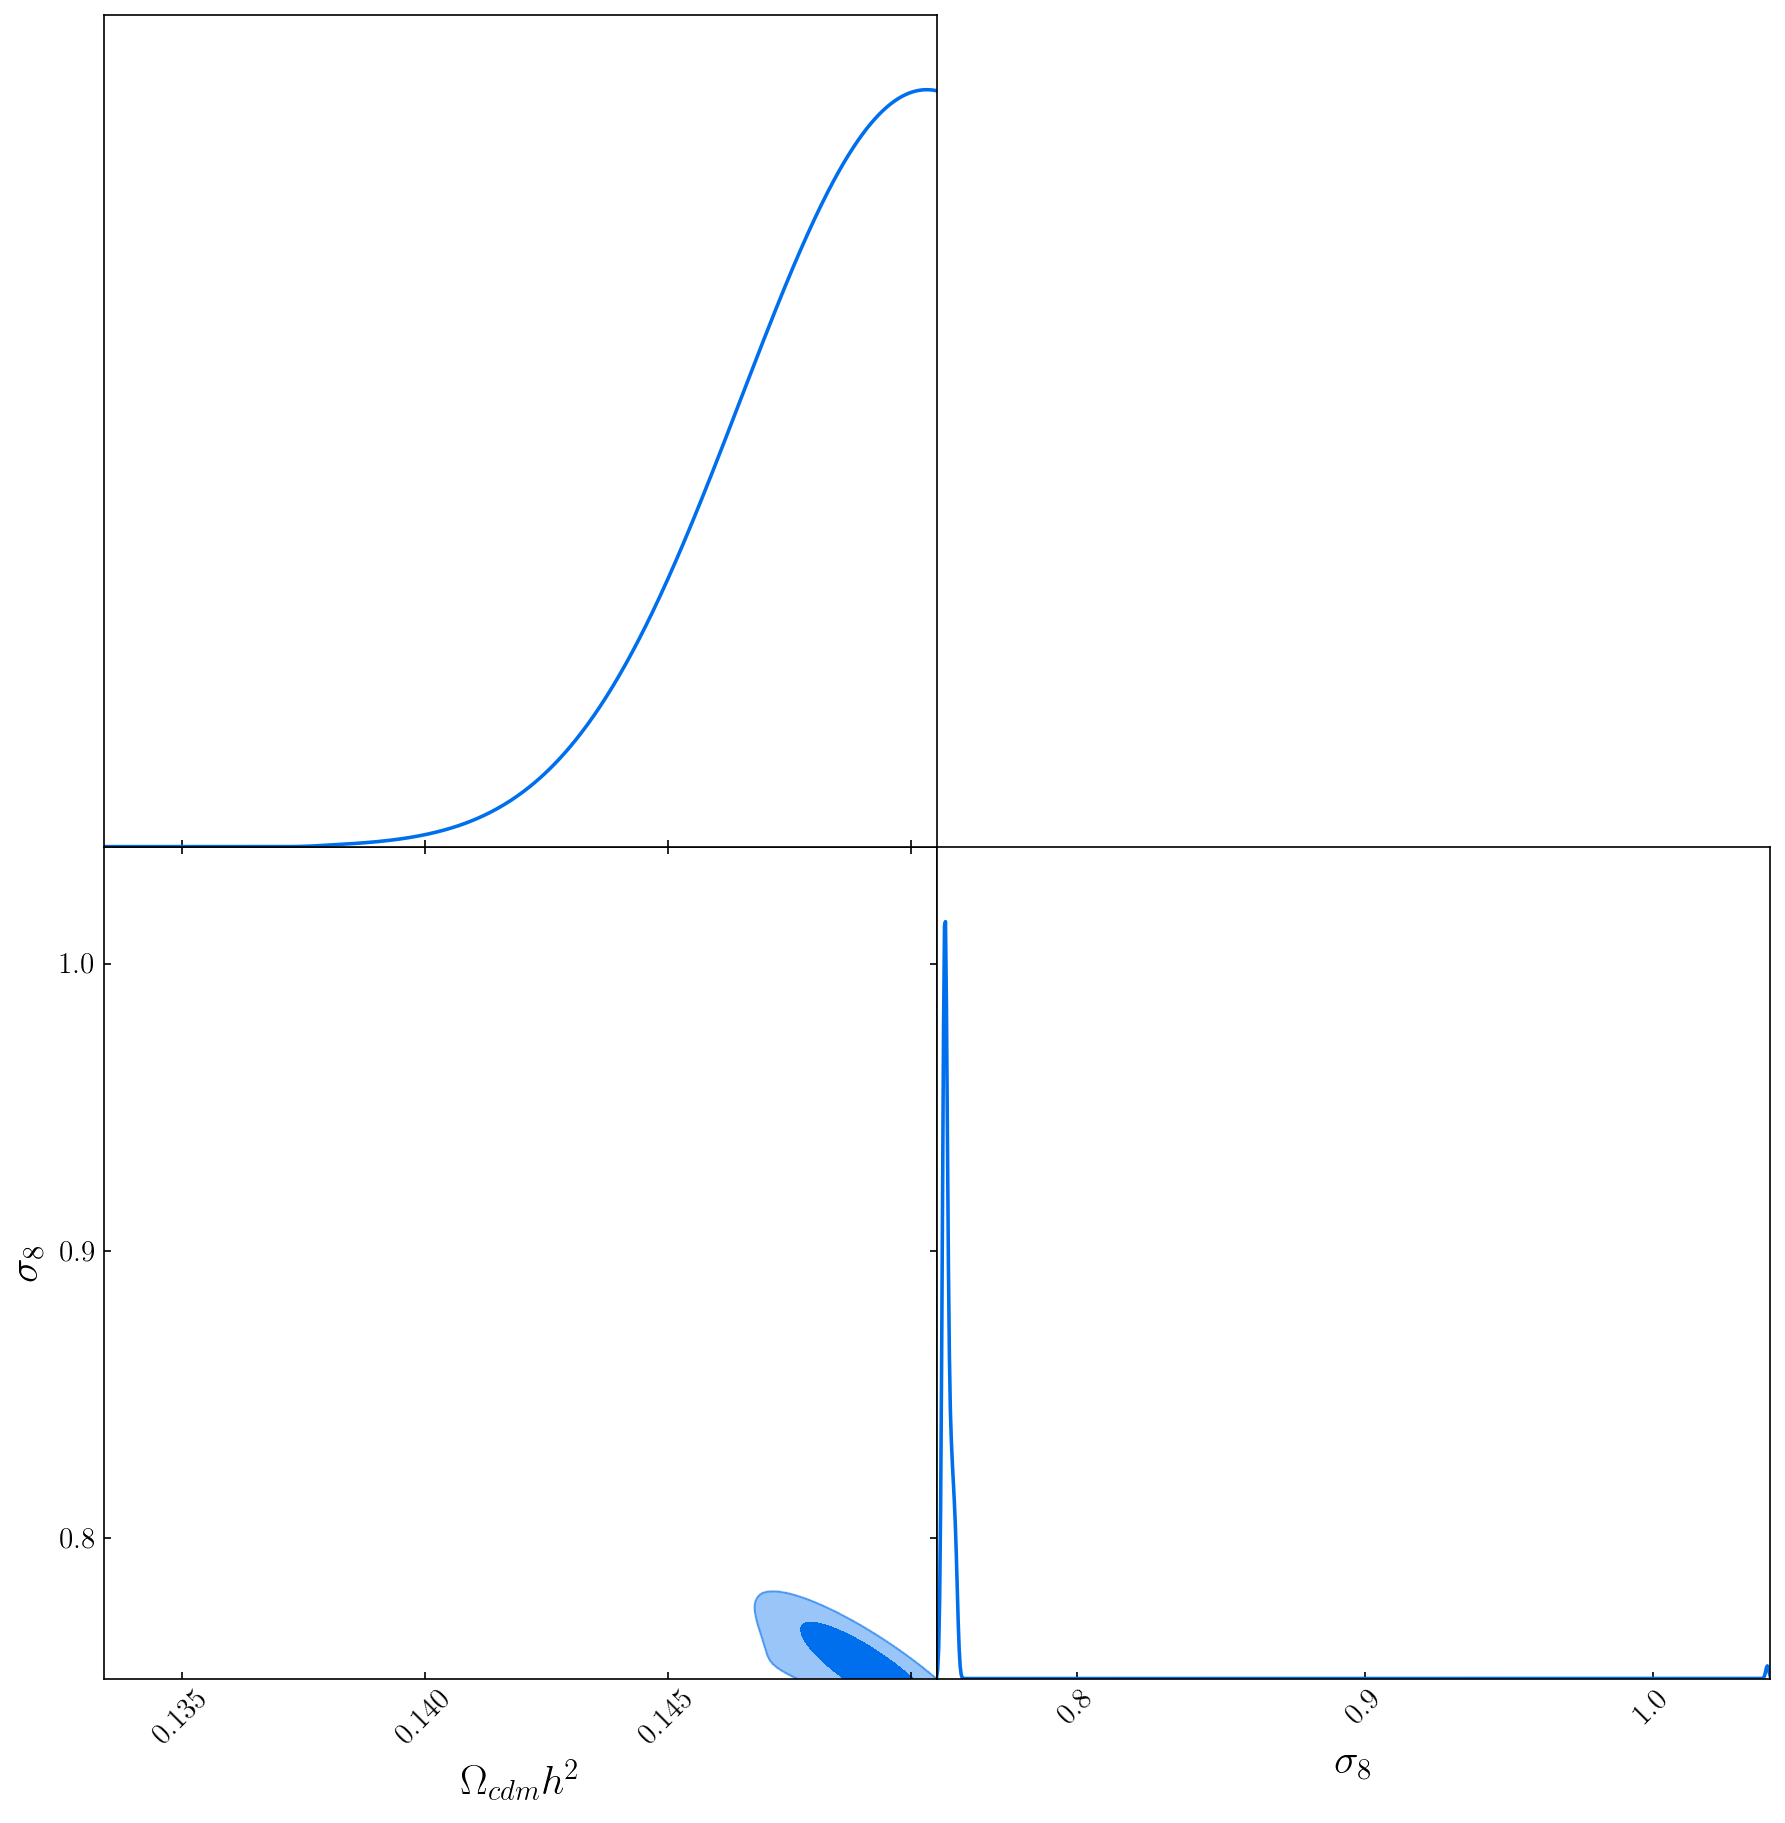

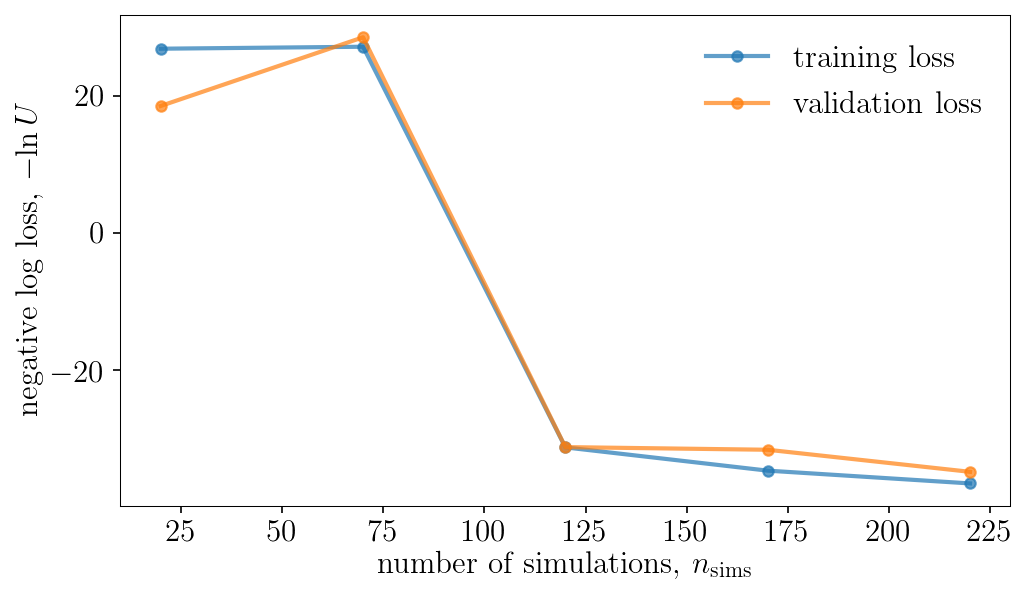

Population 17/20
Sampling proposal density...


/home/aizhana/.local/lib/python3.7/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in double_scalars
  lnpdiff = f + nlp - state.log_prob[j]


Done.


Sampling approximate posterior...


Done.
Removed no burn in


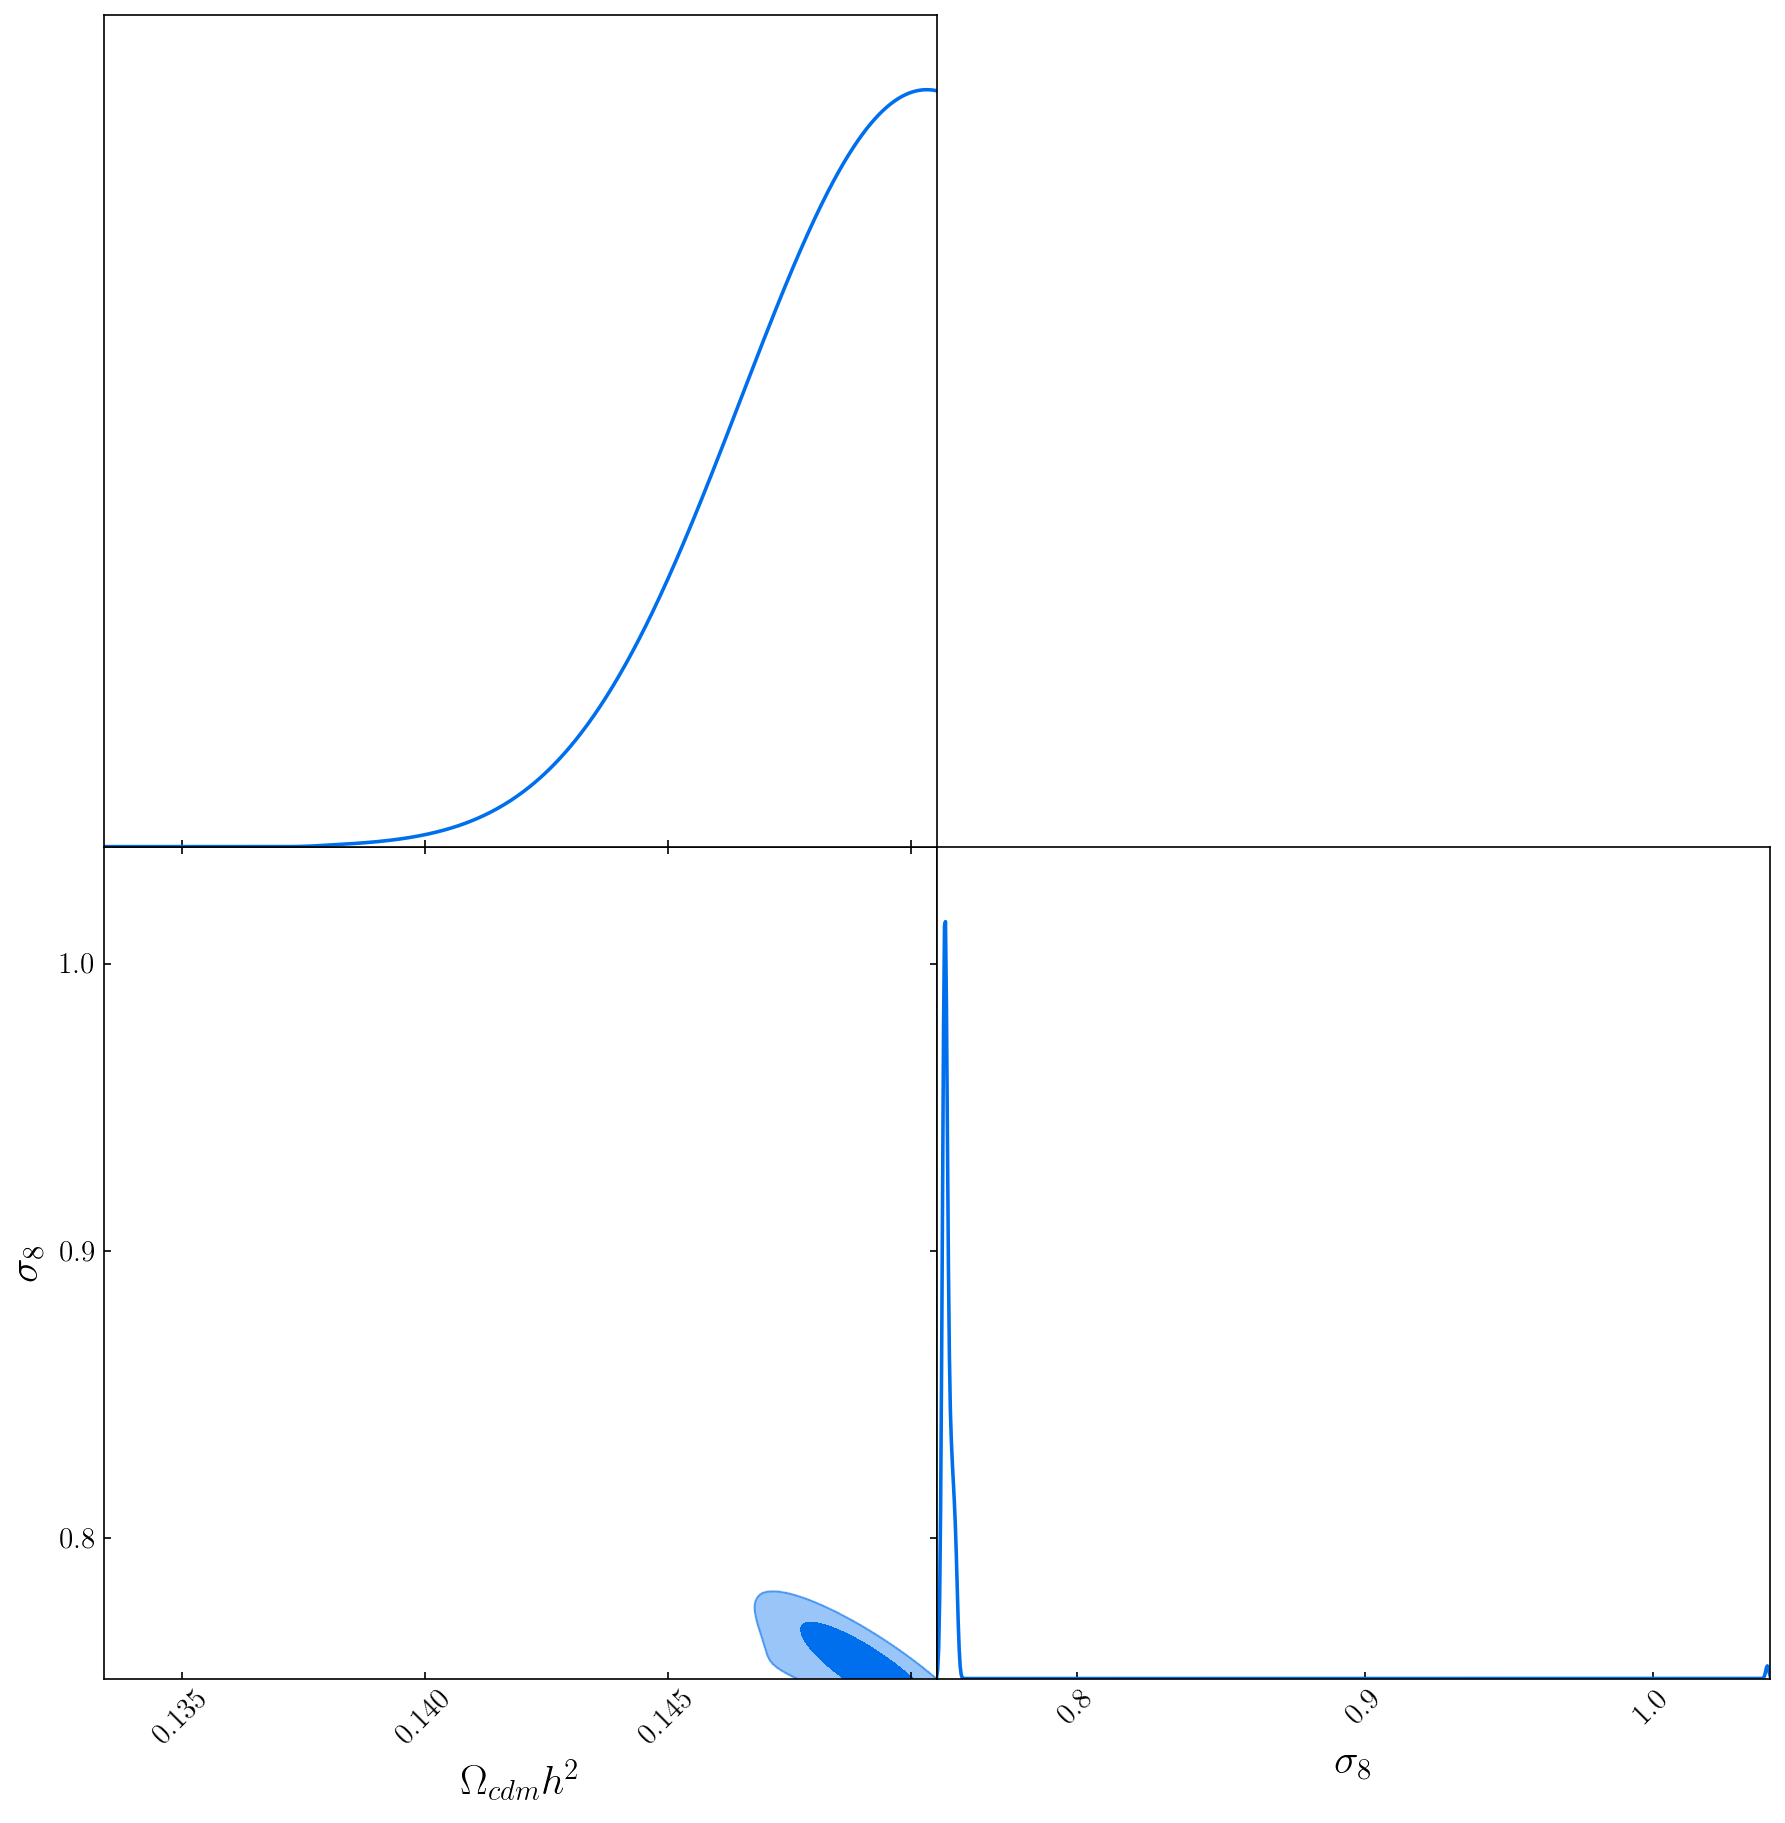

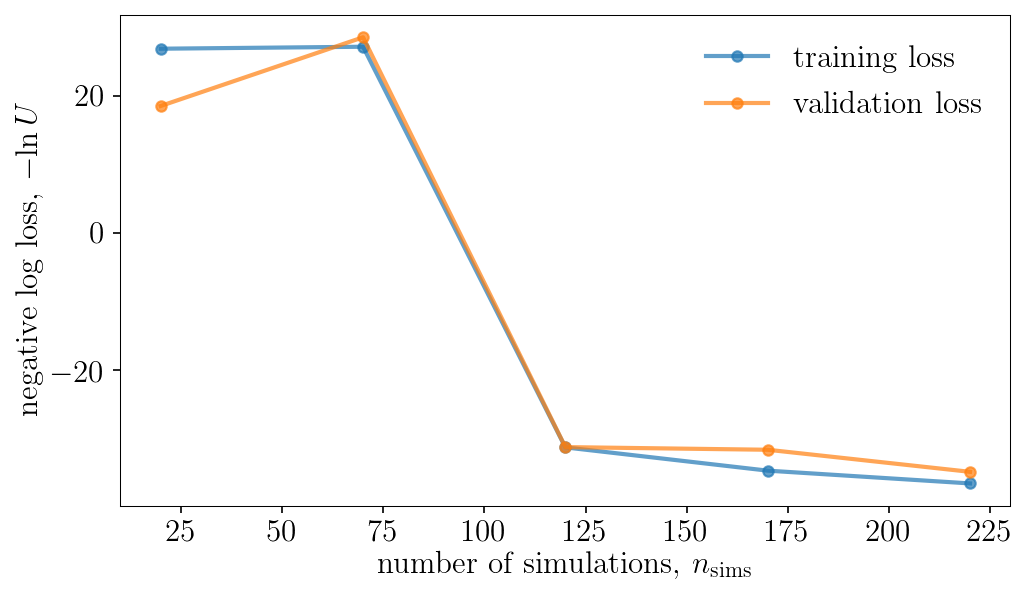

Population 18/20
Sampling proposal density...


/home/aizhana/.local/lib/python3.7/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in double_scalars
  lnpdiff = f + nlp - state.log_prob[j]


Done.


Sampling approximate posterior...


Done.
Removed no burn in


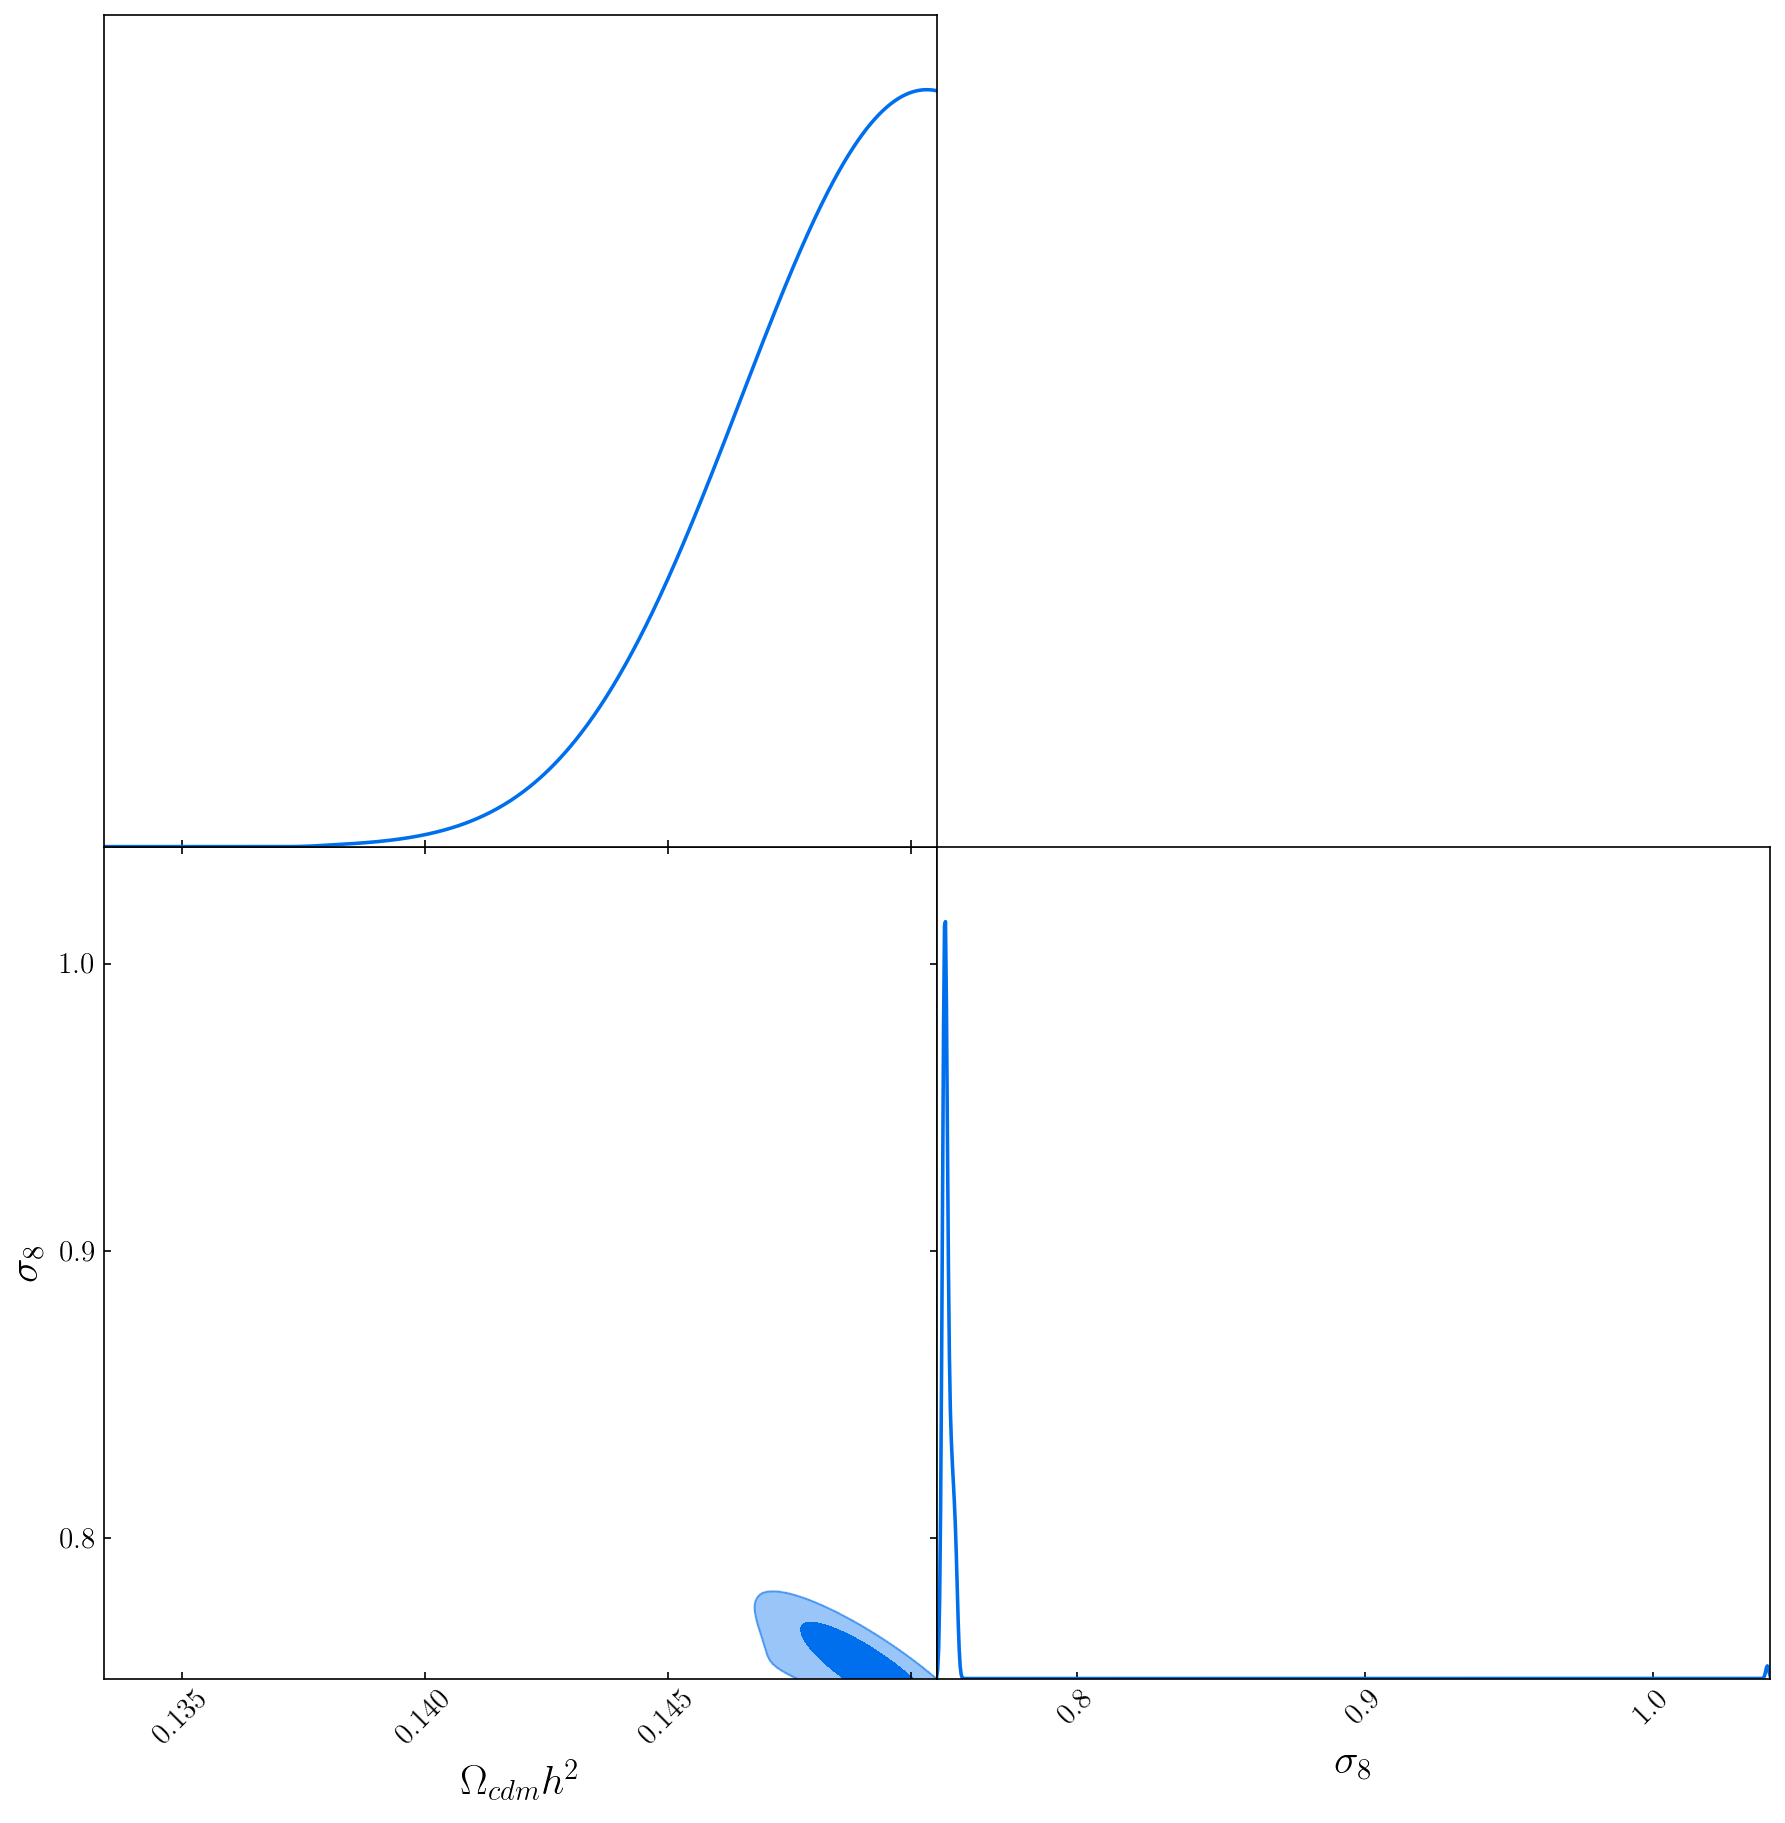

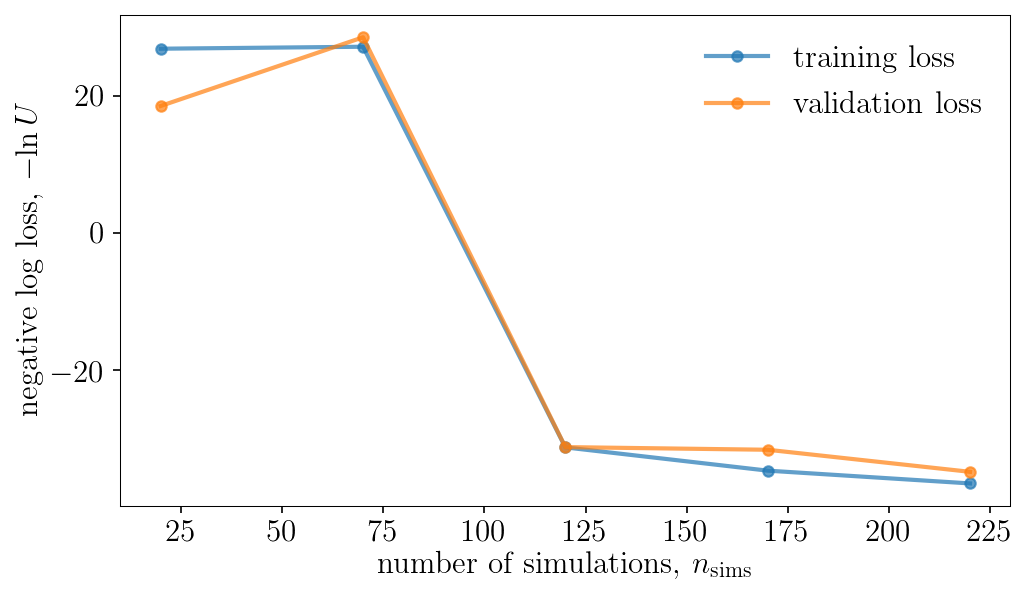

Population 19/20
Sampling proposal density...


/home/aizhana/.local/lib/python3.7/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in double_scalars
  lnpdiff = f + nlp - state.log_prob[j]


Done.


Sampling approximate posterior...


Done.
Removed no burn in


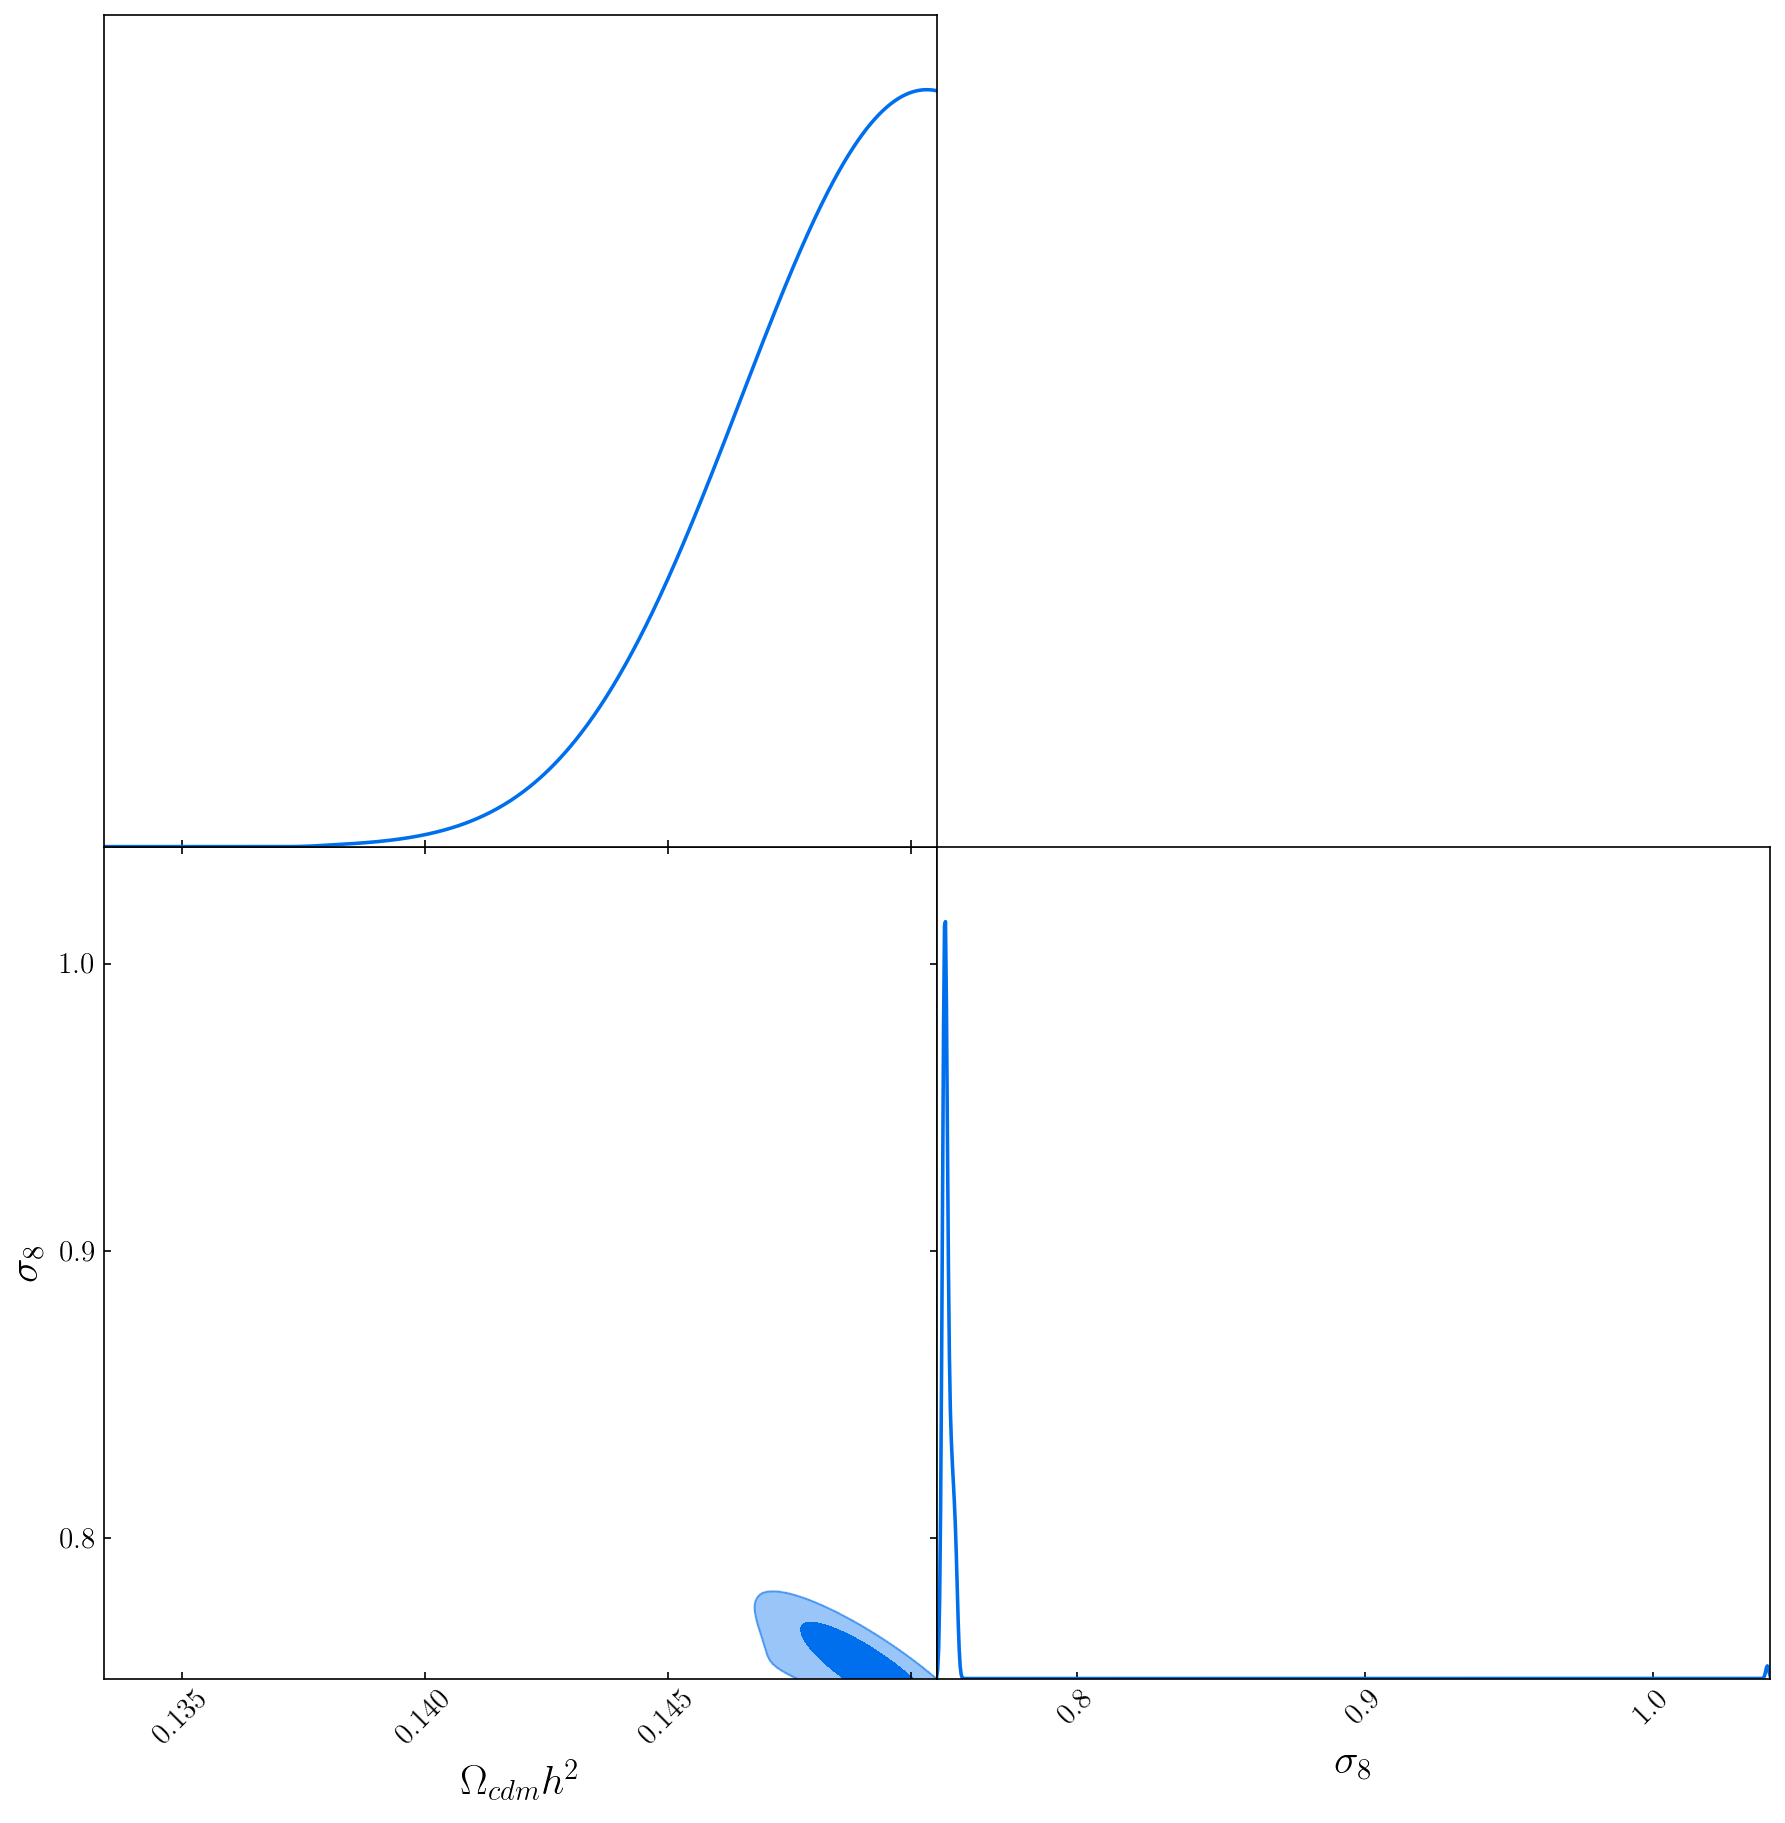

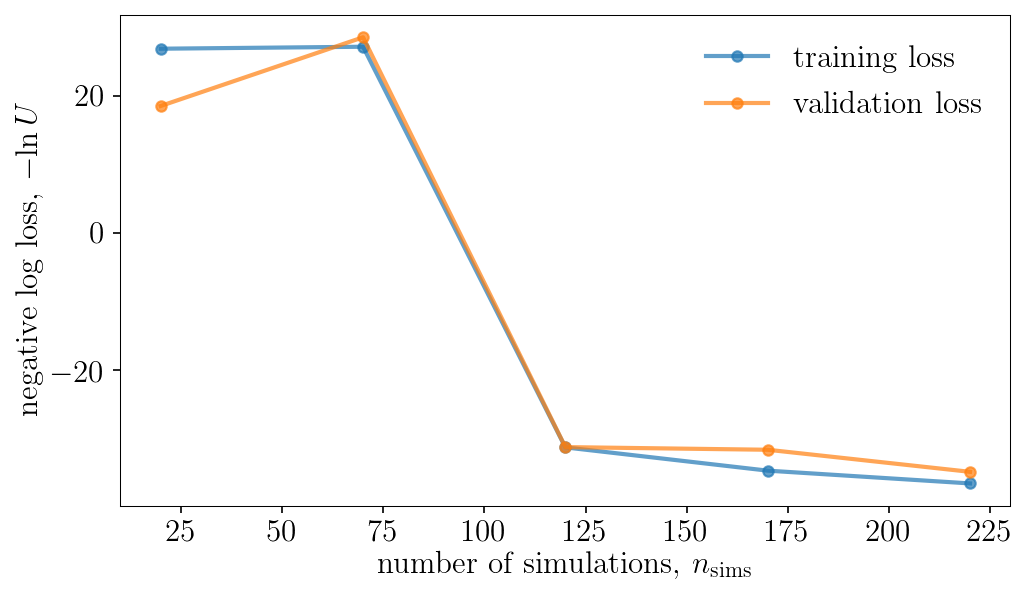

Population 20/20
Sampling proposal density...


/home/aizhana/.local/lib/python3.7/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in double_scalars
  lnpdiff = f + nlp - state.log_prob[j]


Done.


Sampling approximate posterior...


Done.
Removed no burn in


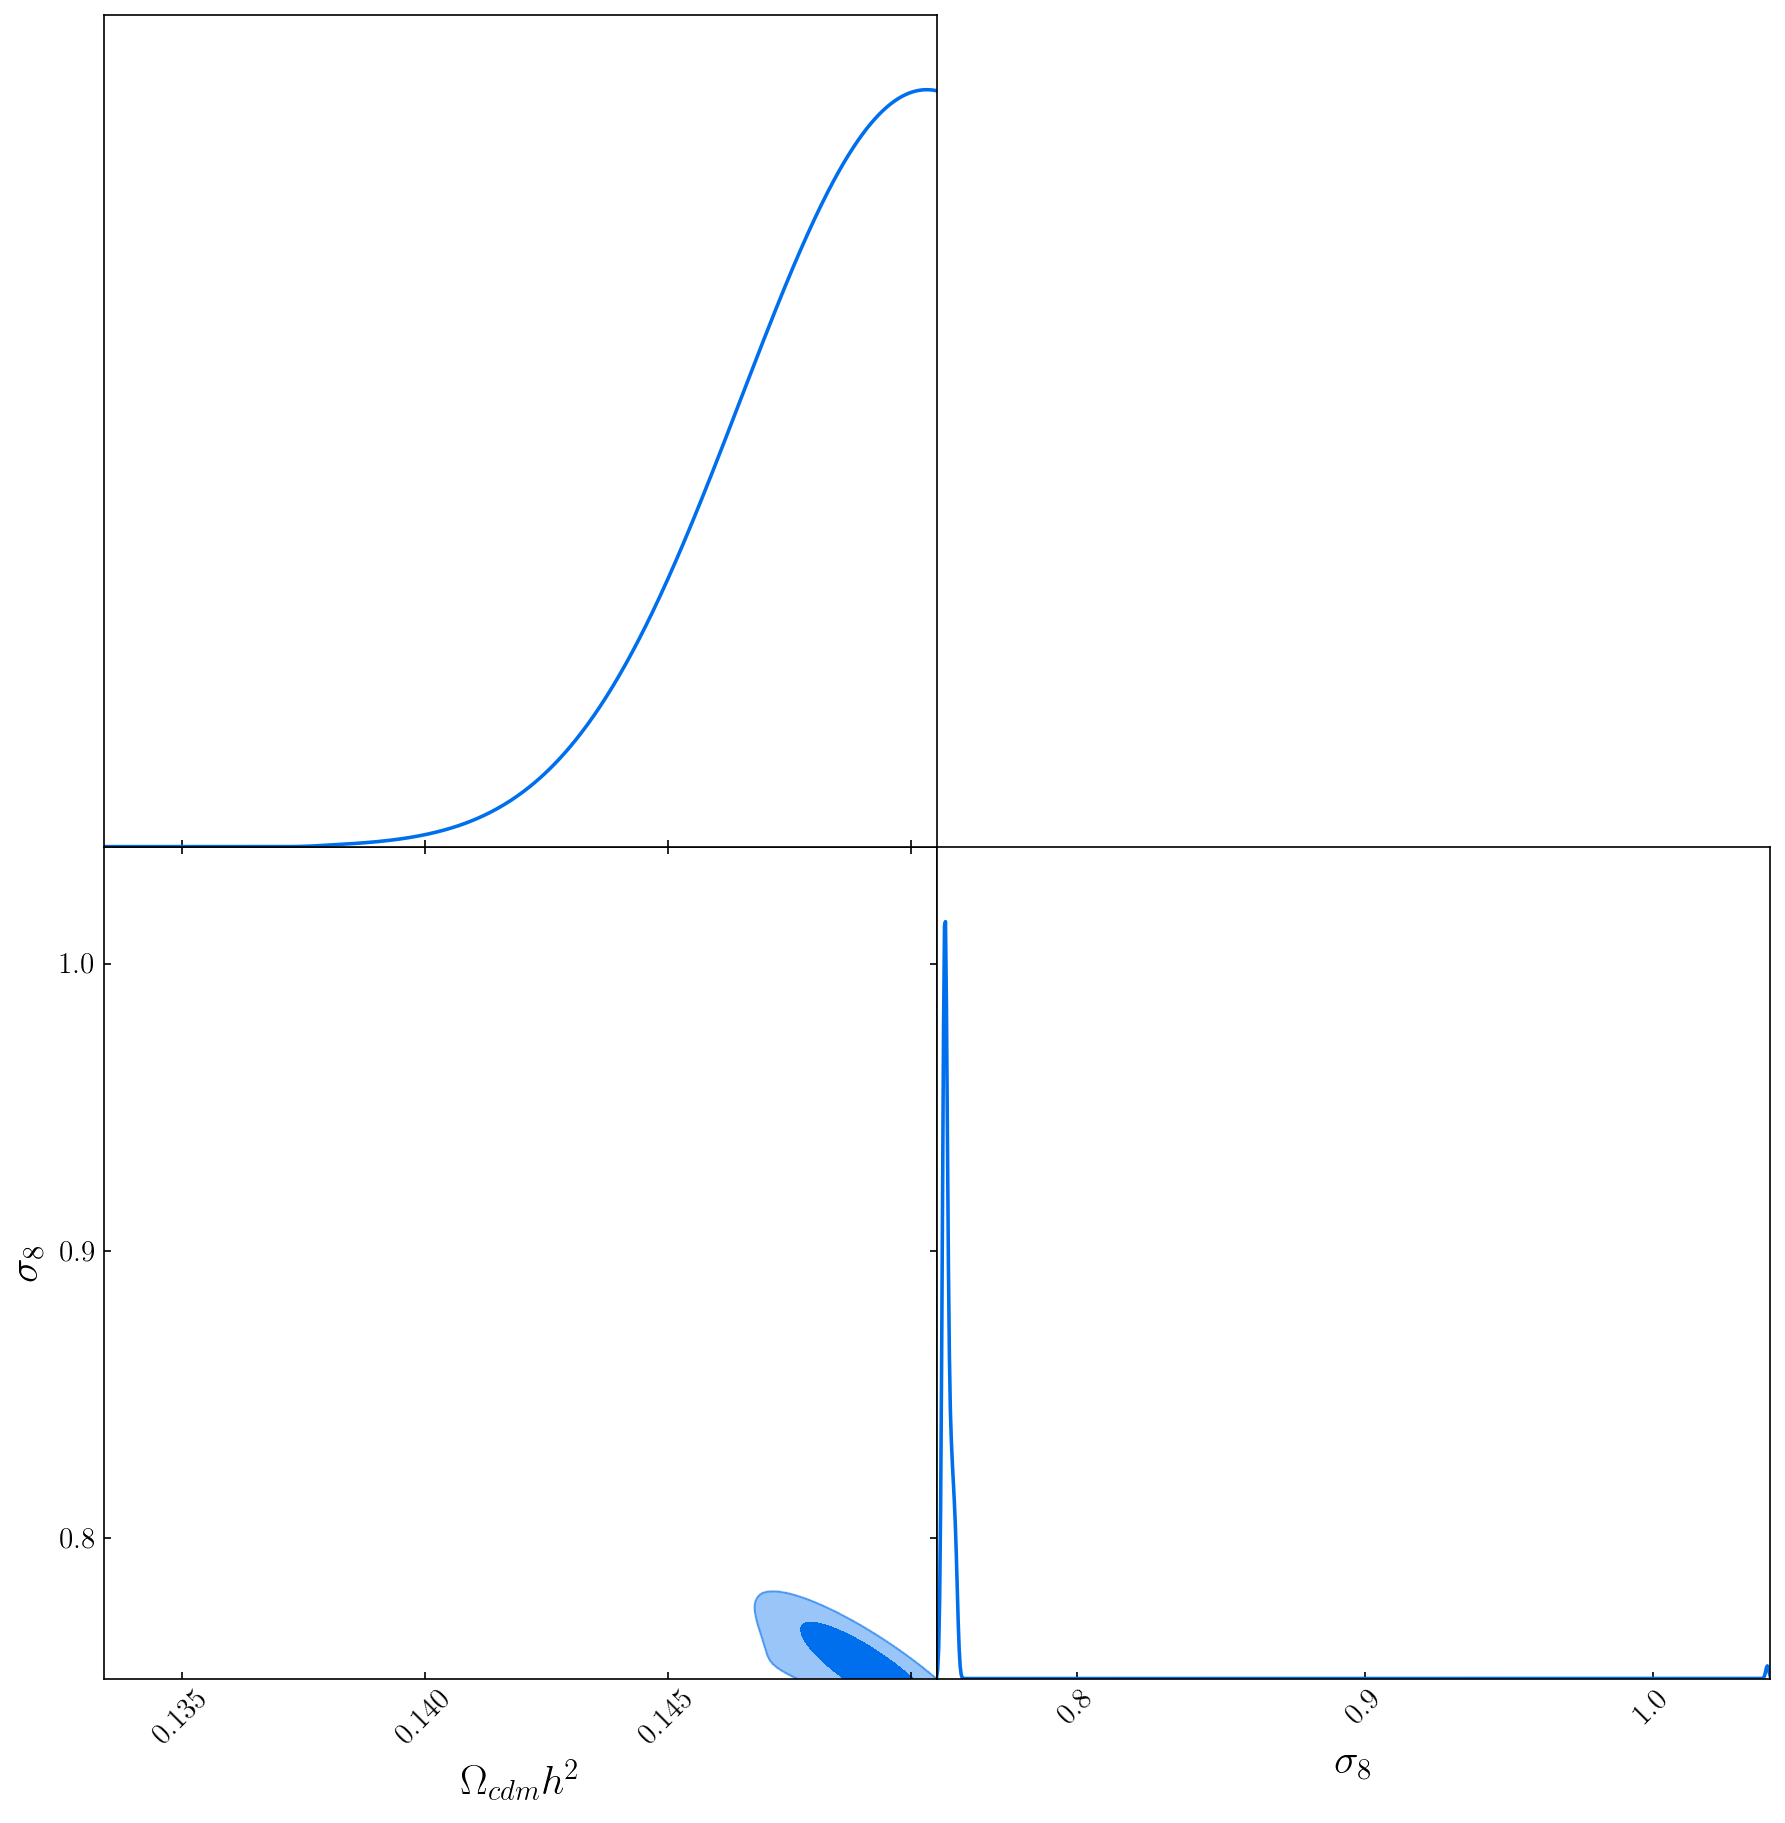

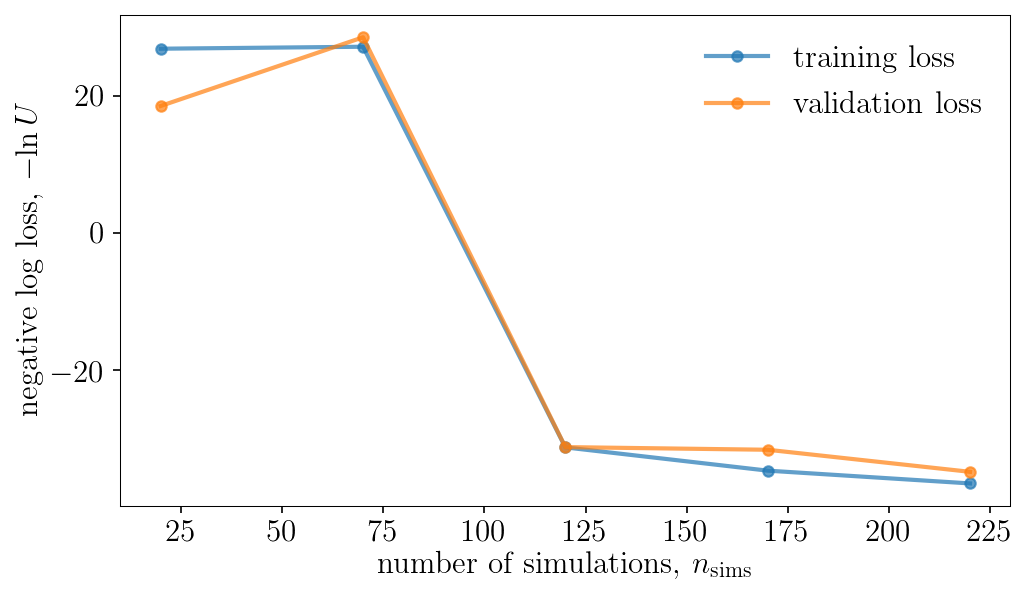

In [22]:
DelfiEnsemble.sequential_training(simulator, compressor, n_initial, n_batch, n_populations, patience=20, 
                                  save_intermediate_posteriors=True)

## Sample the learned posterior

In [23]:
x0 = DelfiEnsemble.posterior_samples[np.random.choice(np.arange(len(DelfiEnsemble.posterior_samples)), p=DelfiEnsemble.posterior_weights.astype(np.float32)/sum(DelfiEnsemble.posterior_weights), replace=False, size=DelfiEnsemble.nwalkers),:]
posterior_samples, posterior_weights, log_prob = DelfiEnsemble.emcee_sample(x0=x0)

/home/aizhana/.local/lib/python3.7/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in double_scalars
  lnpdiff = f + nlp - state.log_prob[j]


## Alright let's plot it!
Feed it a list of `(n_samples, n_parameters)` arrays for making a triangle plot; in this case let's just plot the posterior samples.

Removed no burn in


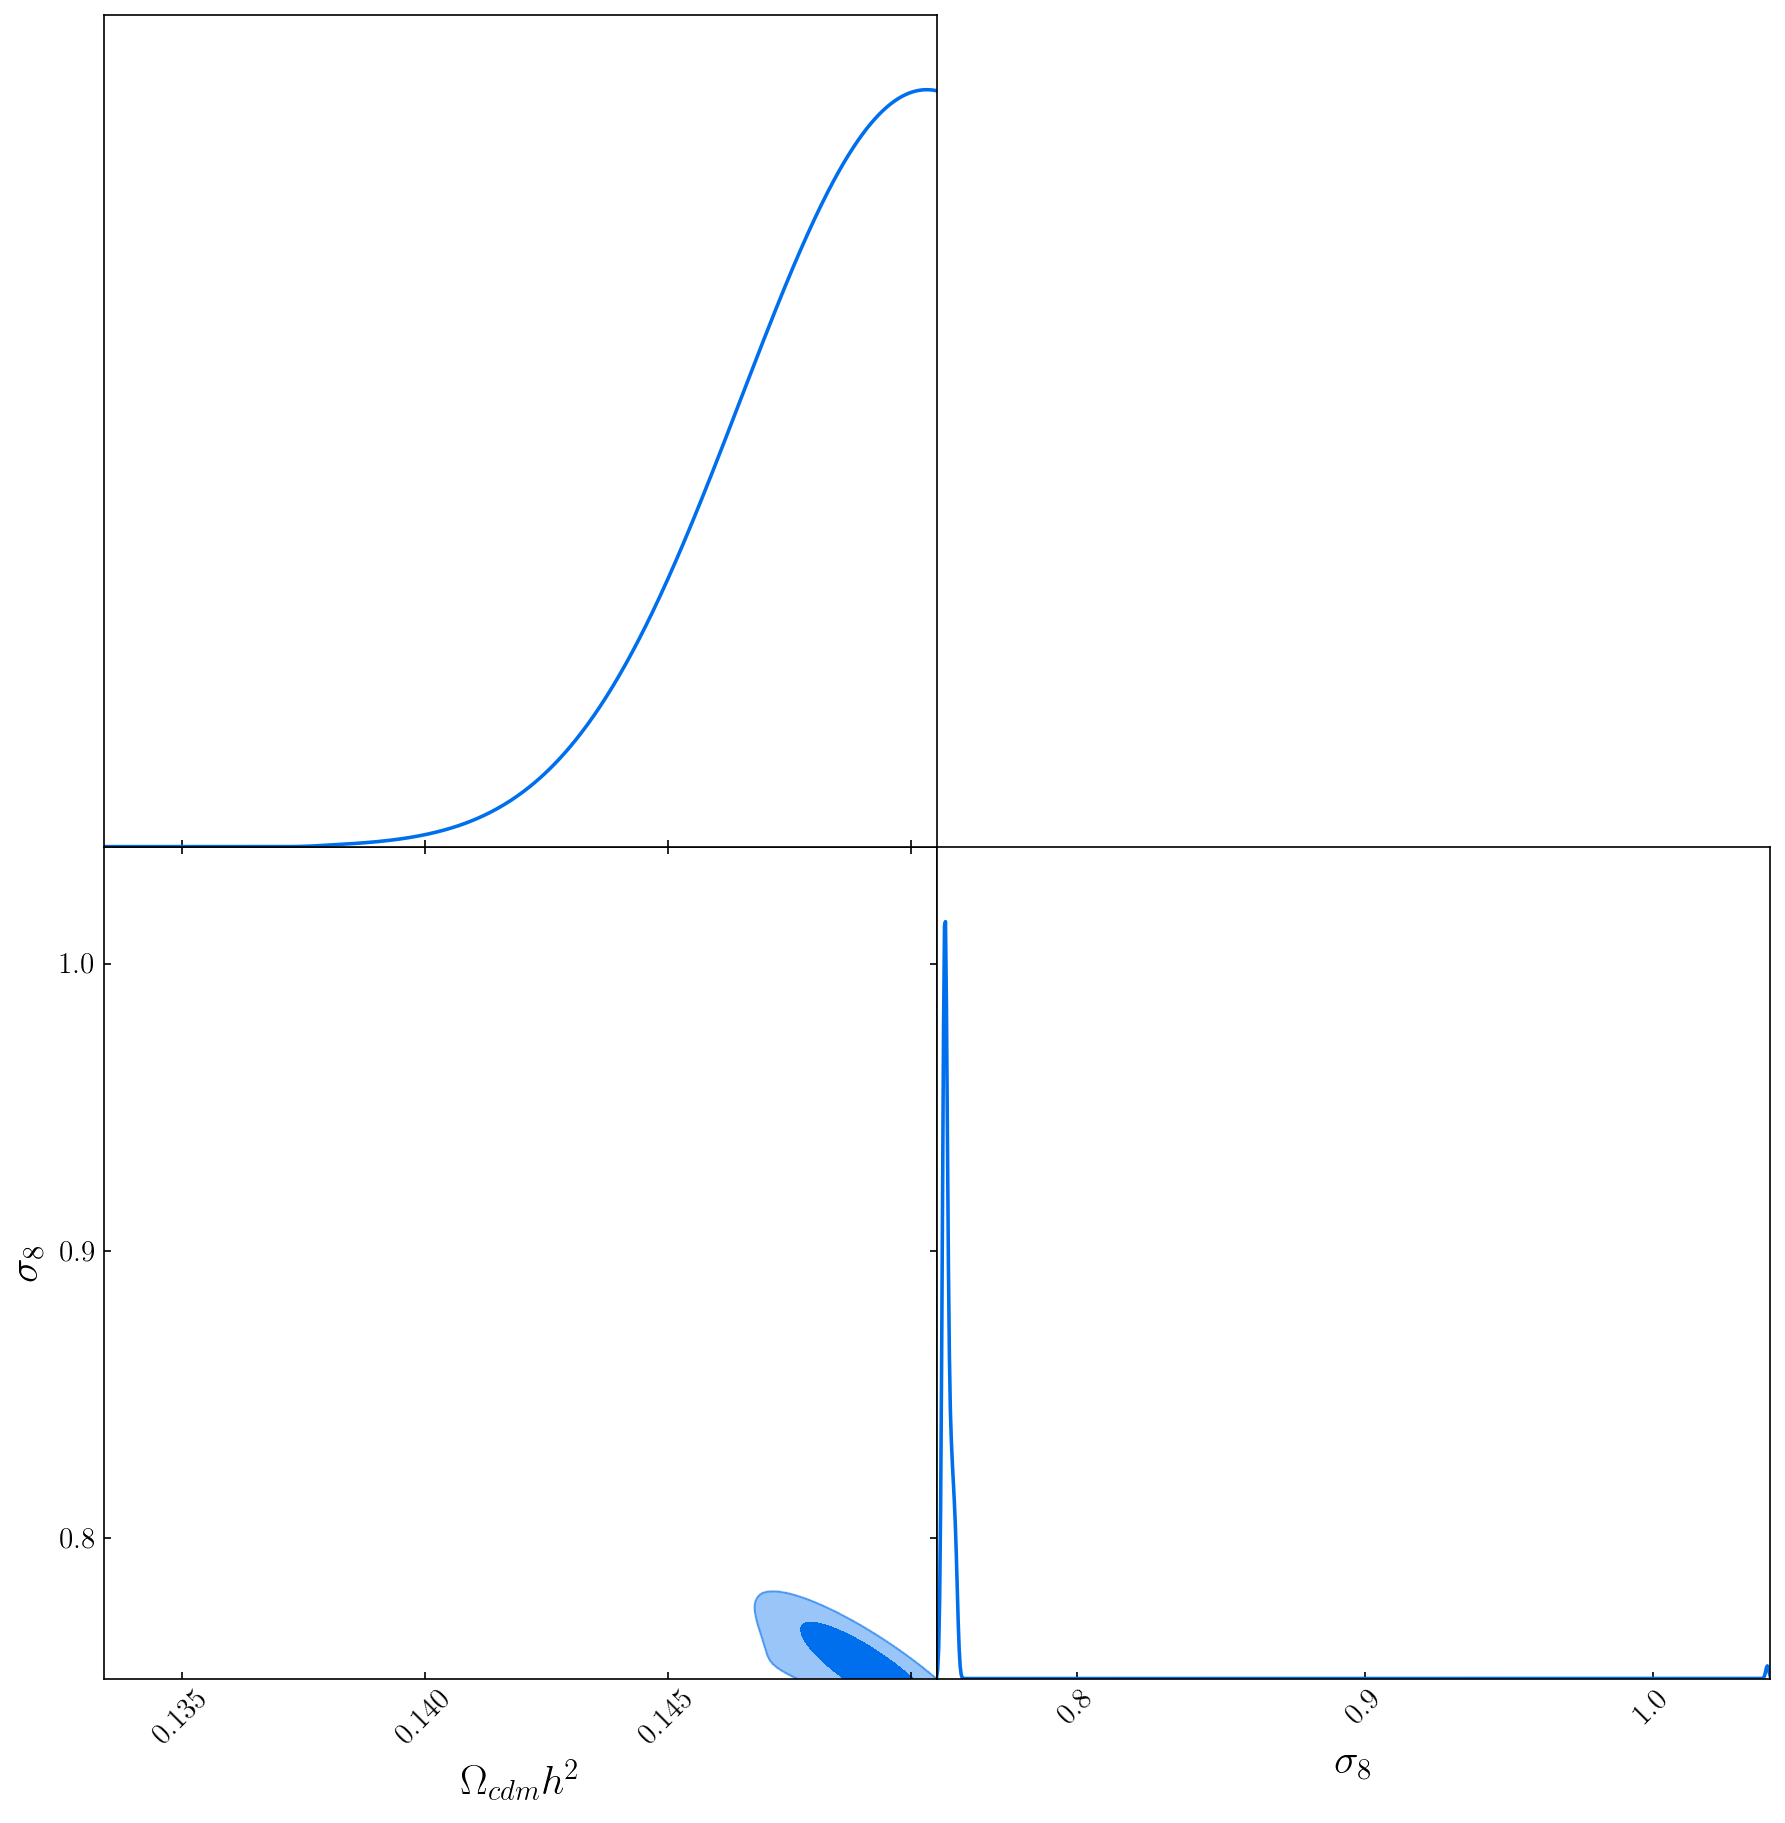

In [24]:
DelfiEnsemble.triangle_plot(samples=[posterior_samples], weights=[posterior_weights])
